# Overview

The aim of the following analysis is to formulate an investment strategy on the Warsaw Stock Exchange using data on a given company from its quarterly financial reports. The analysed dataset is based on information from the website biznesradar.pl and covers 69 quarters from Q4 2004 to Q4 2021. Analysis of the gurus' strategies proved that it is possible to select indices in such a way as to outperform the Warsaw Stock Exchange Index. However, the analysed strategies used only a fraction of the available indicators and, moreover, their original versions were developed on the basis of experience from the NYSE. It may be that other indicators, overlooked by the analysed strategies, are relevant for the WSE.

The analysed dataset does not have a target feature by default. Such a variable - in simple terms - is the share price dynamics of a given company. We want to find out which indicators make the dynamics positive (i.e. what suggests that a given company may be an interesting investment) and which ones make the dynamics negative (i.e. what we need to pay attention to so that our investment does not result in a loss).

A rule of thumb attributed to Benjamin Graham says that we should assume a certain level of return we want to achieve and a certain period of time we give to the investment - more specifically 50-100% over 2-3 years at most. This means that we will sell shares in a particular company either when we have reached our assumed level of profit or when the assumed time period has elapsed (whatever the return on such an investment is). In addition, we should have at least 10 companies in our portfolio. Initial analysis of the gurus' strategies has shown that a reasonable assumption is that our investment should achieve a profit of 50% within a year.

When considering the creation of a target feature, we must start with two variables. The **price_dynamics_y** feature represents dynamics of price after the following year, e.g. dynamics between Q1 2020 and Q1 2021. The **best_price_dynamics_y** feature represents the best scenario dynamics of price in the following year, i.e.
- if in Q1 2020 company's price was 100, and in the next four quarters (i.e. Q2 2020, Q3 2020, Q4 2020 and Q1 2021) it was 101, 105, 103 and 104 respectively, the **best_price_dynamics_y** would be 0.05 (i.e. (105 - 100) / 100);
- if in Q1 2020 company's price was 100, and in the next four quarters (i.e. Q2 2020, Q3 2020, Q4 2020 and Q1 2021) it was 95, 96, 97 and 90 respectively, the **best_price_dynamics_y** would be -0.03 (i.e. (97 - 100) / 100).

The **adj_best_price_dynamics_y** and **adj_price_dynamics_y** features represent **best_price_dynamics_y** and **price_dynamics_y** adjusted by capital gains tax (19% in Poland) and inflation rate. It does not include transaction fees, as they may vary depending on broker, transaction value etc.

Making the above assumptions, we can create the following variables:
- **final_price_dynamics** takes value of 0.5 if **adj_best_price_dynamics_y** exceeds it and **price_dynamics_y** otherwise, i.e. if the company's share price has risen by more than 50% in a year, this means that we have sold the shares with this return, while if not, we have sold them after a year of buying.
- **interesting_company** is a variable which takes *Yes* if given company make a profit above 50%, *Maybe* if company make a profit below 50% (or does not make a loss) and *No* if company make a loss.

There will be also two additional variables:
- **sold_in_q** denotes the quarter in which the company's shares were sold (i.e. the quarter in which the company's price rose by 50% or the quarter one year after the purchase).
- **final_wig_dynamics** equivalent to **final_price_dynamics**, but referring to the WIG and not a given company.

In this part of analysis, using regression methods, we will try to predict the value of **final_price_dynamics** and see if the resulting model will be better than gurus' strategies. 

Recall that the so-called zero effort strategy (i.e. a stock index investment) produced an average return of 5.6% and made losses in 38% of the quarters analysed. In contrast, the best analysed strategy - the modified Kirkpatrick's strategy - yielded an average profit of 18%, made losses in 23% of the analysed quarters and 30% of the buy signals would end in a loss. The next best strategy - the modified Zweig's strategy - yielded an average profit of 15%, made losses in 19% of the analysed quarters and 34% of the buy signals would end in a loss.

### Packages & dataset loading

In [1]:
"""Packages loading"""
import glob
from itertools import combinations
import os
from textwrap import wrap

import dalex as dx
import joblib
from lazypredict.Supervised import LazyRegressor
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
import sklearn.ensemble as ens
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import KNNImputer, SimpleImputer
import sklearn.metrics as skm
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder, power_transform, PowerTransformer, StandardScaler
import xgboost as xgb

In [2]:
# Additional settings
xgb.set_config(verbosity=0)
pd.set_option('display.float_format', '{:.4f}'.format)

In [3]:
# Dataset loading (the newest full dataset)
dataset = pd.read_csv(
    max(
        glob.glob(os.getcwd().replace('analysis', '') + 'data\\full_datasets\\*.csv'),
        key = os.path.getctime
    ),
    index_col=False,
    low_memory=False
)

### Auxilliary functions

In [4]:
def feature_exploration(feature, feature_name, target):
    """Function presenting feature statistics"""

    print(f'Percentiles of {feature_name}:')
    for i in range(5, 100, 5):
        print(f'{i}th: {round(feature.quantile(i / 100), 4)}')

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    sns.boxplot(
        x=pd.qcut(
            feature,
            20,
            labels=['Below 5th percentile']
            + [f'{i}th - {i+5}th percentile' for i in range(5, 95, 5)]
            + ['Over 95th percentile'],
            duplicates='drop'
        ),
        y=target,
        ax=axs[0]
    )

    sns.scatterplot(
        x=feature,
        y=target,
        ax=axs[1]
    )

    axs[0].axhline(0, color='black', linewidth=.8)
    axs[1].axhline(0, color='black', linewidth=.8)

    for i in range(2):
        axs[i].set_xlabel(feature_name)
        axs[i].set_ylabel('Final price dynamics')

    axs[0].tick_params(axis='x', labelrotation=90)

    plt.suptitle(feature_name)
    axs[0].set_title('Box plot vs final price dynamics')
    axs[1].set_title('Scatter plot vs final price dynamics')

    plt.grid()
    plt.tight_layout;

In [5]:
def preprocessor(temp_dataset, drop_subset, treshold):
    """All initial transformations"""
    # temp_dataset = copy of the original dataset
    # non_num_columns = non-numeric columns
    # div_columns = dividend columns
    # drop_subset = target and auxilliary columns to be removed from X sets
    # treshold = % of observations with missing values

    # Fixing bug resulting from dividing the features
    # In some values dot is replaced by comma and whole column gets wrong data type
    temp_dataset.replace(',', '.', regex=True, inplace=True)
    subset = temp_dataset.columns[~temp_dataset.columns.isin([
        'quarter', 'company_code', 'best_price_dynamics_in_q',
        'price_dynamics_y_in_q', 'country', 'industry'
    ])]
    temp_dataset[subset] = temp_dataset[subset].astype(float)
    temp_dataset = temp_dataset.replace([np.inf, -np.inf], np.nan)

    # Fill NAs in dividend data with 0 (NA here means that dividend most probably wasn't paid)
    # The same for positive net earnings in previous years
    cat_cols = [
        'dividend_1Y', 'continuous_dividend', 'pos_net_earnings_5Y', 'pos_net_earnings_4Y',
        'pos_net_earnings_3Y', 'pos_net_earnings_2Y', 'pos_net_earnings_1Y',
        'continuous_price_growth'
    ]
    for col in cat_cols:
        temp_dataset[col] = temp_dataset[col].fillna(0)

    # There is a wrong price reported by company FMG in Q4 2018. The company reported price at
    # 0.15 - however, in neighbouring quarters it was 30.93 and 28. Checking this information
    # on another stock exchange website (stooq.pl) confirms that this is an incorrect value
    # - this company was listed on the stock exchange only once in Q4 2018, but with a price of
    # 29, which is a better approximation of the real price.
    idx = temp_dataset.loc[
        np.where(
            (temp_dataset.company_code == 'FMG')
            & (temp_dataset.quarter == '2018/Q4')
        )
    ].index[0]
    temp_dataset.loc[idx, 'price'] = 29
    temp_dataset.loc[idx, 'best_price_dynamics_y'] = (28 - 29) / 29
    temp_dataset.loc[idx, 'price_dynamics_y'] = (9 - 29) / 29

    # Adding new features
    dynamics = {
        'adj_best_price_dynamics_y':
        81 * temp_dataset.best_price_dynamics_y / temp_dataset.inflation_yy_m,
        'adj_price_dynamics_y':81 * temp_dataset.price_dynamics_y / temp_dataset.inflation_yy_m,
        'adj_best_wig_dynamics_y':
        81 * temp_dataset.best_wig_dynamics_y / temp_dataset.inflation_yy_m,
        'adj_wig_dynamics_y':81 * temp_dataset.wig_dynamics_y / temp_dataset.inflation_yy_m,
        'final_price_dynamics':pd.Series(
            np.where(
                81 * temp_dataset.best_price_dynamics_y / temp_dataset.inflation_yy_m > .5,
                .5, 81 * temp_dataset.price_dynamics_y / temp_dataset.inflation_yy_m
            )
        ),
        'final_wig_dynamics':pd.Series(
            np.where(
                81 * temp_dataset.best_wig_dynamics_y / temp_dataset.inflation_yy_m > .5,
                .5, 81 * temp_dataset.wig_dynamics_y / temp_dataset.inflation_yy_m
            )
        ),
        'sold_in_q':pd.Series(np.where(
            81 * temp_dataset.best_price_dynamics_y / temp_dataset.inflation_yy_m > .5,
            temp_dataset.best_price_dynamics_in_q,
            temp_dataset.price_dynamics_y_in_q
        ))
    }
    dynamics = pd.DataFrame(dynamics)

    dynamics['interesting_investment'] = pd.Categorical(
        pd.Series(
            np.where(
                dynamics.final_price_dynamics == .5,
                'Yes', np.where(
                    dynamics.final_price_dynamics >= 0,
                    'Maybe', 'No'
                )
            )
        ),
        categories=['No', 'Maybe', 'Yes'],
        ordered=True
    )

    temp_dataset = pd.concat(
        [temp_dataset, pd.DataFrame(dynamics, index=temp_dataset.index)],
        axis=1
    )

    # Removing variables with more than x% missing values
    temp_dataset.dropna(thresh=len(temp_dataset) * treshold, axis=1, inplace=True)

    # Train test split
    # Target features kept in X_set for train-validation split
    X_set = temp_dataset.copy()
    y_set = temp_dataset.filter(['interesting_investment'])

    X_train, X_test, y_train, y_test = train_test_split(
        X_set, y_set, test_size=.15, random_state=1234,
        shuffle=True, stratify=y_set.interesting_investment
    )

    # Creating X_test_set
    y_reg_test = X_test.filter(['final_price_dynamics'])
    X_test.drop(drop_subset, axis=1, errors='ignore', inplace=True)

    test_set = (X_test, y_reg_test)

    # Train validation split
    X_set = X_train.copy()
    y_set = X_train.filter(['interesting_investment'])

    X_train, X_val, y_train, y_val = train_test_split(
        X_set, y_set, test_size=.15, random_state=1234,
        shuffle=True, stratify=y_set.interesting_investment
    )

    # Creating X_train_set
    y_reg_train = X_train.filter(['final_price_dynamics'])
    X_train.drop(drop_subset, axis=1, errors='ignore', inplace=True)

    train_set = (X_train, y_reg_train)

    # Creating X_val_set
    y_reg_val = X_val.filter(['final_price_dynamics'])
    X_val.drop(drop_subset, axis=1, errors='ignore', inplace=True)

    val_set = (X_val, y_reg_val)

    return temp_dataset, train_set, val_set, test_set

In [6]:
def mi_scores(x_train, y_train):
    """MI scores calculation and presenatation"""
    x_train_fact = x_train.copy()
    for col in x_train_fact.select_dtypes('category'):
        x_train_fact[col], _ = x_train_fact[col].factorize()
    discrete_feat = x_train_fact.dtypes == int

    mi_scores = pd.DataFrame(
        mutual_info_regression(
            x_train,
            y_train,
            discrete_features=discrete_feat,
            random_state=1234
        ),
        columns=['MI Scores'],
        index=x_train.columns
    ).sort_values(by='MI Scores', ascending=False)

    mi_scores_0 = mi_scores[mi_scores['MI Scores']>0].count()[0]
    mi_scores_05 = mi_scores[mi_scores['MI Scores']>.05].count()[0]

    print(f'Number of features with MI score greater than 0: {mi_scores_0}')
    print(f'Number of features with MI score greater than 0.05: {mi_scores_05}')
    print('\nFeatures with top MI scores:')
    print(mi_scores[mi_scores['MI Scores']>.05])

    labels = [
        '\n'.join(wrap(el.replace('_', ' '), 120))
        for el in mi_scores[mi_scores['MI Scores']>.05]['MI Scores'].index.tolist()
    ]

    fig, ax = plt.subplots(figsize=(14, 6))

    sns.barplot(
        x=mi_scores[mi_scores['MI Scores']>.05]['MI Scores'],
        y=labels,
        color='blue',
        ax=ax
    )

    ax.set_ylabel('Feature')
    plt.suptitle('Mutual Information Scores')

    plt.tight_layout();

    return mi_scores

In [7]:
def model_results(model, model_name, x_train, x_val, y_train, y_val, return_results):
    """RMSE and MAE for any regression model"""
    metrics_train_dict = {
        'RMSE':round(
            skm.mean_squared_error(y_train, model.predict(x_train), squared=False), 4
        ),
        'MAE':round(skm.mean_absolute_error(y_train, model.predict(x_train)), 4)
    }
    metrics_val_dict = {
        'RMSE':round(skm.mean_squared_error(y_val, model.predict(x_val), squared=False), 4),
        'MAE':round(skm.mean_absolute_error(y_val, model.predict(x_val)), 4)
    }

    if not return_results:
        print('Model\'s performance on training set')
        with pd.option_context('display.float_format', '{:0.4f}'.format):
            print(pd.DataFrame(metrics_train_dict, index=[model_name]))
        print('\nModel\'s performance on validation set')
        with pd.option_context('display.float_format', '{:0.4f}'.format):
            print(pd.DataFrame(metrics_val_dict, index=[model_name]))
        print('\nDifference in model\'s performance on validation and training sets')
        with pd.option_context('display.float_format', '{:0.4f}'.format):
            print(
                pd.DataFrame(metrics_val_dict, index=[model_name])
                - pd.DataFrame(metrics_train_dict, index=[model_name])
            )
    else:
        return metrics_train_dict, metrics_val_dict

In [8]:
def xgb_simple(x_train, y_train, x_val, y_val, model_name):
    """Simple calculation of RMSE & MAE from XGB to quickly look at any improvements"""

    def matrix_manipulator(x_set, y_set):
        """Transforming set to DMatrix to keep categorical features"""
        return xgb.DMatrix(x_set, y_set, enable_categorical=True)

    params = xgb.XGBRegressor(random_state=1234).get_params()

    train_dm = matrix_manipulator(x_train, y_train)
    val_dm = matrix_manipulator(x_val, y_val)

    model = xgb.train(params, train_dm)

    metrics_train_dict = {
        'RMSE':round(
            skm.mean_squared_error(y_train, model.predict(train_dm), squared=False), 4
        ),
        'MAE':round(skm.mean_absolute_error(y_train, model.predict(train_dm)), 4)
    }
    metrics_val_dict = {
        'RMSE':round(skm.mean_squared_error(y_val, model.predict(val_dm), squared=False), 4),
        'MAE':round(skm.mean_absolute_error(y_val, model.predict(val_dm)), 4)
    }

    metrics_train_df = pd.DataFrame(metrics_train_dict, index=[model_name])
    metrics_val_df = pd.DataFrame(metrics_val_dict, index=[model_name])

    print('Model\'s performance on training set')
    print(metrics_train_df)
    print('\nModel\'s performance on validation set')
    print(metrics_val_df)
    print('\nDifference in model\'s performance on validation and training sets')
    print(metrics_val_df - metrics_train_df)

In [9]:
def xgb_results(x_train, y_train, x_val, y_val):
    """XGB performance for KNN imputation"""

    def matrix_manipulator(x_set, y_set):
        """Transforming set to DMatrix to keep categorical features"""
        return xgb.DMatrix(x_set, y_set, enable_categorical=True)

    params = xgb.XGBRegressor(random_state=1234).get_params()

    train_dm = matrix_manipulator(x_train, y_train)
    val_dm = matrix_manipulator(x_val, y_val)

    model = xgb.train(params, train_dm)

    metrics_train_dict = {
        'RMSE':round(
            skm.mean_squared_error(y_train, model.predict(train_dm), squared=False), 4
        ),
        'MAE':round(skm.mean_absolute_error(y_train, model.predict(train_dm)), 4)
    }
    metrics_val_dict = {
        'RMSE':round(skm.mean_squared_error(y_val, model.predict(val_dm), squared=False), 4),
        'MAE':round(skm.mean_absolute_error(y_val, model.predict(val_dm)), 4)
    }

    metrics_train_df = pd.DataFrame(metrics_train_dict, index=['model'])
    metrics_val_df = pd.DataFrame(metrics_val_dict, index=['model'])

    return metrics_train_df, metrics_val_df, metrics_val_df - metrics_train_df

# Dataset preprocessing

The analysed dataset contains 18526 observations and 415 features. There is 409 numeric variables and 6 non-numeric variables:
- **quarter** is the period covered by the data of the given company;
- **company_code** is the code of the given company;
- **best_price_dynamics_in_q** denotes the period in which the company made the highest profit during the year;
- **price_dynamics_y_in_q** denotes the period one year after the purchase of shares of the given company;
- **country** denotes the country of the company in question (the company may not be from Poland, but may be listed on the Warsaw Stock Exchange);
- **industry** denotes the industry of the company in question.

Features relating to future dynamics will be omitted to avoid data leakage (i.e. when deciding to buy a share, we do not know when exactly we will sell it or what return we will achieve). The variables **quarter** and **company_code** will not be included in any model. The variables **country** and **industry** will be one-hot encoded.

In addition, there are numeric variables in the dataset, which will be ordinally encoded: **continuous_dividend** and **continuous_price_growth**, specifying the number of quarters with, respectively, continuous dividend payments and continuous share price growth of a given company. In addition, there are also variables that will be converted into binary: **dividend_1Y** (whether a dividend was paid by the company in the previous year) and **pos_net_earnings_5Y**, **pos_net_earnings_4Y**, **pos_net_earnings_3Y**, **pos_net_earnings_2Y**, **pos_net_earnings_1Y** (whether the company had positive net earnings 5 years ago, 4 years ago, etc.). Missing values in these variables will be replaced by zeros.

In [8]:
print('Basic information about the analysed dataset:')
dataset.info()

Basic information about the analysed dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18526 entries, 0 to 18525
Columns: 415 entries, quarter to avg_price_earnings
dtypes: float64(407), int64(2), object(6)
memory usage: 58.7+ MB


In [9]:
print('Features of \'object\' data type:')
dataset.select_dtypes('object')

Features of 'object' data type:


quarter   company_code best_price_dynamics_in_q price_dynamics_y_in_q  \
0      2004/Q4            06N                  2005/Q1               2005/Q4   
1      2004/Q4         OCTAVA                  2005/Q1               2005/Q4   
2      2004/Q4            AAT                  2005/Q1               2005/Q4   
3      2004/Q4  ASSECO-POLAND                  2005/Q1               2005/Q4   
4      2004/Q4          AGORA                  2005/Q1               2005/Q4   
...        ...            ...                      ...                   ...   
18521  2005/Q3         LUBAWA                  2006/Q1               2006/Q3   
18522  2005/Q3           MUZA                  2006/Q1               2006/Q3   
18523  2021/Q4            PCO                  2022/Q1               2022/Q4   
18524  2021/Q4       SYNEKTIK                  2022/Q1               2022/Q4   
18525  2021/Q4      UNICREDIT                  2022/Q4               2022/Q4   

      country            industry  
0          PL          investment  
1          PL          real_easte  
2          PL          real_easte  
3          PL    information_tech  
4          PL               media  
...       ...                 ...  
18521      PL  clothing_cosmetics  
18522      PL               media  
18523      NL  commercial_network  
18524      PL       biotechnology  
18525      IT             banking  

[18526 rows x 6 columns]

95% of the variables have missing values and 26% of the features have more than 50% missing values. These are mainly due to two reasons:
- the company did not report data on the variable (or the data needed to create the feature);
- it is a variable such as **price_avg_earnings_share_10Y**, which represents the ratio of share price to average earnings per share over the last 10 years, then observations up to 2015 will not include data on this feature.

The variables needed to create target features (**best_price_dynamics_y**, **price_dynamics_y**, **inflation_yy_m**) do not have missing values, such as the variables intended for one-hot encoding.

In [10]:
print('Percentage of features with missing values: '\
    f'{round(100 * dataset.isna().any().sum() / len(dataset.columns), 2)}%')
print('Percentage of features with more than 50% missing values: '\
    f'{round(100 * (dataset.isna().sum() > .5 * len(dataset)).sum() / len(dataset.columns), 2)}%')
print('Percentage of missing values in preliminary target features:')
print(round(100 * dataset.filter([
    'best_price_dynamics_y',
    'price_dynamics_y'
]).isna().sum() / len(dataset.columns), 2))
print('Percentage of missing values in inflation feature: '\
    f'{round(100 * dataset.inflation_yy_m.isna().any().sum() / len(dataset.columns), 2)}%')
print('Percentage of missing values in quarter feature: '\
    f'{round(100 * dataset.quarter.isna().any().sum() / len(dataset.columns), 2)}%')
print('Percentage of missing values in country feature: '\
    f'{round(100 * dataset.country.isna().any().sum() / len(dataset.columns), 2)}%')
print('Percentage of missing values in industry feature: '\
    f'{round(100 * dataset.industry.isna().any().sum() / len(dataset.columns), 2)}%')
print('Percentage of duplicate rows: '\
    f'{round(100 * dataset.duplicated().sum() / len(dataset.columns), 2)}%')

Percentage of features with missing values: 94.22%
Percentage of features with more than 50% missing values: 25.78%
Percentage of missing values in preliminary target features:
best_price_dynamics_y   0.0000
price_dynamics_y        0.0000
dtype: float64
Percentage of missing values in inflation feature: 0.0%
Percentage of missing values in quarter feature: 0.0%
Percentage of missing values in country feature: 0.0%
Percentage of missing values in industry feature: 0.0%
Percentage of duplicate rows: 0.0%


The analysed dataset requires several initial transformations:
- During saving the dataset after downloading data, an error occurs: it substitutes a dot for a comma in some cells, and the given variable has a data type of *str* instead of *float*.
- Missing values in variables intended for ordinal encoding and conversion into dummy features will be replaced with zeros.
- The FMG company in Q4 2018 has an incorrect share price value reported, this will be replaced with the correct value and the price dynamics will be recalculated for this item.
- The target features and auxiliary variables will be added.

The dataset will then be split into a training, validation and test sets with proportions from the **interesting_investment** variable (as we remember from the analysis of the gurus' strategies, the ratio was as follows: *No* 52%, *Maybe* 32%, *Yes* 16%).

As the histogram below shows, most variables have less than 50% missing values. However, the proportion of variables having more than 95% missing values is significant. Variables with a high percentage of missing values will be problematic especially after splitting into training, validation and test sets - especially the latter may lack enough values to decently impute such variables. Hence, variables containing more than 50% of missing values will be removed from the set. 

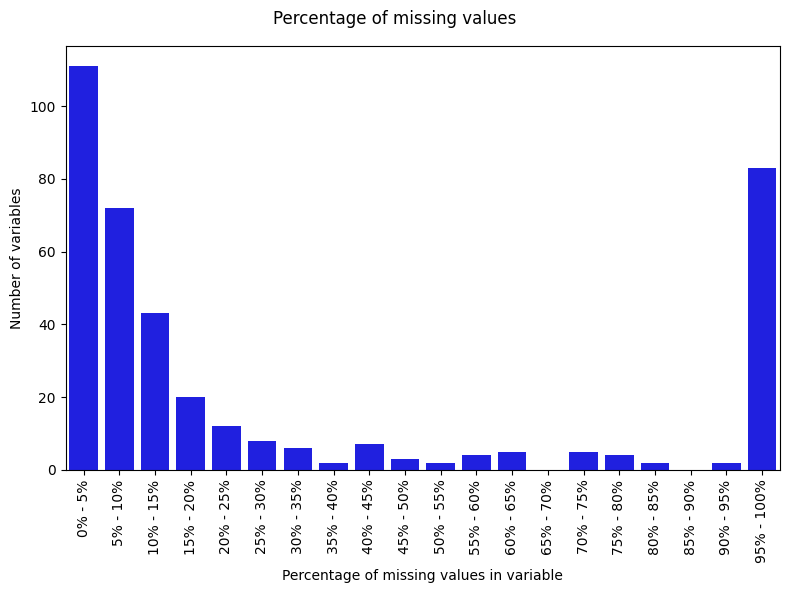

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.countplot(
    x=pd.cut(
        dataset.isna().sum() / len(dataset),
        bins=list(np.arange(0, 1.05, .05)),
        labels=[f'{i}% - {i+5}%' for i in range(0, 100, 5)]
    ),
    color='blue',
    ax=ax
)

ax.tick_params(axis='x', labelrotation=90)

ax.set_xlabel('Percentage of missing values in variable')
ax.set_ylabel('Number of variables')

plt.suptitle('Percentage of missing values')

plt.tight_layout();

In [16]:
# Preprocessing - remove variables with more than 50% missing values
dataset_preproc = dataset.copy()
dataset_preproc, train_set, val_set, test_set = preprocessor(
    temp_dataset = dataset_preproc,
    drop_subset = [
        'best_price_dynamics_y', 'price_dynamics_y', 'best_price_dynamics_in_q',
        'price_dynamics_y_in_q', 'inflation_yy_m', 'usd_pln', 'wig', 'wig_6m',
        'best_wig_dynamics_y', 'wig_dynamics_y', 'adj_best_price_dynamics_y',
        'adj_price_dynamics_y', 'adj_best_wig_dynamics_y', 'adj_wig_dynamics_y',
        'final_wig_dynamics', 'sold_in_q', 'final_price_dynamics',
        'interesting_investment', 'avg_price_earnings', 'quarter', 'company_code'
    ] + dataset_preproc.filter(regex='rank').columns.tolist(),
    treshold = .5
)

# Unpacking sets
X_train, y_reg_train = train_set
X_val, y_reg_val = val_set
X_test, y_reg_test = test_set

# Dataset exploration

The transformed training set has 286 numeric variables, 4 object variables and 13384 observations. Nearly 94% of the variables and 97% of the observations have missing values. There are no duplicated rows in the set.

The **final_price_dynamics** variable has a mean of 0.0093, while the median is -0.0166. 75% of the observations were less than 0.2509. The number of shares has an approximately symmetric and platykurtic distribution. The distribution of this variable also shows a peak for values equal to 0.5 - this is due to the fact that higher values have been capped at this level.

In [13]:
print('Basic information about the analysed dataset:')
X_train.info()
print('\nPercentage of features with missing values: '\
    f'{round(100 * X_train.isna().any().sum() / len(X_train.columns), 2)}%')
print('Percentage of features with more than 50% missing values: '\
    f'{round(100 * (X_train.isna().sum() > .5 * len(X_train)).sum() / len(X_train.columns), 2)}%')
print('Percentage of observations with missing values: '\
    f'{round(100 * X_train.isna().any(axis=1).sum() / len(X_train), 2)}%')
print('Percentage of missing values in regression target feature: '\
    f'{round(100 * y_reg_train.final_price_dynamics.isna().sum() / len(y_reg_train), 2)}%')
print('Percentage of duplicate rows: '\
    f'{round(100 * X_train.duplicated().sum() / len(X_train.columns), 2)}%')

Basic information about the analysed dataset:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13384 entries, 964 to 16260
Columns: 288 entries, price_dynamics_6m to price_avg_earnings_share_6Y
dtypes: float64(286), object(2)
memory usage: 29.5+ MB

Percentage of features with missing values: 93.75%
Percentage of features with more than 50% missing values: 0.0%
Percentage of observations with missing values: 96.94%
Percentage of missing values in regression target feature: 0.0%
Percentage of duplicate rows: 0.0%


In [14]:
print('Basic statistics of final_price_dynamics feature:')
y_reg_train.describe()

Basic statistics of final_price_dynamics feature:


final_price_dynamics
count            13384.0000
mean                 0.0093
std                  0.3199
min                 -0.7962
25%                 -0.2199
50%                 -0.0166
75%                  0.2509
max                  0.5000

In [15]:
print('Skewness of final_price_dynamics feature in training set: '\
    f'{y_reg_train.final_price_dynamics.skew().round(2)}')
print('Kurtosis of final_price_dynamics feature in training set: '\
    f'{y_reg_train.final_price_dynamics.kurtosis().round(2)}')

Skewness of final_price_dynamics feature in training set: 0.05
Kurtosis of final_price_dynamics feature in training set: -0.86


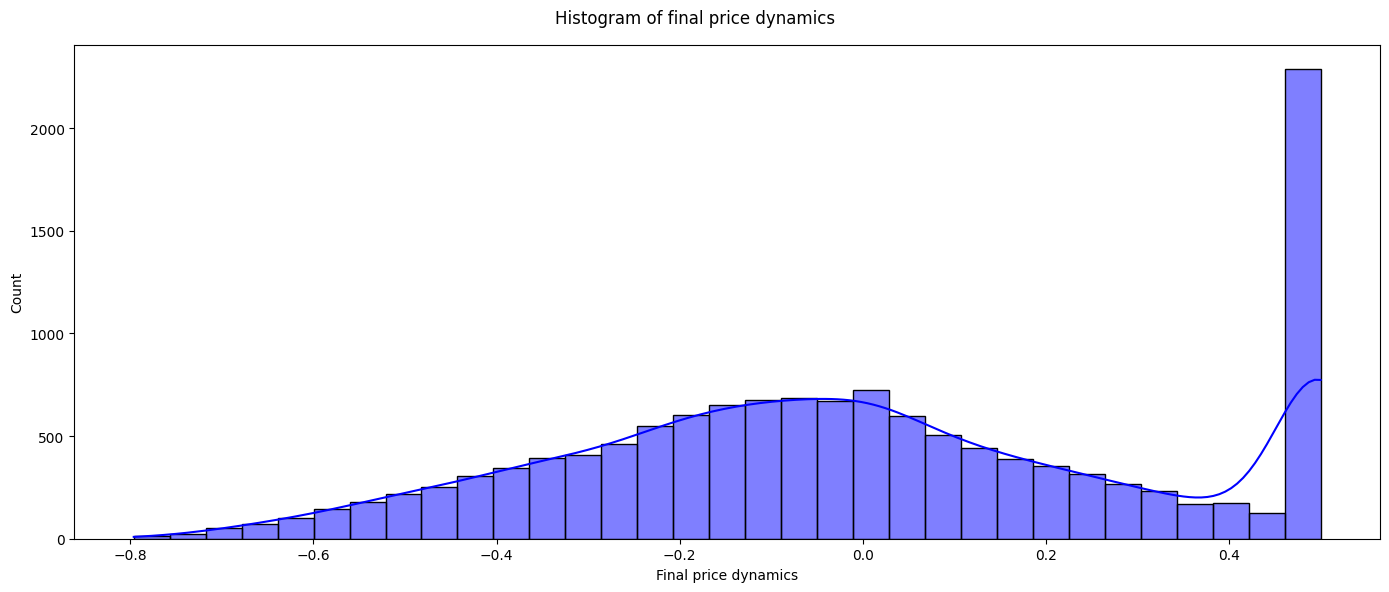

In [16]:
fig, ax = plt.subplots(figsize=(14, 6))

sns.histplot(
    x=y_reg_train.final_price_dynamics,
    color='blue',
    kde=True,
    ax=ax
)

ax.set_xlabel('Final price dynamics')
plt.suptitle('Histogram of final price dynamics')

plt.tight_layout();

# Feature engineering

## Imputing & encoding

In the first step, we will replace the missing values using the K-nearest neighbours method (with k = 100). We will follow this approach throughout the feature engineering and variable selection process, and then see if we can find a better method for replacing missing values for the chosen features. Missing indicators will be added to the dataset. Then the **country** and **industry** variables will be one-hot encoded, while the other categorical variables will be given the appropriate data type. The dataset thus transformed has 616 variables, 338 of which are categorical.

In [17]:
# Imputing & encoding

# Categorical data
cat_cols = [
    'dividend_1Y', 'pos_net_earnings_5Y', 'pos_net_earnings_4Y', 'pos_net_earnings_3Y',
    'pos_net_earnings_2Y', 'pos_net_earnings_1Y', 'country', 'industry', 'continuous_dividend',
    'continuous_price_growth'
]

# Scaling numerical data
train_means = X_train.drop(cat_cols, axis=1, errors='ignore').mean()
train_stds = X_train.drop(cat_cols, axis=1, errors='ignore').std()

X_train_scaled = (X_train.drop(cat_cols, axis=1, errors='ignore') - train_means) / train_stds
X_val_scaled = (X_val.drop(cat_cols, axis=1, errors='ignore') - train_means) / train_stds

X_train_scaled = pd.concat([X_train.filter(cat_cols), X_train_scaled], axis=1)
X_val_scaled = pd.concat([X_val.filter(cat_cols), X_val_scaled], axis=1)

imp_enc_pipe = ColumnTransformer(
    transformers=[
        (
            'knn_imputer',
            KNNImputer(n_neighbors=100, weights='distance', add_indicator=True),
            X_train_scaled.drop(cat_cols, axis=1).columns.to_list()
        ),
        (
            'oh_encoder',
            OneHotEncoder(handle_unknown='infrequent_if_exist'),
            ['country', 'industry']
        )
    ],
    remainder='passthrough'
)

X_train_proc = pd.DataFrame(
    imp_enc_pipe.fit_transform(X_train_scaled),
    index=X_train_scaled.index,
    columns=[col_name.split('__', 1)[1] for col_name in imp_enc_pipe.get_feature_names_out()]
)
X_val_proc = pd.DataFrame(
    imp_enc_pipe.transform(X_val_scaled),
    index=X_val_scaled.index,
    columns=[col_name.split('__', 1)[1] for col_name in imp_enc_pipe.get_feature_names_out()]
)

cat_cols_updated = [
    *cat_cols,
    *X_train_proc.filter(regex='country').columns.tolist(),
    *X_train_proc.filter(regex='industry').columns.tolist(),
    *X_train_proc.filter(regex='missingindicator').columns.tolist()
]

# Scale data back
X_train_proc = pd.concat(
    [
        X_train_proc.filter(cat_cols_updated),
        X_train_proc.drop(cat_cols_updated, axis=1, errors='ignore') * train_stds + train_means
    ],
    axis=1
)
X_val_proc = pd.concat(
    [
        X_val_proc.filter(cat_cols_updated),
        X_val_proc.drop(cat_cols_updated, axis=1, errors='ignore') * train_stds + train_means
    ],
    axis=1
)

# Converting dummy cols to category
dummy_cols = [
    'dividend_1Y', 'pos_net_earnings_5Y', 'pos_net_earnings_4Y', 'pos_net_earnings_3Y',
    'pos_net_earnings_2Y', 'pos_net_earnings_1Y'
] + X_train_proc.filter(
    regex='country'
).columns.tolist() + X_train_proc.filter(
    regex='industry'
).columns.tolist() + X_train_proc.filter(regex='missingindicator').columns.tolist()

X_train_proc[dummy_cols] = X_train_proc[dummy_cols].astype('category')
X_val_proc[dummy_cols] = X_val_proc[dummy_cols].astype('category')

# Converting 'continuous' to ordered category
for col in ['continuous_dividend', 'continuous_price_growth']:
    X_train_proc[col] = pd.Categorical(
        X_train_proc[col],
        categories=set(X_train_proc[col]),
        ordered=True
    )
    X_val_proc[col] = pd.Categorical(
        X_val_proc[col],
        categories=set(X_val_proc[col]),
        ordered=True
    )

# Change numeric features back to float type
num_cols = [
    col for col in X_train_proc.columns if col not in 
    dummy_cols + ['continuous_dividend', 'continuous_price_growth']
]
X_train_proc[num_cols] = X_train_proc[num_cols].astype('float64')
X_val_proc[num_cols] = X_val_proc[num_cols].astype('float64')

In [18]:
X_train_proc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13384 entries, 964 to 16260
Columns: 616 entries, dividend_1Y to price_avg_earnings_share_6Y
dtypes: category(338), float64(278)
memory usage: 32.8 MB


## Benchmark model

Extreme gradient boosting (XGB) built on the training set with default parameters will serve as a benchmark for subsequent regression models. The models will be evaluated using root mean squared error (RMSE) and mean absolute error (MAE). We will measure the quality of the prediction on both the training set and the validation set. After each transformation, we will check whether the quality of the model has improved over the benchmark model. The gurus' strategies generally used at most a few indicators - we will follow this pattern and use only the variables with the MI score greater than 0.05.

502 variables achieved a positive MI score, while only 4 of them achieved an MI score greater than 0.05: **number_of_shares**, **core_capital**, **price** and **supplementary_capital**. The RMSE on the training set was 0.2953, while on the validation set it was 0.3067 (difference: 0.0114). In contrast, MAE on the training set was 0.2449, while on the validation set it was 0.2563 (difference: 0.0114). In the next steps, we will try to modify the datasets in such a way as to reduce the value of the RMSE and MAE indicators, but at the same time keep the difference between the metrics on the training and validation sets at a reasonable level.

Number of features with MI score greater than 0: 502
Number of features with MI score greater than 0.05: 4

Features with top MI scores:
                       MI Scores
number_of_shares          0.0652
core_capital              0.0597
price                     0.0560
supplementary_capital     0.0541


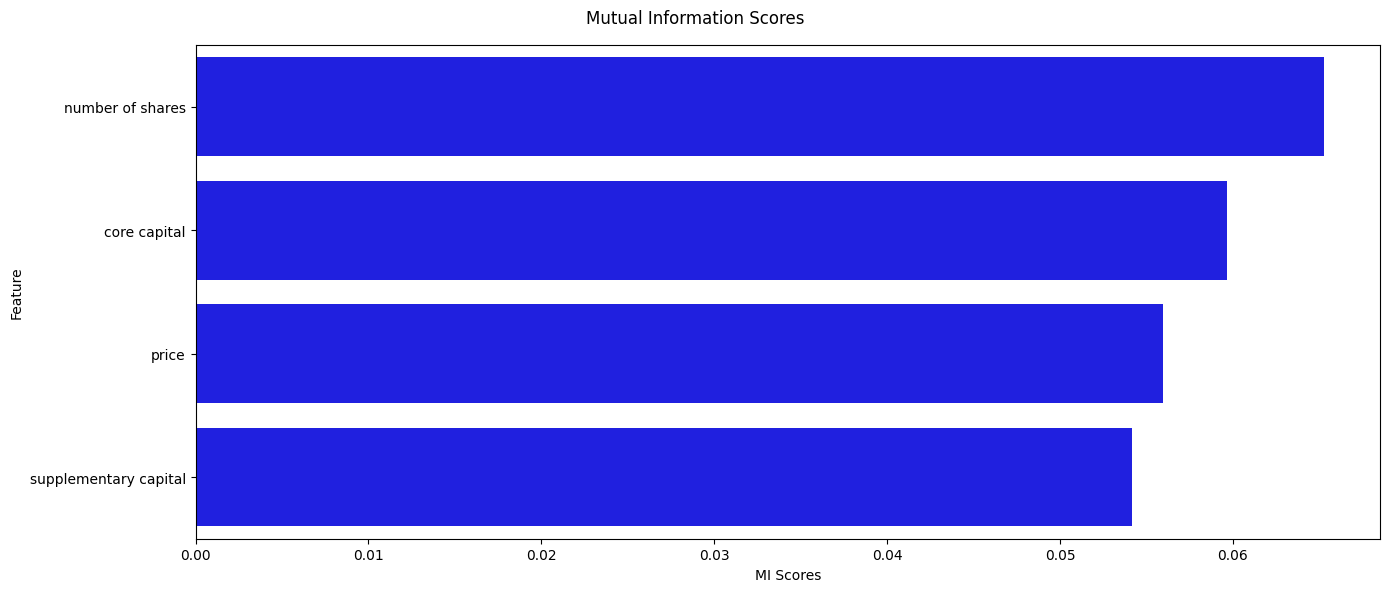

In [19]:
bench_mi = mi_scores(X_train_proc, y_reg_train)

In [20]:
high_bench_mi = bench_mi[bench_mi['MI Scores'] > .05]['MI Scores'].index.tolist()

xgb_simple(
    X_train_proc.filter(high_bench_mi), y_reg_train,
    X_val_proc.filter(high_bench_mi), y_reg_val,
    'Benchmark model'
)

Model's performance on training set
                  RMSE    MAE
Benchmark model 0.2953 0.2449

Model's performance on validation set
                  RMSE    MAE
Benchmark model 0.3067 0.2563

Difference in model's performance on validation and training sets
                  RMSE    MAE
Benchmark model 0.0114 0.0114


## New ratio variables

From the analysis of the gurus' strategies, we can conclude that the ratios used often referred to the share price (e.g. price to earnings ratio) and sometimes also to the number of shares (e.g. price to average earnings per share), EBIT, EBITDA, net earnings or sales revenues. We will try to use this knowledge to create new ratios:
- dividing the price by another indicator (*price_to_feature*),
- dividing an indicator by the number of shares (*feature_per_share*), EBIT (*feature_ebit*), EBITDA (*feature_ebitda*), net earnings (*feature_net_earnings*) and sales revenues (*feature_sales_revenues*).

Missing values will again be replaced by KNN imputer with 100 neighbours, in addition the missing indicators will be added.

The dataset thus transformed has 1183 categorical variables and 1328 numerical variables. The new dataset provided one new variable with MI scores above 0.05: **core_capital_per_share**. The RMSE on the new training set was 0.2918, while that on the validation set was 0.3028 (difference: 0.011). In contrast, MAE on the training set was 0.2418, and on the validation set was 0.2519 (difference: 0.0101). Adding the new variable not only improved the model's performance on both sets, but also reduced the differences between the metrics.

In [21]:
def ratio_features(source_set):
    """Function creating ratio variables"""

    invalid_cols = [
        *source_set.filter(regex='price').columns.tolist(),
        *source_set.filter(regex='share').columns.tolist(),
        *source_set.filter(regex='ebit').columns.tolist(),
        *source_set.filter(regex='ebitda').columns.tolist(),
        *source_set.filter(regex='net_earnings').columns.tolist(),
        *source_set.filter(regex='sales_revenues').columns.tolist(),
        *source_set.select_dtypes('category').columns.tolist()
    ]
    invalid_cols = set(invalid_cols)

    temp_set = {}

    for col in source_set:
        if col not in invalid_cols:
            temp_set['price_to_' + col] = source_set.price / source_set[col]
            temp_set[col + '_per_share'] = source_set[col] / source_set.number_of_shares
            temp_set[col + '_ebit'] = source_set[col] / source_set.ebit
            temp_set[col + '_ebitda'] = source_set[col] / source_set.ebitda
            temp_set[col + '_net_earnings'] = source_set[col] / source_set.net_earnings
            temp_set[col + '_sales_revenues'] = source_set[col] / source_set.sales_revenues

    temp_set = pd.concat([source_set, pd.DataFrame(temp_set, index=source_set.index)], axis=1)
    temp_set = temp_set.loc[:, ~temp_set.columns.duplicated()]

    # Replace inf with nan
    temp_set = temp_set.replace([np.inf, -np.inf], np.nan)

    return temp_set

X_train_ratio = ratio_features(X_train_proc)
X_val_ratio = ratio_features(X_val_proc)

# Scaling numerical data
train_means = X_train_ratio.drop(cat_cols_updated, axis=1, errors='ignore').mean()
train_stds = X_train_ratio.drop(cat_cols_updated, axis=1, errors='ignore').std()

X_train_scaled = (
    X_train_ratio.drop(cat_cols_updated, axis=1, errors='ignore') - train_means) / train_stds
X_val_scaled = (
    X_val_ratio.drop(cat_cols_updated, axis=1, errors='ignore') - train_means) / train_stds

X_train_scaled = pd.concat([X_train_ratio.filter(cat_cols_updated), X_train_scaled], axis=1)
X_val_scaled = pd.concat([X_val_ratio.filter(cat_cols_updated), X_val_scaled], axis=1)

# Imputing
imp_pipe = ColumnTransformer(
    transformers=[
        (
            'knn_imputer',
            KNNImputer(n_neighbors=100, weights='distance', add_indicator=True),
            X_train_scaled.drop(cat_cols_updated, axis=1, errors='ignore').columns.to_list()
        )
    ],
    remainder='passthrough'
)

X_train_ratio = pd.DataFrame(
    imp_pipe.fit_transform(X_train_scaled),
    index=X_train_scaled.index,
    columns=[col_name.split('__', 1)[1] for col_name in imp_pipe.get_feature_names_out()]
)
X_val_ratio = pd.DataFrame(
    imp_pipe.transform(X_val_scaled),
    index=X_val_scaled.index,
    columns=[col_name.split('__', 1)[1] for col_name in imp_pipe.get_feature_names_out()]
)

cat_cols_updated = list(
    set(cat_cols_updated + X_train_ratio.filter(regex='missingindicator').columns.tolist())
)

# Scale data back
X_train_ratio = pd.concat(
    [
        X_train_ratio.filter(cat_cols_updated),
        X_train_ratio.drop(cat_cols_updated, axis=1, errors='ignore') * train_stds + train_means
    ],
    axis=1
)
X_val_ratio = pd.concat(
    [
        X_val_ratio.filter(cat_cols_updated),
        X_val_ratio.drop(cat_cols_updated, axis=1, errors='ignore') * train_stds + train_means
    ],
    axis=1
)

# Converting dummy cols to category
dummy_cols = [
    'dividend_1Y', 'pos_net_earnings_5Y', 'pos_net_earnings_4Y', 'pos_net_earnings_3Y',
    'pos_net_earnings_2Y', 'pos_net_earnings_1Y'
] + X_train_ratio.filter(
    regex='country'
).columns.tolist() + X_train_ratio.filter(
    regex='industry'
).columns.tolist() + X_train_ratio.filter(regex='missingindicator').columns.tolist()

X_train_ratio[dummy_cols] = X_train_ratio[dummy_cols].astype('category')
X_val_ratio[dummy_cols] = X_val_ratio[dummy_cols].astype('category')

# Converting 'continuous' to ordered category
for col in ['continuous_dividend', 'continuous_price_growth']:
    X_train_ratio[col] = pd.Categorical(
        X_train_ratio[col],
        categories=set(X_train_ratio[col]),
        ordered=True
    )
    X_val_ratio[col] = pd.Categorical(
        X_val_ratio[col],
        categories=set(X_val_ratio[col]),
        ordered=True
    )

# Removing some wrong features like roce_ebit 
# (ROCE is core capital * EBIT, so ROCE / EBIT is simply core capital)
X_train_ratio.drop(
    ['capitalization_per_share', 'price_to_capitalization', 'roce_ebit'], axis=1, inplace=True
)
X_val_ratio.drop(
    ['capitalization_per_share', 'price_to_capitalization', 'roce_ebit'], axis=1, inplace=True
)

# Change numeric features back to float type
num_cols = [
    col for col in X_train_ratio.columns if col not in 
    dummy_cols + ['continuous_dividend', 'continuous_price_growth']
]
X_train_ratio[num_cols] = X_train_ratio[num_cols].astype('float64')
X_val_ratio[num_cols] = X_val_ratio[num_cols].astype('float64')

In [22]:
X_train_ratio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13384 entries, 964 to 16260
Columns: 2511 entries, missingindicator_fixed_assets_held_for_sale_ebitda to long_term_liabilities_net_working_capital_sales_revenues
dtypes: category(1183), float64(1328)
memory usage: 150.9 MB


Number of features with MI score greater than 0: 2000
Number of features with MI score greater than 0.05: 5

Features with top MI scores:
                        MI Scores
core_capital_per_share     0.0743
number_of_shares           0.0649
core_capital               0.0576
price                      0.0545
supplementary_capital      0.0534


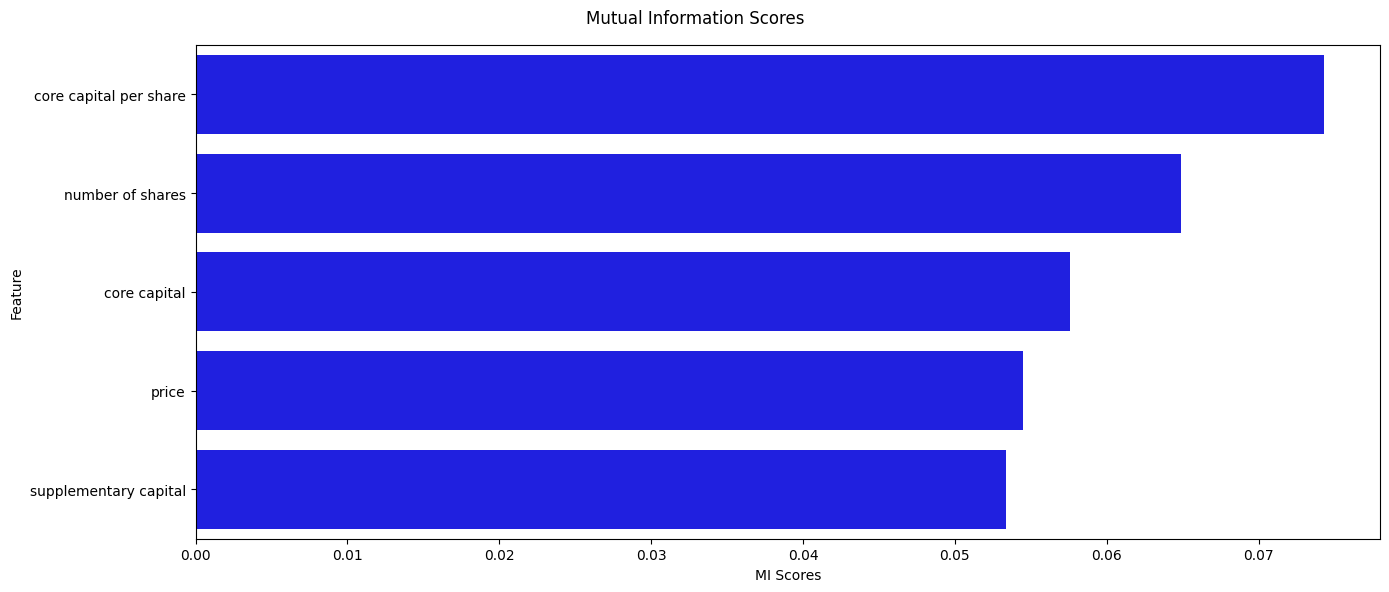

In [23]:
ratio_mi = mi_scores(X_train_ratio, y_reg_train)

In [24]:
high_ratio_mi = ratio_mi[ratio_mi['MI Scores'] > .05]['MI Scores'].index.tolist()

xgb_simple(
    X_train_ratio.filter(high_ratio_mi), y_reg_train,
    X_val_ratio.filter(high_ratio_mi), y_reg_val,
    'New ratios'
)

Model's performance on training set
             RMSE    MAE
New ratios 0.2918 0.2418

Model's performance on validation set
             RMSE    MAE
New ratios 0.3028 0.2519

Difference in model's performance on validation and training sets
             RMSE    MAE
New ratios 0.0110 0.0101


## Piotroski F-Score

The Piotroski F-Score is a discrete score ranging from zero to nine that reflects the 9 criteria used to determine the strength of a company's financial position. These criteria are:
- positive ROA,
- positive cash flow from operational activities,
- increase in ROA y/y,
- cash flow from operational activities higher than total assets,
- decrease in long-term debt y/y,
- increase in current liquidity y/y,
- number of shares less than or the same as a year earlier,
- increase in sales profit margin y/y,
- increase in total assets turnover y/y.

The higher the score, the better the company's rating. We will add 9 binary variables taking 1 if the company meets the criterion at a given time (0 otherwise) and an ordinal variable describing the Piotroski F-Score. However, these variables achieved a relatively low MI score (for Piotroski F-Score: 0.0058). On the other hand, another variable with MI score above 0.05 has joined the lead: **supplementary_capital_per_share**. Adding it to the model slightly improved its performance.

In [25]:
def piotroski_f_score(source_set):
    """Function adding Piotroski F-Score"""

    temp_set = {
        'piotroski_I':pd.Categorical(np.where(source_set.roa > 0, 1, 0)),
        'piotroski_II':pd.Categorical(
            np.where(source_set.cash_flows_from_operational_activities > 0, 1, 0)
        ),
        'piotroski_III':pd.Categorical(np.where(source_set.roa_yy > 0, 1, 0)),
        'piotroski_IV':pd.Categorical(
            np.where(
                source_set.cash_flows_from_operational_activities > source_set.total_assets, 1, 0
            )
        ),
        'piotroski_V':pd.Categorical(np.where(source_set.long_term_debt_yy < 0, 1, 0)),
        'piotroski_VI':pd.Categorical(np.where(source_set.current_liquidity_yy > 0, 1, 0)),
        'piotroski_VII':pd.Categorical(np.where(source_set.number_of_shares_yy <= 0, 1, 0)),
        'piotroski_VIII':pd.Categorical(np.where(source_set.sales_earnings_margin_yy > 0, 1, 0)),
        'piotroski_IX':pd.Categorical(np.where(source_set.total_assets_turnover_yy > 0, 1, 0))
    }

    temp_set = pd.DataFrame(temp_set, index=source_set.index)
    temp_set['piotroski_f_score'] = pd.Categorical(
        temp_set[temp_set.columns.tolist()].sum(axis=1),
        ordered=True,
        categories=range(10)
    )

    temp_set = pd.concat([source_set, temp_set], axis=1)

    return temp_set

X_train_pfs = piotroski_f_score(X_train_ratio)
X_val_pfs = piotroski_f_score(X_val_ratio)

Number of features with MI score greater than 0: 2001
Number of features with MI score greater than 0.05: 6

Features with top MI scores:
                                 MI Scores
core_capital_per_share              0.0724
core_capital                        0.0613
number_of_shares                    0.0613
price                               0.0566
supplementary_capital               0.0542
supplementary_capital_per_share     0.0505


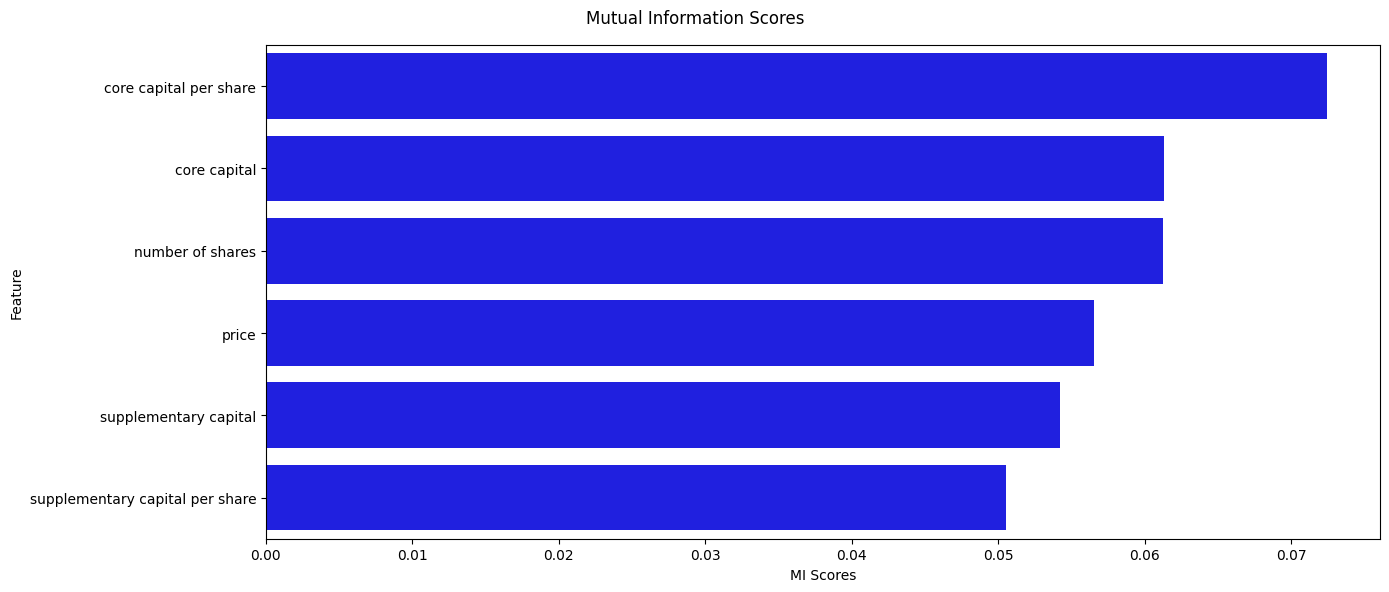

In [26]:
pfs_mi = mi_scores(X_train_pfs, y_reg_train)

In [27]:
print('MI scores of Piotroski F-Score variables')
pfs_mi.filter(regex='piotroski', axis=0)

MI scores of Piotroski F-Score variables


MI Scores
piotroski_I           0.0146
piotroski_VII         0.0116
piotroski_f_score     0.0058
piotroski_IV          0.0038
piotroski_VIII        0.0034
piotroski_III         0.0034
piotroski_II          0.0024
piotroski_VI          0.0023
piotroski_IX          0.0002
piotroski_V           0.0000

In [28]:
high_pfs_mi = pfs_mi[pfs_mi['MI Scores'] > .05].index.tolist()

xgb_simple(
    X_train_pfs.filter(high_pfs_mi), y_reg_train,
    X_val_pfs.filter(high_pfs_mi), y_reg_val,
    'Piotroski F-Score'
)

Model's performance on training set
                    RMSE    MAE
Piotroski F-Score 0.2915 0.2415

Model's performance on validation set
                    RMSE    MAE
Piotroski F-Score 0.3023 0.2516

Difference in model's performance on validation and training sets
                    RMSE    MAE
Piotroski F-Score 0.0108 0.0101


## Altman Z-Score

Another indicator is the Altman Z-Score, which assesses a company's financial health and its risk of bankruptcy. It is calculated according to the formula:

*Altman Z-Score = 1.2 * X_1 + 1.4 * X_2 + 3.3 * X_3 + 0.6 * X_4 + X_5*

where:
- X_1: share of working capital in total assets,
- X_2: (net earnings - value of dividends paid) / total assets,
- X_3: EBIT / total assets,
- X_4: capitalization / total liabilities,
- X_5: sales revenues / total assets.

The higher the value of the index, the better the company's performance. As with the Piotroski F-Score, the new variables have a relatively low MI score (for Altman Z-Score: 0.0401). At the same time, the list of variables with the highest MI score has not changed.

In [29]:
def altman_z_score(source_set):
    """Function adding Altman Z-Score"""

    temp_set = {
        'altman_I':source_set.share_of_working_capital_in_assets,
        'altman_II':(source_set.net_earnings - source_set.dividend_val) / source_set.total_assets,
        'altman_III':source_set.ebit / source_set.total_assets,
        'altman_IV':source_set.capitalization / source_set.total_liabilities,
        'altman_V':source_set.sales_revenues / source_set.total_assets
    }

    temp_set = pd.DataFrame(temp_set, index=source_set.index)
    temp_set['altman_z_score'] = (
        1.2 * temp_set.altman_I + 1.4 * temp_set.altman_II + 3.3 * temp_set.altman_III
        + .6 * temp_set.altman_IV + temp_set.altman_V
    )

    temp_set = pd.concat([source_set, temp_set], axis=1)

    return temp_set

X_train_azs = altman_z_score(X_train_pfs)
X_val_azs = altman_z_score(X_val_pfs)

Number of features with MI score greater than 0: 1996
Number of features with MI score greater than 0.05: 6

Features with top MI scores:
                                 MI Scores
core_capital_per_share              0.0762
number_of_shares                    0.0653
core_capital                        0.0569
supplementary_capital               0.0533
price                               0.0523
supplementary_capital_per_share     0.0509


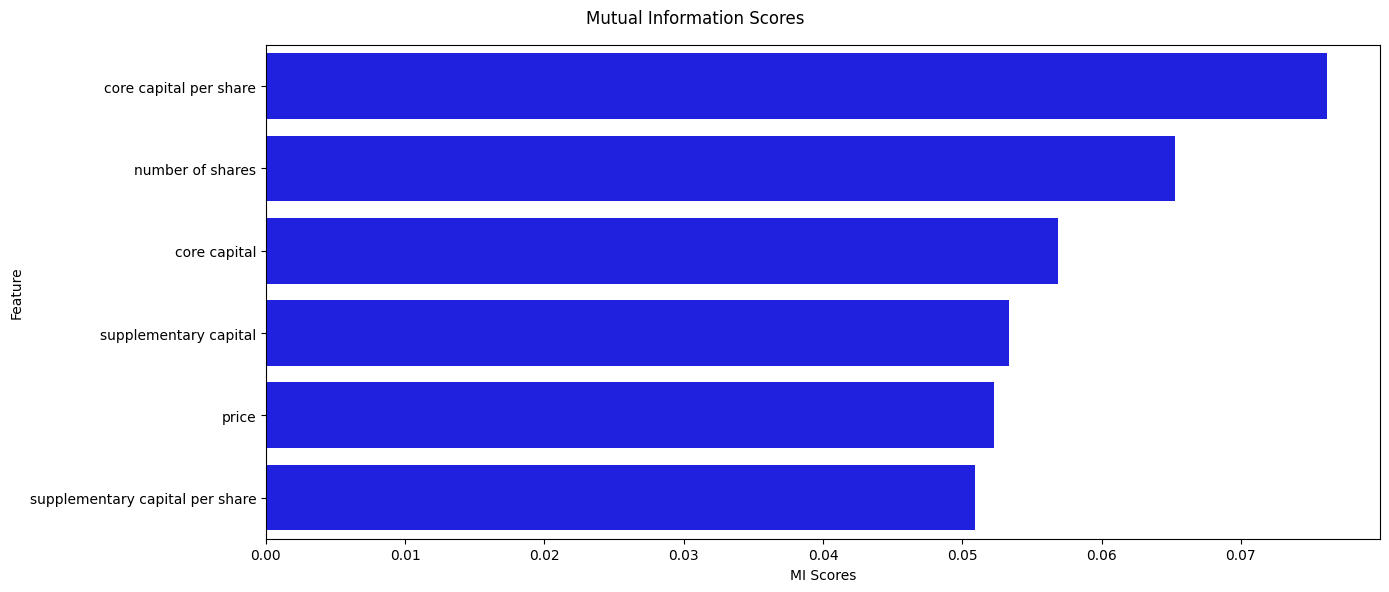

In [30]:
azs_mi = mi_scores(X_train_azs, y_reg_train)

In [31]:
print('MI scores of Altman Z-Score variables')
azs_mi.filter(regex='altman', axis=0)

MI scores of Altman Z-Score variables


MI Scores
altman_z_score     0.0401
altman_IV          0.0384
altman_III         0.0217
altman_I           0.0197
altman_V           0.0191
altman_II          0.0121

In [32]:
high_azs_mi = azs_mi[azs_mi['MI Scores'] > .05].index.tolist()

xgb_simple(
    X_train_azs.filter(high_azs_mi), y_reg_train,
    X_val_azs.filter(high_azs_mi), y_reg_val,
    'Altman Z-Score'
)

Model's performance on training set
                 RMSE    MAE
Altman Z-Score 0.2915 0.2415

Model's performance on validation set
                 RMSE    MAE
Altman Z-Score 0.3023 0.2516

Difference in model's performance on validation and training sets
                 RMSE    MAE
Altman Z-Score 0.0108 0.0101


## Average value & mode per country and industry

Although the variables **country** and **industry** have been encoded, we will restore them for a moment to calculate the average value of each numeric variable and the most frequent value of each categorical variable. The new dataset has 3579 categorical and 4002 numerical features. Again, the list of variables with the highest MI score has not changed.

In [33]:
def grouping_country_industry(source_set, base_set):
    """Function adding average value & mode per country and industry"""

    temp_set = {}

    for col in source_set:
        if source_set[col].dtype in ['float64']:
            temp_set['avg_' + col + '_per_country'] = source_set.groupby(
                base_set.country)[col].transform('mean')
            temp_set['avg_' + col + '_per_industry'] = source_set.groupby(
                base_set.industry)[col].transform('mean')
        else:
            temp_set['mode_' + col + '_per_country'] = pd.Categorical(
                source_set.groupby(base_set.country)[col].transform(lambda x: x.mode()[0]),
                ordered=True
            )
            temp_set['mode_' + col + '_per_industry'] = pd.Categorical(
                source_set.groupby(base_set.industry)[col].transform(lambda x: x.mode()[0]),
                ordered=True
            )

    temp_set = pd.DataFrame(temp_set, index=source_set.index)

    temp_set = pd.concat([source_set, temp_set], axis=1)

    return temp_set

X_train_group = grouping_country_industry(X_train_azs, X_train)
X_val_group = grouping_country_industry(X_val_azs, X_val)

In [34]:
X_train_group.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13384 entries, 964 to 16260
Columns: 7581 entries, missingindicator_fixed_assets_held_for_sale_ebitda to avg_altman_z_score_per_industry
dtypes: category(3579), float64(4002)
memory usage: 454.8 MB


Number of features with MI score greater than 0: 5856
Number of features with MI score greater than 0.05: 6

Features with top MI scores:
                                 MI Scores
core_capital_per_share              0.0716
number_of_shares                    0.0601
core_capital                        0.0575
price                               0.0561
supplementary_capital               0.0545
supplementary_capital_per_share     0.0510


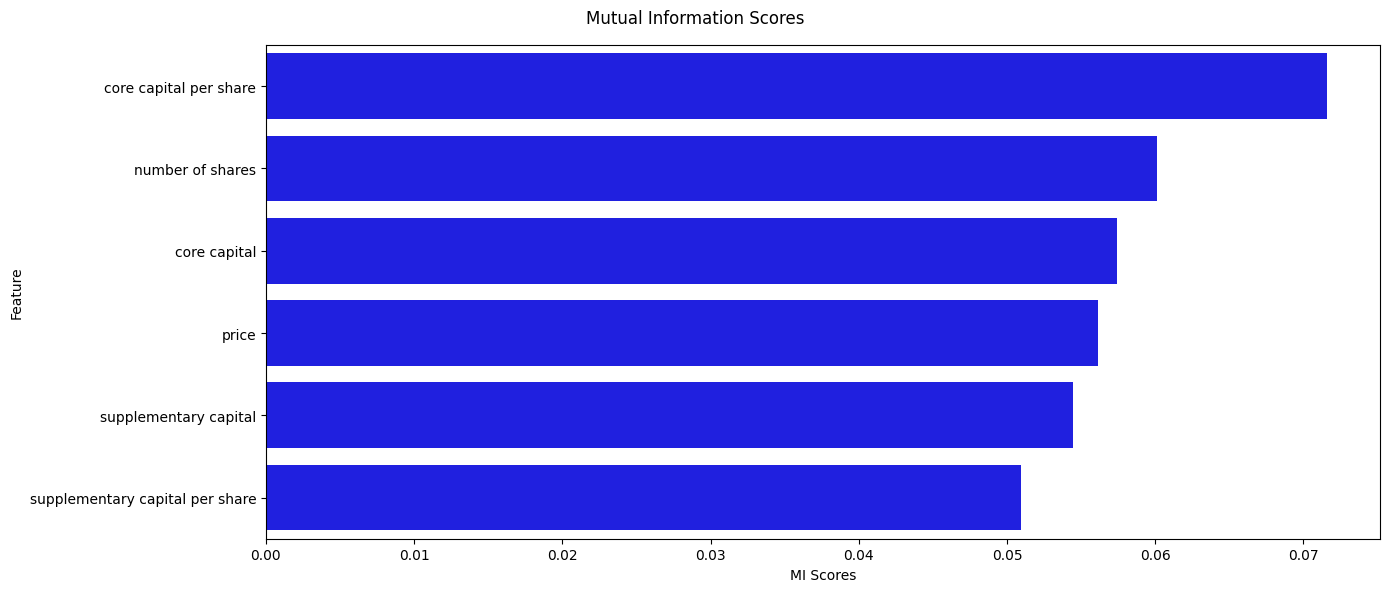

In [35]:
group_mi = mi_scores(X_train_group, y_reg_train)

In [36]:
high_group_mi = group_mi[group_mi['MI Scores'] > .05].index.tolist()

xgb_simple(
    X_train_group.filter(high_group_mi), y_reg_train,
    X_val_group.filter(high_group_mi), y_reg_val,
    'Group transformations'
)

Model's performance on training set
                        RMSE    MAE
Group transformations 0.2915 0.2415

Model's performance on validation set
                        RMSE    MAE
Group transformations 0.3023 0.2516

Difference in model's performance on validation and training sets
                        RMSE    MAE
Group transformations 0.0108 0.0101


## Outliers

The training set includes 3989 variables with outliers (i.e., observations whose absolute value is lower than first quartile minus 1.5 * interquartile range (IQR) or greater than third quartile plus 1.5 * IQR). The largest number of such observations is in the **avg_general_financial_situation_index_yy_ebitda_per_industry** variable - 6159, which accounts for 46% of the set. Removing observations with outliers would significantly reduce their number.

The alternative is capping outliers in both sets (with capping values coming from the training set in both cases!). In the set obtained in this way, six variables had MI scores higher than 0.05: this time the **price** variable did not catch the top spot, for that, the variable **capitalization** appeared there. However, this change (as well as capping) worsened the model's performance.

In [37]:
# Outliers in the training set
quartile_1 = X_train_group.select_dtypes('float64').quantile(.25)
quartile_3 = X_train_group.select_dtypes('float64').quantile(.75)
iqr = quartile_3 - quartile_1

lower_lim = quartile_1 - 1.5 * iqr
upper_lim =  quartile_3 + 1.5 * iqr

outlier_cols = {
    col:sum(X_train_group[col] < lower_lim[col]) + sum(X_train_group[col] > upper_lim[col])
    for col in X_train_group.select_dtypes('float64')
}
outlier_cols = {col:out_num for col, out_num in outlier_cols.items() if out_num > 0}
print(f'Number of features with outliers: {len(outlier_cols)}')
print('Top 10 features with the highest number of outliers:')
sorted(outlier_cols.items(), key=lambda x:x[1], reverse=True)[:10]

Number of features with outliers: 3989
Top 10 features with the highest number of outliers:


[('avg_general_financial_situation_index_yy_ebitda_per_industry', 6159),
 ('avg_sustainability_of_the_financing_structure_yy_sales_revenues_per_industry',
  6147),
 ('avg_ii_degree_of_coverage_yy_sales_revenues_per_industry', 6081),
 ('avg_i_degree_of_coverage_per_share_per_industry', 5974),
 ('avg_short_term_investment_yy_ebitda_per_industry', 5786),
 ('avg_coverage_of_fixed_assets_with_fixed_capital_sales_revenues_per_industry',
  5776),
 ('avg_total_cash_flows_sales_revenues_per_industry', 5719),
 ('avg_ii_degree_of_coverage_per_industry', 5669),
 ('avg_i_degree_of_coverage_yy_sales_revenues_per_industry', 5586),
 ('avg_roa_sales_revenues_per_industry', 5567)]

In [38]:
# Capping outliers
X_train_cap = X_train_group.copy()
X_val_cap = X_val_group.copy()

for col in X_train_cap.select_dtypes('float64'):
    X_train_cap.loc[(X_train_cap[col] < lower_lim[col]), col] = lower_lim[col]
    X_train_cap.loc[(X_train_cap[col] > upper_lim[col]), col] = upper_lim[col]
    X_val_cap.loc[(X_val_cap[col] < lower_lim[col]), col] = lower_lim[col]
    X_val_cap.loc[(X_val_cap[col] > upper_lim[col]), col] = upper_lim[col]

Number of features with MI score greater than 0: 5317
Number of features with MI score greater than 0.05: 6

Features with top MI scores:
                                 MI Scores
number_of_shares                    0.0647
core_capital                        0.0603
supplementary_capital               0.0556
capitalization                      0.0536
core_capital_per_share              0.0525
supplementary_capital_per_share     0.0509


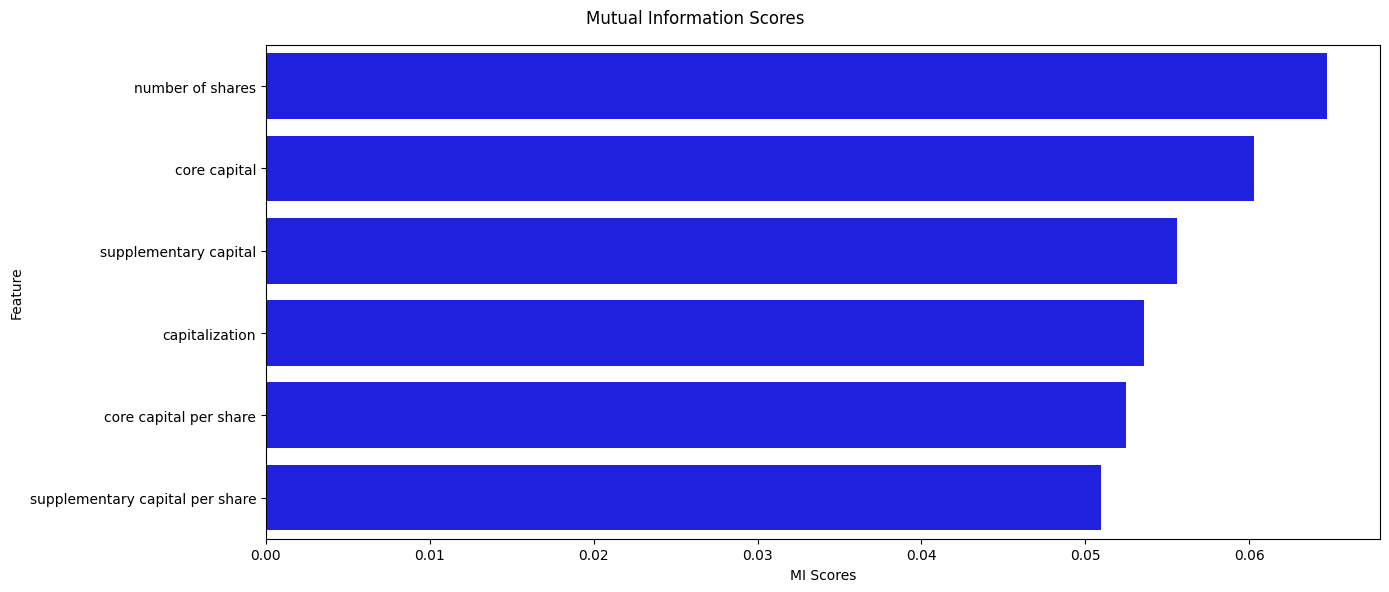

In [39]:
capped_mi = mi_scores(X_train_cap, y_reg_train)

In [40]:
high_capped_mi = capped_mi[capped_mi['MI Scores'] > .05].index.tolist()

xgb_simple(
    X_train_cap.filter(high_capped_mi), y_reg_train,
    X_val_cap.filter(high_capped_mi), y_reg_val,
    'Capped outliers'
)

Model's performance on training set
                  RMSE    MAE
Capped outliers 0.2930 0.2426

Model's performance on validation set
                  RMSE    MAE
Capped outliers 0.3039 0.2530

Difference in model's performance on validation and training sets
                  RMSE    MAE
Capped outliers 0.0109 0.0104


## Yeo–Johnson transformation

The 3696 variables in the training set had a skewness of less than -1 or greater than 1. A natural solution for features having right or left skewed distribution would be a transformation using a logarithm or exponential function, however, in the analyzed dataset, many values are not positive. Instead, we will use the Yeo-Johnson transformation, which has no such restrictions.

Of the variables obtained in this way, five achieved MI scores above 0.05: **pt_number_of_shares**, **pt_core_capital_per_share**, **pt_core_capital**, **pt_supplementary_capital**, **pt_supplementary_capital_per_share**. As you can see, all of them were created on the basis of variables that already had a relatively high MI score. However, adding them to the model significantly worsened its performance.

In [42]:
print('Number of numerical features with skewness lower than -1 or greater than 1: '\
    f'{sum(abs(X_train_group.skew(numeric_only=True)) > 1)}')
print(f'Number of highly right-skewed features: {sum(X_train_group.skew(numeric_only=True) > 1)}')
print(f'Number of highly left-skewed features: {sum(X_train_group.skew(numeric_only=True) < -1)}')

Number of numerical features with skewness lower than -1 or greater than 1: 3696
Number of highly right-skewed features: 2230
Number of highly left-skewed features: 1466


In [119]:
# Transformation
X_train_pt = pd.concat(
    [
        X_train_group,
        pd.DataFrame(
            power_transform(X_train_group.select_dtypes('float64')),
            columns=['pt_' + col for col in X_train_group.select_dtypes('float64').columns],
            index=X_train_group.index
        )
    ],
    axis=1
)

X_val_pt = pd.concat(
    [
        X_val_group,
        pd.DataFrame(
            power_transform(X_val_group.select_dtypes('float64')),
            columns=['pt_' + col for col in X_val_group.select_dtypes('float64').columns],
            index=X_val_group.index
        )
    ],
    axis=1
)

Number of features with MI score greater than 0: 9667
Number of features with MI score greater than 0.05: 11

Features with top MI scores:
                                    MI Scores
pt_number_of_shares                    0.0858
pt_core_capital_per_share              0.0784
core_capital_per_share                 0.0732
pt_core_capital                        0.0691
number_of_shares                       0.0598
core_capital                           0.0586
price                                  0.0560
pt_supplementary_capital               0.0547
pt_supplementary_capital_per_share     0.0534
supplementary_capital                  0.0530
supplementary_capital_per_share        0.0507


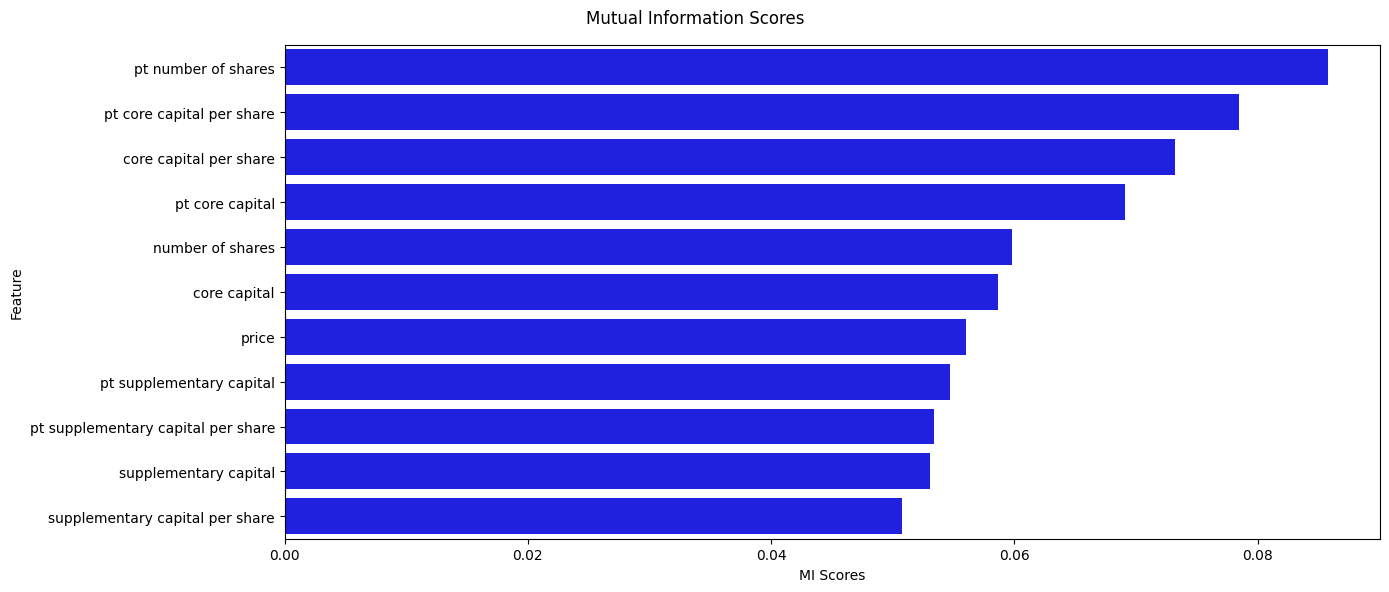

In [120]:
pt_mi = mi_scores(X_train_pt, y_reg_train)

In [121]:
high_pt_mi = pt_mi[pt_mi['MI Scores'] > .05].index.tolist()

xgb_simple(
    X_train_pt.filter(high_pt_mi), y_reg_train,
    X_val_pt.filter(high_pt_mi), y_reg_val,
    'Power transformation'
)

Model's performance on training set
                       RMSE    MAE
Power transformation 0.2915 0.2415

Model's performance on validation set
                       RMSE    MAE
Power transformation 0.3121 0.2602

Difference in model's performance on validation and training sets
                       RMSE    MAE
Power transformation 0.0206 0.0187


Alternatively, we can limit ourselves to only the transformed variables (and the **price** variable), however, this approach further degrades the model's performance.

In [122]:
high_pt_mi = pt_mi.filter(
    [
        'pt_number_of_shares', 'pt_core_capital_per_share', 'pt_core_capital',
        'pt_supplementary_capital', 'pt_supplementary_capital_per_share', 'price'
    ],
    axis=0
).index.tolist()

xgb_simple(
    X_train_pt.filter(high_pt_mi), y_reg_train,
    X_val_pt.filter(high_pt_mi), y_reg_val,
    'Power transformation'
)

Model's performance on training set
                       RMSE    MAE
Power transformation 0.2926 0.2423

Model's performance on validation set
                       RMSE    MAE
Power transformation 0.3131 0.2614

Difference in model's performance on validation and training sets
                       RMSE    MAE
Power transformation 0.0205 0.0191


# Models' evaluation

For models using variables with MI greater than 0.05, the only significant improvement in model quality occurred when new ratio variables were added. Subsequent transformations did not add variables with relatively high MI - the exception being the version of the sets with variables created using the Yeo-Johnson transformation, which significantly worsened the performance of the models on the validation set. It should also be noted that models using variables with MI greater than 0.05 managed to maintain very similar performance on the training and validation sets.

The guru's strategies generally used at most a few indicators - we will follow this pattern and use only variables that achieved an MI score greater than 0.05 (not counting variables obtained using the Yeo-Johnson transformation). These are:
- **capitalization**
- **core_capital**
- **core_capital_per_share**
- **number_of_shares**
- **price**
- **supplementary_capital**
- **supplementary_capital_per_share**

In [18]:
# List of chosen features
final_features = [
    'capitalization', 'core_capital', 'core_capital_per_share', 'number_of_shares',
    'price', 'supplementary_capital', 'supplementary_capital_per_share'
]

# One step back

Before we move on to model tuning, let's take a step back - by limiting ourselves to only a selected seven variables, will we be able to modify them enough to achieve better model performance?

The starting point will be the imputation of missing values. We performed it twice - at the very beginning of the analysis, and then after the new ratios were created. Many of the divisors had values equal to 0, resulting in missing values in the ratios. This time our only divisor is the number of shares, which has only values greater than zero, so the imputation will occur only once and will only apply to the **core_capital** and **supplementary_capital** variables (they have 654 and 683 observations with missing values, respectively). In addition to addressing the missing values, we will also check the outliers and try to deal with the distribution of the selected variables (in each case it is right-skewed and leptokurtic).

In [124]:
print('Basic statistics of final features:')
X_train.filter(final_features).describe()

Basic statistics of final features:


capitalization  core_capital  number_of_shares      price  \
count        13384.0000    12730.0000        13384.0000 13384.0000   
mean    2331919443.0933   195765.1262     92021760.6798    60.9437   
std    12357502488.9381  1223822.8272    568778494.1699   407.5009   
min          23712.0000        1.0000        52631.0000     0.0200   
25%       48138500.0000     2747.0000      6364523.0000     3.7500   
50%      146295002.5200    10000.0000     15381861.0000    10.4150   
75%      607540628.7150    36360.0000     43412140.0000    28.5000   
max   350154532729.4000 19165000.0000  17340641302.0000 14330.0000   

       supplementary_capital  
count             12701.0000  
mean             379855.8469  
std             1750942.6212  
min            -1352460.0000  
25%               17885.0000  
50%               57512.0000  
75%              156178.0000  
max            28061704.0000

In [125]:
print('Number of observations with missing values in final features:')
X_train.filter(final_features).isna().sum()

Number of observations with missing values in final features:


capitalization             0
core_capital             654
number_of_shares           0
price                      0
supplementary_capital    683
dtype: int64

In [126]:
print('Skewness of final features:')
X_train.filter(final_features).skew()

Skewness of final features:


capitalization          15.8246
core_capital            11.3054
number_of_shares        23.5468
price                   20.1978
supplementary_capital    9.5189
dtype: float64

In [177]:
print('Kurtosis of final features:')
X_train.filter(final_features).kurtosis()

Kurtosis of final features:


capitalization          340.9857
core_capital            148.4588
number_of_shares        640.1196
price                   482.3246
supplementary_capital   104.5849
dtype: float64

Let's first prepare a benchmark model based on the training set before any changes. The RMSE and MAE on the validation set are 0.3031 and 0.2524, respectively, while the differences from the training set are 0.0114 and 0.0111, respectively.

In [127]:
# Benchmark dataset
X_train_bench = X_train.filter(final_features)
X_val_bench = X_val.filter(final_features)

# Additional features
X_train_bench[
    'core_capital_per_share'
] = X_train_bench.core_capital / X_train_bench.number_of_shares
X_train_bench[
    'supplementary_capital_per_share'
] = X_train_bench.supplementary_capital / X_train_bench.number_of_shares

X_val_bench[
    'core_capital_per_share'
] = X_val_bench.core_capital / X_val_bench.number_of_shares
X_val_bench[
    'supplementary_capital_per_share'
] = X_val_bench.supplementary_capital / X_val_bench.number_of_shares

X_train_bench = X_train_bench.replace([np.inf, -np.inf], np.nan)
X_val_bench = X_val_bench.replace([np.inf, -np.inf], np.nan)


xgb_simple(
    X_train_bench, y_reg_train,
    X_val_bench, y_reg_val,
    'New benchmark model'
)

Model's performance on training set
                      RMSE    MAE
New benchmark model 0.2917 0.2413

Model's performance on validation set
                      RMSE    MAE
New benchmark model 0.3031 0.2524

Difference in model's performance on validation and training sets
                      RMSE    MAE
New benchmark model 0.0114 0.0111


## Imputation

Removing the missing values lowers these indices (to 0.302 and 0.2513), but at the same time slightly increases the the differences in RMSE and MAE between training and validation sets (0.0129 and 0.0121, respectively).

In [19]:
# Drop NAs
X_train_drop = X_train.filter(final_features).dropna()
X_val_drop = X_val.filter(final_features).dropna()

X_train_drop['core_capital_per_share'] = X_train_drop.core_capital / X_train_drop.number_of_shares
X_train_drop[
    'supplementary_capital_per_share'
] = X_train_drop.supplementary_capital / X_train_drop.number_of_shares

X_val_drop['core_capital_per_share'] = X_val_drop.core_capital / X_val_drop.number_of_shares
X_val_drop[
    'supplementary_capital_per_share'
] = X_val_drop.supplementary_capital / X_val_drop.number_of_shares

y_reg_train_drop = y_reg_train[y_reg_train.index.isin(X_train_drop.index)]
y_reg_val_drop = y_reg_val[y_reg_val.index.isin(X_val_drop.index)]

xgb_simple(
    X_train_drop, y_reg_train_drop,
    X_val_drop, y_reg_val_drop,
    'Drop NAs'
)

Model's performance on training set
           RMSE    MAE
Drop NAs 0.2891 0.2392

Model's performance on validation set
           RMSE    MAE
Drop NAs 0.3020 0.2513

Difference in model's performance on validation and training sets
           RMSE    MAE
Drop NAs 0.0129 0.0121


Replacing missing values with averages only slightly improves model performance. The same is true when we use medians, however, such a solution increases the difference in metrics between training and validation sets.

In [25]:
# Fill NAs with mean
X_train_mean = X_train.filter(final_features)
X_val_mean = X_val.filter(final_features)

mean_imputer = SimpleImputer(strategy='mean')
col_names = X_train_mean.columns.tolist()

X_train_mean = pd.DataFrame(
    mean_imputer.fit_transform(X_train_mean),
    index=X_train_mean.index,
    columns=col_names
)
X_val_mean = pd.DataFrame(
    mean_imputer.transform(X_val_mean),
    index=X_val_mean.index,
    columns=col_names
)

X_train_mean['core_capital_per_share'] = X_train_mean.core_capital / X_train_mean.number_of_shares
X_train_mean[
    'supplementary_capital_per_share'
] = X_train_mean.supplementary_capital / X_train_mean.number_of_shares

X_val_mean['core_capital_per_share'] = X_val_mean.core_capital / X_val_mean.number_of_shares
X_val_mean[
    'supplementary_capital_per_share'
] = X_val_mean.supplementary_capital / X_val_mean.number_of_shares

xgb_simple(
    X_train_mean, y_reg_train,
    X_val_mean, y_reg_val,
    'NAs filled with mean'
)

Model's performance on training set
                       RMSE    MAE
NAs filled with mean 0.2926 0.2421

Model's performance on validation set
                       RMSE    MAE
NAs filled with mean 0.3026 0.2524

Difference in model's performance on validation and training sets
                       RMSE    MAE
NAs filled with mean 0.0100 0.0103


In [26]:
# Fill NAs with median
X_train_median = X_train.filter(final_features)
X_val_median = X_val.filter(final_features)

median_imputer = SimpleImputer(strategy='median')
col_names = X_train_median.columns.tolist()

X_train_median = pd.DataFrame(
    median_imputer.fit_transform(X_train_median),
    index=X_train_median.index,
    columns=col_names
)
X_val_median = pd.DataFrame(
    median_imputer.transform(X_val_median),
    index=X_val_median.index,
    columns=col_names
)

X_train_median['core_capital_per_share'] = X_train_median.core_capital / X_train_median.number_of_shares
X_train_median[
    'supplementary_capital_per_share'
] = X_train_median.supplementary_capital / X_train_median.number_of_shares

X_val_median['core_capital_per_share'] = X_val_median.core_capital / X_val_median.number_of_shares
X_val_median[
    'supplementary_capital_per_share'
] = X_val_median.supplementary_capital / X_val_median.number_of_shares

xgb_simple(
    X_train_median, y_reg_train,
    X_val_median, y_reg_val,
    'NAs filled with median'
)

Model's performance on training set
                         RMSE    MAE
NAs filled with median 0.2902 0.2395

Model's performance on validation set
                         RMSE    MAE
NAs filled with median 0.3027 0.2514

Difference in model's performance on validation and training sets
                         RMSE    MAE
NAs filled with median 0.0125 0.0119


Recall from an earlier analysis that we used KNN imputer with 100 neighbors. However, it turns out that the number of neighbors selected does not affect the model's performance. Imputation using the KNN method yielded some improvement over the benchmark model and achieved the lowest difference in metrics between the training and validation sets. Nevertheless, the best results came from simply removing missing values.

In [18]:
# Categorical data
cat_cols = [
    'dividend_1Y', 'pos_net_earnings_5Y', 'pos_net_earnings_4Y', 'pos_net_earnings_3Y',
    'pos_net_earnings_2Y', 'pos_net_earnings_1Y', 'country', 'industry', 'continuous_dividend',
    'continuous_price_growth'
]

# Scaling numerical data
train_means = X_train.drop(cat_cols, axis=1, errors='ignore').mean()
train_stds = X_train.drop(cat_cols, axis=1, errors='ignore').std()

X_train_scaled = (X_train.drop(cat_cols, axis=1, errors='ignore') - train_means) / train_stds
X_val_scaled = (X_val.drop(cat_cols, axis=1, errors='ignore') - train_means) / train_stds

X_train_scaled = pd.concat([X_train.filter(cat_cols), X_train_scaled], axis=1)
X_val_scaled = pd.concat([X_val.filter(cat_cols), X_val_scaled], axis=1)

# Results dict
knn_results_dict = {
    'Training RMSE':[],
    'Training MAE':[],
    'Validation RMSE':[],
    'Validation MAE':[],
    'Difference in RMSE':[],
    'Difference in MAE':[]
}

for n in range(5, 1005, 5):
    # Imputation
    imputer = ColumnTransformer(
        transformers=[
            (
                'imputer_num',
                KNNImputer(n_neighbors=n, weights='distance'),
                ['core_capital', 'supplementary_capital']
            )
        ],
        remainder='passthrough'
    )

    # Impute NAs
    X_train_knn = pd.DataFrame(
        imputer.fit_transform(X_train_scaled),
        index=X_train_scaled.index,
        columns=[col_name.split('__', 1)[1] for col_name in imputer.get_feature_names_out()]
    )
    X_val_knn = pd.DataFrame(
        imputer.transform(X_val_scaled),
        index=X_val_scaled.index,
        columns=[col_name.split('__', 1)[1] for col_name in imputer.get_feature_names_out()]
    )

    # Scale data back
    X_train_knn = pd.concat(
        [
            X_train_knn.filter(cat_cols),
            X_train_knn.drop(cat_cols, axis=1, errors='ignore') * train_stds + train_means
        ],
        axis=1
    )
    X_val_knn = pd.concat(
        [
            X_val_knn.filter(cat_cols),
            X_val_knn.drop(cat_cols, axis=1, errors='ignore') * train_stds + train_means
        ],
        axis=1
    )

    # Filter sets
    X_train_knn = X_train_knn.filter(final_features)
    X_val_knn = X_val_knn.filter(final_features)

    # Add ratios
    for x_set in [X_train_knn, X_val_knn]:
        x_set['core_capital_per_share'] = x_set.core_capital / x_set.number_of_shares
        x_set[
            'supplementary_capital_per_share'
        ] = x_set.supplementary_capital / x_set.number_of_shares

    # Change numeric features back to float type
    X_train_knn = X_train_knn.astype('float64')
    X_val_knn = X_val_knn.astype('float64')
    
    # XGB
    train_metrics, val_metrics, diff_metrics = xgb_results(
        X_train_knn, y_reg_train,
        X_val_knn, y_reg_val
    )

    knn_results_dict['Training RMSE'].append(train_metrics.iloc[0, 0])
    knn_results_dict['Training MAE'].append(train_metrics.iloc[0, 1])
    knn_results_dict['Validation RMSE'].append(val_metrics.iloc[0, 0])
    knn_results_dict['Validation MAE'].append(val_metrics.iloc[0, 1])
    knn_results_dict['Difference in RMSE'].append(diff_metrics.iloc[0, 0])
    knn_results_dict['Difference in MAE'].append(diff_metrics.iloc[0, 1])

knn_results = pd.DataFrame(knn_results_dict, index = range(5, 1005, 5))

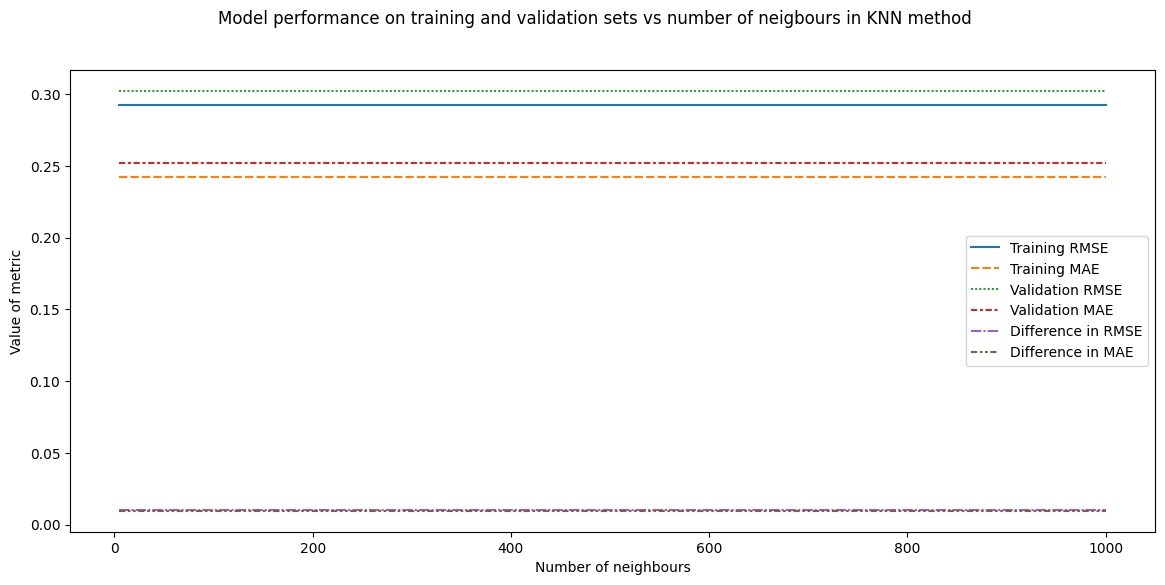

In [19]:
fig, ax = plt.subplots(figsize=(14, 6))

sns.lineplot(
    data=knn_results,
    ax=ax
)

ax.set_xlabel('Number of neighbours')
ax.set_ylabel('Value of metric')
plt.suptitle(
    'Model performance on training and validation sets vs number of neigbours in KNN method'
)

plt.tight_layout;

In [23]:
print('Model\'s performance after KNN imputation')
knn_results.iloc[0, :]

Model's performance after KNN imputation


Training RMSE        0.2924
Training MAE         0.2420
Validation RMSE      0.3023
Validation MAE       0.2517
Difference in RMSE   0.0099
Difference in MAE    0.0097
Name: 5, dtype: float64

## Outliers

In the training set obtained in this way, each of the variables has outliers - the largest number in **core_capital_per_share**. In total, there are 5105 observations in the entire training set, which we can consider outliers - about 38% of the set.

In [27]:
# Outliers in the training set
quartile_1 = X_train_drop.quantile(.25)
quartile_3 = X_train_drop.quantile(.75)
iqr = quartile_3 - quartile_1

lower_lim = quartile_1 - 1.5 * iqr
upper_lim =  quartile_3 + 1.5 * iqr

outlier_cols = {
    col:sum(X_train_drop[col] < lower_lim[col]) + sum(X_train_drop[col] > upper_lim[col])
    for col in X_train_drop
}
outlier_cols = {col:out_num for col, out_num in outlier_cols.items() if out_num > 0}

X_train_ok = X_train_drop[(X_train_drop > lower_lim) & (X_train_drop < upper_lim)].dropna()
X_val_ok = X_val_drop[(X_val_drop > lower_lim) & (X_val_drop < upper_lim)].dropna()

print(f'Number of observations with outliers in any feature: {len(X_train_drop) - len(X_train_ok)}')
print('Number of outliers in each feature:')
sorted(outlier_cols.items(), key=lambda x:x[1], reverse=True)

Number of observations with outliers in any feature: 5105
Number of outliers in each feature:


[('core_capital_per_share', 1997),
 ('capitalization', 1821),
 ('core_capital', 1804),
 ('price', 1652),
 ('supplementary_capital', 1551),
 ('number_of_shares', 1454),
 ('supplementary_capital_per_share', 1249)]

Interestingly, neither the removal nor the capping of outliers resulted in any improvement in the model. Similarly, replacing outliers with missing values and then filling them with the mean / median or imputing them using the KNN method does not improve the model's performance. Outliers will thus remain in the dataset.

In [28]:
X_train_drop_outliers = X_train_drop[X_train_drop.index.isin(X_train_ok.index)]
X_val_drop_outliers = X_val_drop[X_val_drop.index.isin(X_val_ok.index)]

y_reg_train_drop_outliers = y_reg_train[y_reg_train.index.isin(X_train_drop_outliers.index)]
y_reg_val_drop_outliers = y_reg_val[y_reg_val.index.isin(X_val_drop_outliers.index)]

xgb_simple(
    X_train_drop_outliers, y_reg_train_drop_outliers,
    X_val_drop_outliers, y_reg_val_drop_outliers,
    'Outliers dropped'
)

Model's performance on training set
                   RMSE    MAE
Outliers dropped 0.2838 0.2369

Model's performance on validation set
                   RMSE    MAE
Outliers dropped 0.3021 0.2534

Difference in model's performance on validation and training sets
                   RMSE    MAE
Outliers dropped 0.0183 0.0165


In [30]:
X_train_cap_outliers = X_train_drop.copy()
X_val_cap_outliers = X_val_drop.copy()

# Adding cap
for data_set in [X_train_cap_outliers, X_val_cap_outliers]:
    for col in data_set:
        data_set.loc[(data_set[col] < lower_lim[col]), col] = lower_lim[col]
        data_set.loc[(data_set[col] > upper_lim[col]), col] = upper_lim[col]

xgb_simple(
    X_train_cap_outliers, y_reg_train_drop,
    X_val_cap_outliers, y_reg_val_drop,
    'Outliers capped'
)

Model's performance on training set
                  RMSE    MAE
Outliers capped 0.2901 0.2402

Model's performance on validation set
                  RMSE    MAE
Outliers capped 0.3035 0.2524

Difference in model's performance on validation and training sets
                  RMSE    MAE
Outliers capped 0.0134 0.0122


In [33]:
X_train_outliers_na = X_train_drop.copy()
X_val_outliers_na = X_val_drop.copy()

# Replacing outliers with NAs
for data_set in [X_train_outliers_na, X_val_outliers_na]:
    for col in data_set:
        data_set.loc[(data_set[col] < lower_lim[col]), col] = np.nan
        data_set.loc[(data_set[col] > upper_lim[col]), col] = np.nan

In [36]:
# Fill NAs with mean

mean_imputer = SimpleImputer(strategy='mean')
col_names = X_train_outliers_na.columns.tolist()

X_train_outliers_mean = pd.DataFrame(
    mean_imputer.fit_transform(X_train_outliers_na),
    index=X_train_outliers_na.index,
    columns=col_names
)
X_val_outliers_mean = pd.DataFrame(
    mean_imputer.transform(X_val_outliers_na),
    index=X_val_outliers_na.index,
    columns=col_names
)

xgb_simple(
    X_train_outliers_mean, y_reg_train_drop,
    X_val_outliers_mean, y_reg_val_drop,
    'Outliers replaced by mean'
)

Model's performance on training set
                            RMSE    MAE
Outliers replaced by mean 0.2893 0.2394

Model's performance on validation set
                            RMSE    MAE
Outliers replaced by mean 0.3037 0.2519

Difference in model's performance on validation and training sets
                            RMSE    MAE
Outliers replaced by mean 0.0144 0.0125


In [37]:
# Fill NAs with median

median_imputer = SimpleImputer(strategy='median')
col_names = X_train_outliers_na.columns.tolist()

X_train_outliers_median = pd.DataFrame(
    median_imputer.fit_transform(X_train_outliers_na),
    index=X_train_outliers_na.index,
    columns=col_names
)
X_val_outliers_median = pd.DataFrame(
    median_imputer.transform(X_val_outliers_na),
    index=X_val_outliers_na.index,
    columns=col_names
)

xgb_simple(
    X_train_outliers_median, y_reg_train_drop,
    X_val_outliers_median, y_reg_val_drop,
    'Outliers replaced by median'
)

Model's performance on training set
                              RMSE    MAE
Outliers replaced by median 0.2915 0.2412

Model's performance on validation set
                              RMSE    MAE
Outliers replaced by median 0.3045 0.2530

Difference in model's performance on validation and training sets
                              RMSE    MAE
Outliers replaced by median 0.0130 0.0118


In [90]:
# Categorical data
cat_cols = [
    'dividend_1Y', 'pos_net_earnings_5Y', 'pos_net_earnings_4Y', 'pos_net_earnings_3Y',
    'pos_net_earnings_2Y', 'pos_net_earnings_1Y', 'country', 'industry', 'continuous_dividend',
    'continuous_price_growth'
]

# Add data to old dataset
X_train_outliers_knn = pd.concat(
    [
        X_train.drop(
            final_features, axis=1, errors='ignore')[X_train.index.isin(X_train_outliers_na.index)],
        X_train_outliers_na
    ],
    axis=1
)

X_val_outliers_knn = pd.concat(
    [
        X_val.drop(
            final_features, axis=1, errors='ignore')[X_val.index.isin(X_val_outliers_na.index)],
        X_val_outliers_na
    ],
    axis=1
)

# Scaling numerical data
train_means = X_train_outliers_knn.drop(cat_cols, axis=1, errors='ignore').mean()
train_stds = X_val_outliers_knn.drop(cat_cols, axis=1, errors='ignore').std()

X_train_scaled = (
    X_train_outliers_knn.drop(cat_cols, axis=1, errors='ignore') - train_means) / train_stds
X_val_scaled = (
    X_val_outliers_knn.drop(cat_cols, axis=1, errors='ignore') - train_means) / train_stds

X_train_scaled = pd.concat(
    [
        X_train.filter(cat_cols)[X_train.index.isin(X_train_outliers_na.index)],
        X_train_scaled
    ],
    axis=1
)
X_val_scaled = pd.concat(
    [
        X_val.filter(cat_cols)[X_val.index.isin(X_val_outliers_na.index)],
        X_val_scaled
    ],
    axis=1
)

# Imputation
imputer = ColumnTransformer(
    transformers=[
        (
            'imputer_num',
            KNNImputer(n_neighbors=100, weights='distance'),
            final_features
        )
    ],
    remainder='passthrough'
)

# Impute NAs
X_train_outliers_knn = pd.DataFrame(
    imputer.fit_transform(X_train_scaled),
    index=X_train_scaled.index,
    columns=[col_name.split('__', 1)[1] for col_name in imputer.get_feature_names_out()]
)
X_val_outliers_knn = pd.DataFrame(
    imputer.transform(X_val_scaled),
    index=X_val_scaled.index,
    columns=[col_name.split('__', 1)[1] for col_name in imputer.get_feature_names_out()]
)

# Scale data back
X_train_outliers_knn = X_train_outliers_knn.drop(
    cat_cols, axis=1, errors='ignore') * train_stds + train_means
X_val_outliers_knn = X_val_outliers_knn.drop(
    cat_cols, axis=1, errors='ignore') * train_stds + train_means

# Filter sets
X_train_outliers_knn = X_train_outliers_knn.filter(final_features)
X_val_outliers_knn = X_val_outliers_knn.filter(final_features)

# Change numeric features back to float type
X_train_outliers_knn = X_train_outliers_knn.astype('float64')
X_val_outliers_knn = X_val_outliers_knn.astype('float64')

xgb_simple(
    X_train_outliers_knn, y_reg_train_drop,
    X_val_outliers_knn, y_reg_val_drop,
    'Outliers imputed by KNN'
)

Model's performance on training set
                          RMSE    MAE
Outliers imputed by KNN 0.2917 0.2415

Model's performance on validation set
                          RMSE    MAE
Outliers imputed by KNN 0.3072 0.2550

Difference in model's performance on validation and training sets
                          RMSE    MAE
Outliers imputed by KNN 0.0155 0.0135


## Yeo-Johnson transformation

Removing observations with missing values, in addition to improving the quality of the model, also lowered the skewness and kurtosis in the **capitalization**, **number_of_shares** and **price** variables, although they are still relatively high. All variables have a right-skewed and leptokurtic distribution. Only the variables **supplementary_capital** and **supplementary_capital_per_share** have negative values.

In [96]:
print('Basic statistics of final features (after removing NAs):')
X_train_drop.describe()

Basic statistics of final features (after removing NAs):


capitalization  core_capital  number_of_shares      price  \
count        12701.0000    12701.0000        12701.0000 12701.0000   
mean    1366413102.0077   196197.0060     64195094.0022    58.6845   
std     5459525796.3585  1225185.6569    202264810.2001   416.2817   
min          23712.0000        1.0000        52631.0000     0.0200   
25%       46589425.0000     2795.0000      6118550.0000     3.6200   
50%      135877489.7000    10000.0000     14461991.0000    10.0000   
75%      505766760.0000    36360.0000     38400000.0000    25.7000   
max   101142074692.0000 19165000.0000   2750874900.0000 14330.0000   

       supplementary_capital  core_capital_per_share  \
count             12701.0000              12701.0000   
mean             379855.8469                  0.0037   
std             1750942.6212                  0.0166   
min            -1352460.0000                  0.0000   
25%               17885.0000                  0.0001   
50%               57512.0000                  0.0010   
75%              156178.0000                  0.0020   
max            28061704.0000                  0.6131   

       supplementary_capital_per_share  
count                       12701.0000  
mean                            0.0156  
std                             0.0739  
min                            -0.0122  
25%                             0.0014  
50%                             0.0040  
75%                             0.0101  
max                             2.0551

In [94]:
print('Skewness of final features (after removing NAs):')
X_train_drop.skew()

Skewness of final features (after removing NAs):


capitalization                     7.9650
core_capital                      11.2924
number_of_shares                   7.0684
price                             19.9625
supplementary_capital              9.5189
core_capital_per_share            12.7146
supplementary_capital_per_share   15.3680
dtype: float64

In [95]:
print('Kurtosis of final features (after removing NAs):')
X_train_drop.kurtosis()

Kurtosis of final features (after removing NAs):


capitalization                     81.5322
core_capital                      148.1145
number_of_shares                   61.3302
price                             467.0122
supplementary_capital             104.5849
core_capital_per_share            237.2422
supplementary_capital_per_share   301.4533
dtype: float64

Again, we will use the Yeo-Johnson transformation - however, the variables transformed in this way reduce the quality of the model somewhat.

In [98]:
# Power transformation
pt = PowerTransformer()
X_train_pt = pd.DataFrame(
    pt.fit_transform(X_train_drop),
    columns=['pt_' + col for col in X_train_drop.columns],
    index=X_train_drop.index
)
X_val_pt  = pd.DataFrame(
    pt.transform(X_val_drop),
    columns=['pt_' + col for col in X_val_drop.columns],
    index=X_val_drop.index
)

xgb_simple(
    X_train_pt, y_reg_train_drop,
    X_val_pt, y_reg_val_drop,
    'Yeo-Johnson transformation'
)

Model's performance on training set
                             RMSE    MAE
Yeo-Johnson transformation 0.2877 0.2381

Model's performance on validation set
                             RMSE    MAE
Yeo-Johnson transformation 0.3030 0.2521

Difference in model's performance on validation and training sets
                             RMSE    MAE
Yeo-Johnson transformation 0.0153 0.0140


## Final dataset

The only transformation that improved the quality of the model was the removal of observations with missing values. The following function summarizes the entire dataset creation process so far:
- loading the source data,
- preprocessing and splitting into training, validation and test sets,
- removing missing values in selected variables,
- adding **core_capital_per_share** and **supplementary_capital_per_share** variables,
- scaling the data.

In [3]:
# Final dataset

def final_transformation():
    """Final transformation of datasets"""

    # Dataset loading (the newest full dataset)
    dataset = pd.read_csv(
        max(
            glob.glob(os.getcwd().replace('analysis', '') + 'data\\full_datasets\\*.csv'),
            key = os.path.getctime
        ),
        index_col=False,
        low_memory=False
    )

    # List of chosen features
    final_features = [
        'capitalization', 'core_capital', 'core_capital_per_share', 'number_of_shares',
        'price', 'supplementary_capital', 'supplementary_capital_per_share'
    ]

    def preprocessor(temp_dataset, drop_subset, treshold):
        """All initial transformations"""
        # temp_dataset = copy of the original dataset
        # non_num_columns = non-numeric columns
        # div_columns = dividend columns
        # drop_subset = target and auxilliary columns to be removed from X sets
        # treshold = % of observations with missing values

        # Fixing bug resulting from dividing the features
        # In some values dot is replaced by comma and whole column gets wrong data type
        temp_dataset.replace(',', '.', regex=True, inplace=True)
        subset = temp_dataset.columns[~temp_dataset.columns.isin([
            'quarter', 'company_code', 'best_price_dynamics_in_q',
            'price_dynamics_y_in_q', 'country', 'industry'
        ])]
        temp_dataset[subset] = temp_dataset[subset].astype(float)
        temp_dataset = temp_dataset.replace([np.inf, -np.inf], np.nan)

        # Fill NAs in dividend data with 0 (NA here means that dividend most probably wasn't paid)
        # The same for positive net earnings in previous years
        cat_cols = [
            'dividend_1Y', 'continuous_dividend', 'pos_net_earnings_5Y', 'pos_net_earnings_4Y',
            'pos_net_earnings_3Y', 'pos_net_earnings_2Y', 'pos_net_earnings_1Y',
            'continuous_price_growth'
        ]
        for col in cat_cols:
            temp_dataset[col] = temp_dataset[col].fillna(0)

        # There is a wrong price reported by company FMG in Q4 2018. The company reported price at
        # 0.15 - however, in neighbouring quarters it was 30.93 and 28. Checking this information
        # on another stock exchange website (stooq.pl) confirms that this is an incorrect value
        # - this company was listed on the stock exchange only once in Q4 2018, but with a price of
        # 29, which is a better approximation of the real price.
        idx = temp_dataset.loc[
            np.where(
                (temp_dataset.company_code == 'FMG')
                & (temp_dataset.quarter == '2018/Q4')
            )
        ].index[0]
        temp_dataset.loc[idx, 'price'] = 29
        temp_dataset.loc[idx, 'best_price_dynamics_y'] = (28 - 29) / 29
        temp_dataset.loc[idx, 'price_dynamics_y'] = (9 - 29) / 29

        # Adding new features
        dynamics = {
            'adj_best_price_dynamics_y':
            81 * temp_dataset.best_price_dynamics_y / temp_dataset.inflation_yy_m,
            'adj_price_dynamics_y':81 * temp_dataset.price_dynamics_y / temp_dataset.inflation_yy_m,
            'adj_best_wig_dynamics_y':
            81 * temp_dataset.best_wig_dynamics_y / temp_dataset.inflation_yy_m,
            'adj_wig_dynamics_y':81 * temp_dataset.wig_dynamics_y / temp_dataset.inflation_yy_m,
            'final_price_dynamics':pd.Series(
                np.where(
                    81 * temp_dataset.best_price_dynamics_y / temp_dataset.inflation_yy_m > .5,
                    .5, 81 * temp_dataset.price_dynamics_y / temp_dataset.inflation_yy_m
                )
            ),
            'final_wig_dynamics':pd.Series(
                np.where(
                    81 * temp_dataset.best_wig_dynamics_y / temp_dataset.inflation_yy_m > .5,
                    .5, 81 * temp_dataset.wig_dynamics_y / temp_dataset.inflation_yy_m
                )
            ),
            'sold_in_q':pd.Series(np.where(
                81 * temp_dataset.best_price_dynamics_y / temp_dataset.inflation_yy_m > .5,
                temp_dataset.best_price_dynamics_in_q,
                temp_dataset.price_dynamics_y_in_q
            ))
        }
        dynamics = pd.DataFrame(dynamics)

        dynamics['interesting_investment'] = pd.Categorical(
            pd.Series(
                np.where(
                    dynamics.final_price_dynamics == .5,
                    'Yes', np.where(
                        dynamics.final_price_dynamics >= 0,
                        'Maybe', 'No'
                    )
                )
            ),
            categories=['No', 'Maybe', 'Yes'],
            ordered=True
        )

        temp_dataset = pd.concat(
            [temp_dataset, pd.DataFrame(dynamics, index=temp_dataset.index)],
            axis=1
        )

        # Removing variables with more than x% missing values
        temp_dataset.dropna(thresh=len(temp_dataset) * treshold, axis=1, inplace=True)

        # Train test split
        # Target features kept in X_set for train-validation split
        X_set = temp_dataset.copy()
        y_set = temp_dataset.filter(['interesting_investment'])

        X_train, X_test, y_train, y_test = train_test_split(
            X_set, y_set, test_size=.15, random_state=1234,
            shuffle=True, stratify=y_set.interesting_investment
        )

        # Creating X_test_set
        y_reg_test = X_test.filter(['final_price_dynamics'])
        X_test.drop(drop_subset, axis=1, errors='ignore', inplace=True)

        test_set = (X_test, y_reg_test)

        # Train validation split
        X_set = X_train.copy()
        y_set = X_train.filter(['interesting_investment'])

        X_train, X_val, y_train, y_val = train_test_split(
            X_set, y_set, test_size=.15, random_state=1234,
            shuffle=True, stratify=y_set.interesting_investment
        )

        # Creating X_train_set
        y_reg_train = X_train.filter(['final_price_dynamics'])
        X_train.drop(drop_subset, axis=1, errors='ignore', inplace=True)

        train_set = (X_train, y_reg_train)

        # Creating X_val_set
        y_reg_val = X_val.filter(['final_price_dynamics'])
        X_val.drop(drop_subset, axis=1, errors='ignore', inplace=True)

        val_set = (X_val, y_reg_val)

        return temp_dataset, train_set, val_set, test_set

    def processor(X_set, y_set):
        """Removing NAs and adding ratios"""

        final_X = X_set.filter(final_features).dropna()
        final_X['core_capital_per_share'] = final_X.core_capital / final_X.number_of_shares
        final_X[
            'supplementary_capital_per_share'
        ] = final_X.supplementary_capital / final_X.number_of_shares

        final_y = y_set[y_set.index.isin(final_X.index)]

        return final_X, final_y
    
    # Preprocessing - remove variables with more than 50% missing values
    dataset_preproc = dataset.copy()
    dataset_preproc, train_set, val_set, test_set = preprocessor(
        temp_dataset = dataset_preproc,
        drop_subset = [
            'best_price_dynamics_y', 'price_dynamics_y', 'best_price_dynamics_in_q',
            'price_dynamics_y_in_q', 'inflation_yy_m', 'usd_pln', 'wig', 'wig_6m',
            'best_wig_dynamics_y', 'wig_dynamics_y', 'adj_best_price_dynamics_y',
            'adj_price_dynamics_y', 'adj_best_wig_dynamics_y', 'adj_wig_dynamics_y',
            'final_wig_dynamics', 'sold_in_q', 'final_price_dynamics',
            'interesting_investment', 'avg_price_earnings', 'quarter', 'company_code'
        ] + dataset_preproc.filter(regex='rank').columns.tolist(),
        treshold = .5
    )

    # Processing - remove NAs, add ratios
    X_train_final, y_train_final = processor(train_set[0], train_set[1])
    X_val_final, y_val_final = processor(val_set[0], val_set[1])
    X_test_final, y_test_final = processor(test_set[0], test_set[1])

    # Scaling the sets
    scaler = StandardScaler()
    X_train_final = pd.DataFrame(
        scaler.fit_transform(X_train_final),
        columns=X_train_final.columns,
        index=X_train_final.index
    )
    X_val_final = pd.DataFrame(
        scaler.transform(X_val_final),
        columns=X_val_final.columns,
        index=X_val_final.index
    )
    X_test_final = pd.DataFrame(
        scaler.transform(X_test_final),
        columns=X_test_final.columns,
        index=X_test_final.index
    )

    # Saving the scaler
    joblib.dump(scaler, 'transformers\\regression\\scaler')

    # Packing the sets
    train_set = (X_train_final, y_train_final)
    val_set = (X_val_final, y_val_final)
    test_set = (X_test_final, y_test_final)

    return dataset_preproc, train_set, val_set, test_set

dataset_preproc, train_set, val_set, test_set = final_transformation()

X_train_final, y_train_final = train_set
X_val_final, y_val_final = val_set
X_test_final, y_test_final = test_set

# Models' tuning

Let's move on to models and tuning their hyperparameters. The lazy regressor function quickly calculates the performance of 39 models on our dataset. The top five are **RandomForestRegressor**, **ExtraTreesRegressor**, **BaggingRegressor**, **XGBRegressor** and **KNeighborsRegressor**. R2 and adjusted R2 for the following models fall below 0.2, while RMSE exceeds 0.3. So we will limit ourselves to tuning these top five models.

In [104]:
lazy_reg = LazyRegressor(verbose=0, ignore_warnings=True)
models, preds = lazy_reg.fit(X_train_final, X_val_final, y_train_final, y_val_final)

100%|██████████| 42/42 [35:09<00:00, 50.23s/it] 


In [105]:
models

Adjusted R-Squared   R-Squared    RMSE  \
Model                                                                   
RandomForestRegressor                      0.3990      0.4009  0.2479   
ExtraTreesRegressor                        0.3897      0.3916  0.2498   
BaggingRegressor                           0.3398      0.3418  0.2598   
XGBRegressor                               0.2819      0.2841  0.2710   
KNeighborsRegressor                        0.2498      0.2522  0.2770   
LGBMRegressor                              0.1949      0.1974  0.2869   
HistGradientBoostingRegressor              0.1738      0.1764  0.2907   
GradientBoostingRegressor                  0.0721      0.0750  0.3080   
AdaBoostRegressor                          0.0216      0.0247  0.3163   
NuSVR                                      0.0114      0.0146  0.3179   
MLPRegressor                               0.0102      0.0133  0.3181   
OrthogonalMatchingPursuitCV                0.0062      0.0094  0.3188   
Lars                                       0.0062      0.0093  0.3188   
LinearRegression                           0.0062      0.0093  0.3188   
TransformedTargetRegressor                 0.0062      0.0093  0.3188   
Ridge                                      0.0062      0.0093  0.3188   
RidgeCV                                    0.0062      0.0093  0.3188   
LassoCV                                    0.0061      0.0092  0.3188   
ElasticNetCV                               0.0061      0.0092  0.3188   
LarsCV                                     0.0061      0.0092  0.3188   
LassoLarsCV                                0.0061      0.0092  0.3188   
SGDRegressor                               0.0058      0.0089  0.3188   
BayesianRidge                              0.0058      0.0089  0.3188   
LassoLarsIC                                0.0056      0.0087  0.3189   
KernelRidge                                0.0050      0.0081  0.3190   
HuberRegressor                             0.0044      0.0075  0.3191   
OrthogonalMatchingPursuit                  0.0040      0.0072  0.3191   
TweedieRegressor                           0.0030      0.0062  0.3193   
SVR                                        0.0015      0.0046  0.3195   
LassoLars                                 -0.0032     -0.0000  0.3203   
DummyRegressor                            -0.0032     -0.0000  0.3203   
Lasso                                     -0.0032     -0.0000  0.3203   
ElasticNet                                -0.0032     -0.0000  0.3203   
LinearSVR                                 -0.0032     -0.0001  0.3203   
DecisionTreeRegressor                     -0.0522     -0.0489  0.3280   
ExtraTreeRegressor                        -0.0568     -0.0535  0.3287   
PassiveAggressiveRegressor               -50.9964    -50.8332  2.3058   
RANSACRegressor                         -781.2623   -778.8068  8.9438   
GaussianProcessRegressor              -21136.1735 -21069.8237 46.4908   

                               Time Taken  
Model                                      
RandomForestRegressor              9.7067  
ExtraTreesRegressor                5.8093  
BaggingRegressor                   1.3384  
XGBRegressor                       1.0357  
KNeighborsRegressor                0.1341  
LGBMRegressor                      0.2679  
HistGradientBoostingRegressor      1.0563  
GradientBoostingRegressor          2.7575  
AdaBoostRegressor                  0.7663  
NuSVR                              9.9884  
MLPRegressor                       2.7452  
OrthogonalMatchingPursuitCV        0.0569  
Lars                               0.0588  
LinearRegression                   0.0199  
TransformedTargetRegressor         0.0272  
Ridge                              0.0431  
RidgeCV                            0.0618  
LassoCV                            0.2602  
ElasticNetCV                       0.3798  
LarsCV                             0.0901  
LassoLarsCV                        0.0596  
SGDRegressor             

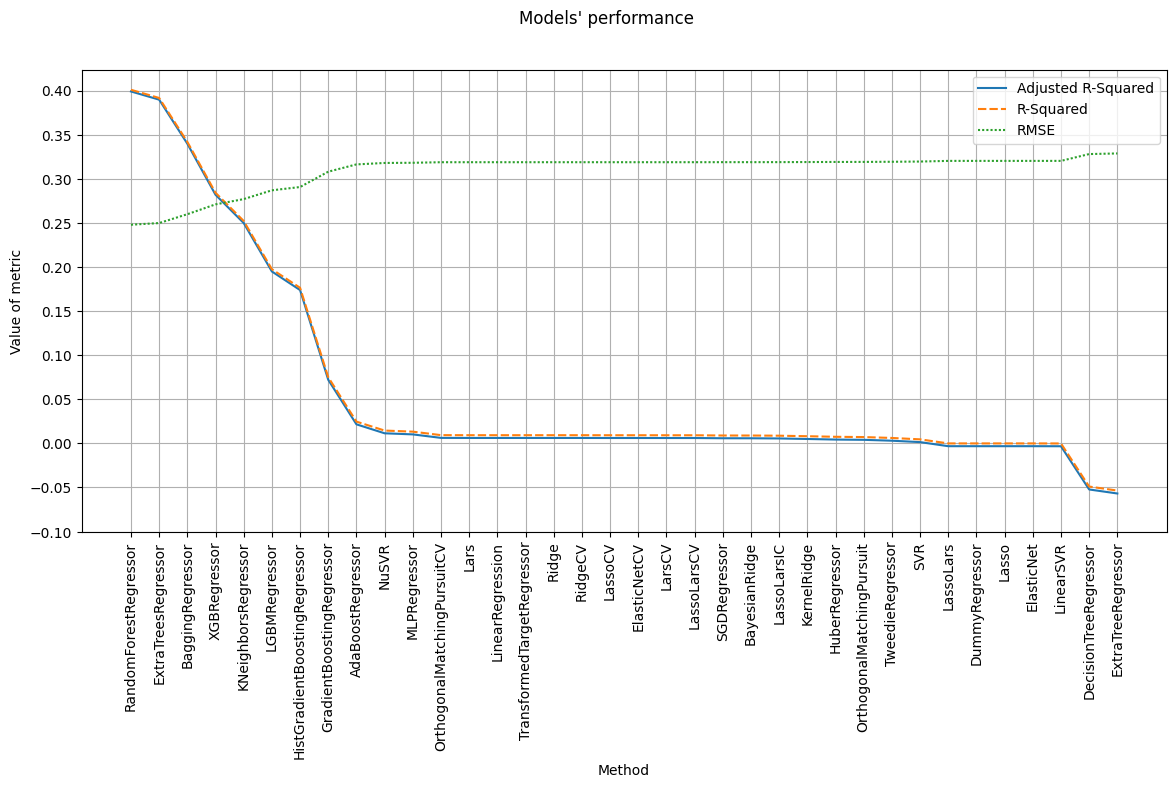

In [122]:
fig, ax = plt.subplots(figsize=(14, 6))

sns.lineplot(
    data=models.iloc[:36, :3],
    ax=ax
)

ax.tick_params(axis='x', labelrotation=90)
ax.set_yticks(np.linspace(-.1, .4, 11))
ax.set_xlabel('Method')
ax.set_ylabel('Value of metric')
plt.suptitle('Models\' performance')

plt.grid()
plt.tight_layout;

### Random forest regressor

The best random forest has much larger difference in metric on training and validation sets than in previous XGB models - RMSE and MAE on the training set are 0.0946 and 0.0737, respectively, while on the validation set: 0.2438 and 0.1905. Such a large difference is due to the excessively high value of the *max_depth* hyperparameter - as can be seen in the chart below, the model's performance on the validation set no longer improves significantly for values of this hyperparameter above 25, while at the same time the metrics on the training set continue to decline. The model with the *max_depth* hyperparameter equal to 25 has slightly worse RMSE and MAE on the validation set (0.2484 and 0.1971 respectively), but differ from the prediction metrics on the training set by about 0.1.

In [12]:
rf_reg = ens.RandomForestRegressor(random_state=1234)

rf_params = {
    'n_estimators':[1000],
    'criterion':['squared_error'],
    'max_depth':list(range(5, 55, 5)) + [None],
    'max_features':['auto', 'sqrt'] + list(np.linspace(0, 1, 11))
}

rf_rscv = RandomizedSearchCV(rf_reg, rf_params, n_iter=100, cv=5, random_state=1234, verbose=0)

rf_rscv.fit(X_train_final, y_train_final)

rf_rscv.best_estimator_

RandomForestRegressor(max_depth=40, max_features=0.1, n_estimators=1000,
                      random_state=1234)

In [25]:
# Best random forest regressor
rf_model = rf_rscv.best_estimator_
rf_model.fit(X_train_final, y_train_final)

model_results(
    rf_model, 'Random forest regressor',
    X_train_final, X_val_final,
    y_train_final, y_val_final,
    False
)

Model's performance on training set
                          RMSE    MAE
Random forest regressor 0.0946 0.0737

Model's performance on validation set
                          RMSE    MAE
Random forest regressor 0.2438 0.1905

Difference in model's performance on validation and training sets
                          RMSE    MAE
Random forest regressor 0.1492 0.1168


In [14]:
# Saving the model
joblib.dump(rf_model, 'models\\regression\\random_forest_regressor_best')

['models\\regression\\random_forest_regressor_best']

In [29]:
rf_metrics_dict = {
    'Training RMSE':[],
    'Training MAE':[],
    'Validation RMSE':[],
    'Validation MAE':[]
}

for i in range(1, 56):
    rf_model_fix = ens.RandomForestRegressor(
        n_estimators=1000,
        criterion='squared_error',
        max_depth=i,
        max_features=.01,
        random_state=1234
    )
    rf_model_fix.fit(X_train_final, y_train_final)

    training_metrics, validation_metrics = model_results(
        rf_model_fix, 'Random forest regressor (fixed)',
        X_train_final, X_val_final,
        y_train_final, y_val_final,
        True
    )

    rf_metrics_dict['Training RMSE'].append(training_metrics['RMSE'])
    rf_metrics_dict['Training MAE'].append(training_metrics['MAE'])
    rf_metrics_dict['Validation RMSE'].append(validation_metrics['RMSE'])
    rf_metrics_dict['Validation MAE'].append(validation_metrics['MAE'])

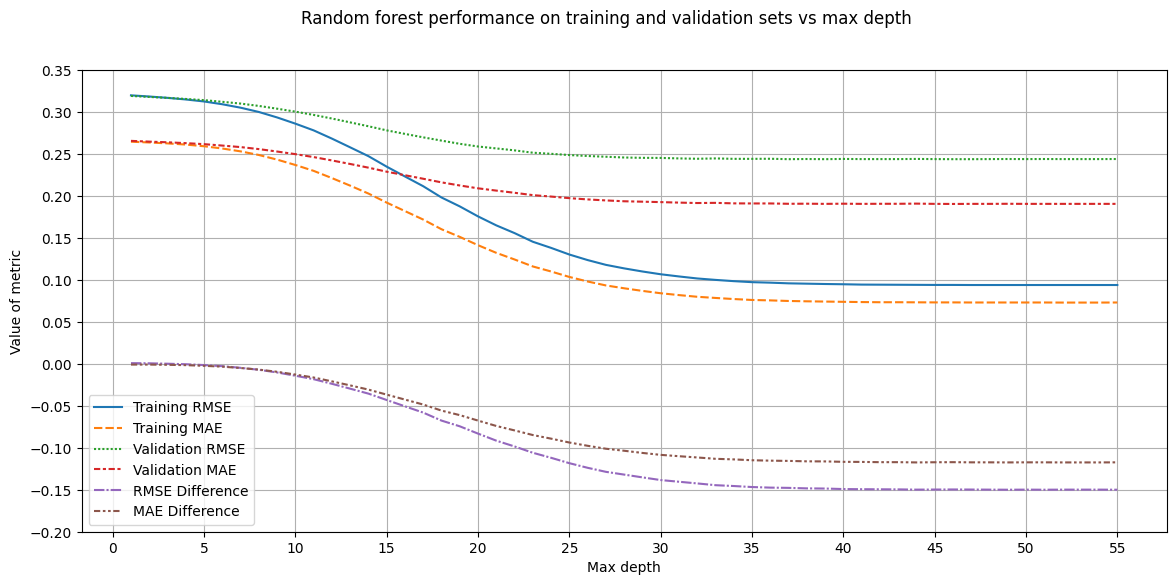

In [33]:
rf_metrics = pd.DataFrame(rf_metrics_dict, index=range(1, 56))
rf_metrics['RMSE Difference'] = rf_metrics['Training RMSE'] - rf_metrics['Validation RMSE']
rf_metrics['MAE Difference'] = rf_metrics['Training MAE'] - rf_metrics['Validation MAE']

fig, ax = plt.subplots(figsize=(14, 6))

sns.lineplot(
    data=rf_metrics,
    ax=ax
)

ax.set_xticks(range(0, 60, 5))
ax.set_yticks(np.linspace(-.2, .35, 12))

ax.set_xlabel('Max depth')
ax.set_ylabel('Value of metric')
plt.suptitle(
    'Random forest performance on training and validation sets vs max depth'
)

plt.grid()
plt.tight_layout;

In [128]:
# Fixed random forest regressor

rf_model_fix = ens.RandomForestRegressor(
    n_estimators=1000,
    criterion='squared_error',
    max_depth=25,
    max_features=.01,
    random_state=1234
)
rf_model_fix.fit(X_train_final, y_train_final)

model_results(
    rf_model_fix, 'Random forest regressor (fixed)',
    X_train_final, X_val_final,
    y_train_final, y_val_final,
    False
)

Model's performance on training set
                                  RMSE    MAE
Random forest regressor (fixed) 0.1300 0.1033

Model's performance on validation set
                                  RMSE    MAE
Random forest regressor (fixed) 0.2484 0.1971

Difference in model's performance on validation and training sets
                                  RMSE    MAE
Random forest regressor (fixed) 0.1184 0.0938


In [129]:
# Saving the model
joblib.dump(rf_model_fix, 'models\\regression\\random_forest_regressor_fixed')

['models\\regression\\random_forest_regressor_fixed']

### Extra trees regressor

For extra trees, the situation is very similar: RMSE and MAE on the training set are 0.0376 and 0.0191, respectively, while on the validation set: 0.2399 and 0.1816. The difference is again due to the *max_depth* hyperparameter being slightly too high, while the model with a max depth of 40 gave more similar performance on the training and validation sets.

In [15]:
et_reg = ens.ExtraTreesRegressor(random_state=1234)

et_params = {
    'n_estimators':[1000],
    'criterion':['squared_error'],
    'max_depth':list(range(5, 55, 5)) + [None],
    'max_features':['auto', 'sqrt'] + list(np.linspace(0, 1, 11))
}

et_rscv = RandomizedSearchCV(et_reg, et_params, n_iter=100, cv=5, random_state=1234, verbose=0)

et_rscv.fit(X_train_final, y_train_final)

et_rscv.best_estimator_

ExtraTreesRegressor(max_depth=50, max_features=0.2, n_estimators=1000,
                    random_state=1234)

In [26]:
# Best extra trees regressor
et_model = et_rscv.best_estimator_
et_model.fit(X_train_final, y_train_final)

model_results(
    et_model, 'Extra trees regressor',
    X_train_final, X_val_final,
    y_train_final, y_val_final,
    False
)

Model's performance on training set
                        RMSE    MAE
Extra trees regressor 0.0376 0.0191

Model's performance on validation set
                        RMSE    MAE
Extra trees regressor 0.2399 0.1816

Difference in model's performance on validation and training sets
                        RMSE    MAE
Extra trees regressor 0.2023 0.1625


In [17]:
# Saving the model
joblib.dump(et_model, 'models\\regression\\extra_trees_regressor_best')

['models\\regression\\extra_trees_regressor_best']

In [37]:
et_metrics_dict = {
    'Training RMSE':[],
    'Training MAE':[],
    'Validation RMSE':[],
    'Validation MAE':[]
}

for i in range(1, 56):
    et_model_fix = ens.ExtraTreesRegressor(
        n_estimators=1000,
        criterion='squared_error',
        max_depth=i,
        max_features=.02,
        random_state=1234
    )
    et_model_fix.fit(X_train_final, y_train_final)

    training_metrics, validation_metrics = model_results(
        et_model_fix, 'Extra trees regressor (fixed)',
        X_train_final, X_val_final,
        y_train_final, y_val_final,
        True
    )

    et_metrics_dict['Training RMSE'].append(training_metrics['RMSE'])
    et_metrics_dict['Training MAE'].append(training_metrics['MAE'])
    et_metrics_dict['Validation RMSE'].append(validation_metrics['RMSE'])
    et_metrics_dict['Validation MAE'].append(validation_metrics['MAE'])

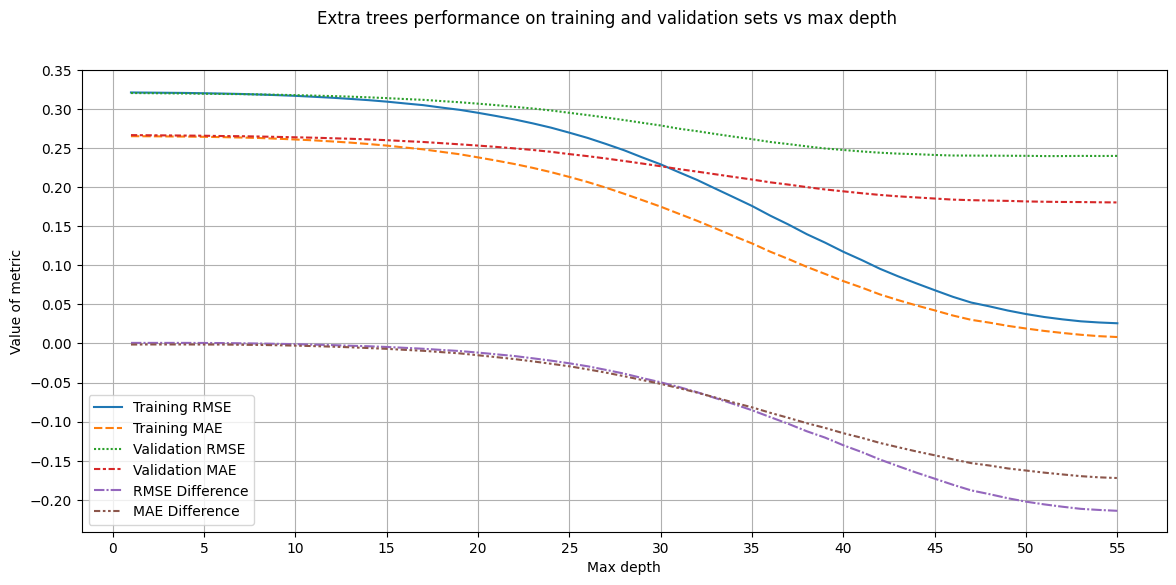

In [38]:
et_metrics = pd.DataFrame(et_metrics_dict, index=range(1, 56))
et_metrics['RMSE Difference'] = et_metrics['Training RMSE'] - et_metrics['Validation RMSE']
et_metrics['MAE Difference'] = et_metrics['Training MAE'] - et_metrics['Validation MAE']

fig, ax = plt.subplots(figsize=(14, 6))

sns.lineplot(
    data=et_metrics,
    ax=ax
)

ax.set_xticks(range(0, 60, 5))
ax.set_yticks(np.linspace(-.2, .35, 12))

ax.set_xlabel('Max depth')
ax.set_ylabel('Value of metric')
plt.suptitle(
    'Extra trees performance on training and validation sets vs max depth'
)

plt.grid()
plt.tight_layout;

In [130]:
# Fixed extra trees regressor

et_model_fix = ens.ExtraTreesRegressor(
    n_estimators=1000,
    criterion='squared_error',
    max_depth=40,
    max_features=.02,
    random_state=1234
)
et_model_fix.fit(X_train_final, y_train_final)

model_results(
    et_model_fix, 'Extra trees regressor (fixed)',
    X_train_final, X_val_final,
    y_train_final, y_val_final,
    False
)

Model's performance on training set
                                RMSE    MAE
Extra trees regressor (fixed) 0.1172 0.0797

Model's performance on validation set
                                RMSE    MAE
Extra trees regressor (fixed) 0.2474 0.1945

Difference in model's performance on validation and training sets
                                RMSE    MAE
Extra trees regressor (fixed) 0.1302 0.1148


In [131]:
# Saving the model
joblib.dump(et_model_fix, 'models\\regression\\extra_trees_regressor_fixed')

['models\\regression\\extra_trees_regressor_fixed']

### Bagging regressor

The bagging regressor struggles with the same problem, but the culprit here is the *max_features* hyperparameter (cross-validation suggested a value of 0.85). As can be seen in the chart below, once the value of this hyperparameter reaches 0.6, the model does not improve significantly on the validation set.

In [18]:
bag_reg = ens.BaggingRegressor(random_state=1234)

bag_params = {
    'n_estimators':[1000],
    'max_samples':list(np.linspace(0, 1, 21)),
    'max_features':list(np.linspace(0, 1, 21))
}

bag_rscv = RandomizedSearchCV(bag_reg, bag_params, n_iter=100, cv=5, random_state=1234, verbose=0)

bag_rscv.fit(X_train_final, y_train_final)

bag_rscv.best_estimator_

BaggingRegressor(max_features=0.8500000000000001, n_estimators=1000,
                 random_state=1234)

In [27]:
# Best bagging regressor
bag_model = bag_rscv.best_estimator_
bag_model.fit(X_train_final, y_train_final)

model_results(
    bag_model, 'Bagging regressor',
    X_train_final, X_val_final,
    y_train_final, y_val_final,
    False
)

Model's performance on training set
                    RMSE    MAE
Bagging regressor 0.0972 0.0763

Model's performance on validation set
                    RMSE    MAE
Bagging regressor 0.2453 0.1931

Difference in model's performance on validation and training sets
                    RMSE    MAE
Bagging regressor 0.1481 0.1168


In [20]:
# Saving the model
joblib.dump(bag_model, 'models\\regression\\bagging_regressor_best')

['models\\regression\\bagging_regressor_best']

In [41]:
bag_metrics_dict = {
    'Training RMSE':[],
    'Training MAE':[],
    'Validation RMSE':[],
    'Validation MAE':[]
}

for i in range(1, 21):
    bag_model_fix = ens.BaggingRegressor(
        n_estimators=1000,
        max_features=i / 20,
        random_state=1234
    )
    bag_model_fix.fit(X_train_final, y_train_final)

    training_metrics, validation_metrics = model_results(
        bag_model_fix, 'Bagging regressor (fixed)',
        X_train_final, X_val_final,
        y_train_final, y_val_final,
        True
    )

    bag_metrics_dict['Training RMSE'].append(training_metrics['RMSE'])
    bag_metrics_dict['Training MAE'].append(training_metrics['MAE'])
    bag_metrics_dict['Validation RMSE'].append(validation_metrics['RMSE'])
    bag_metrics_dict['Validation MAE'].append(validation_metrics['MAE'])

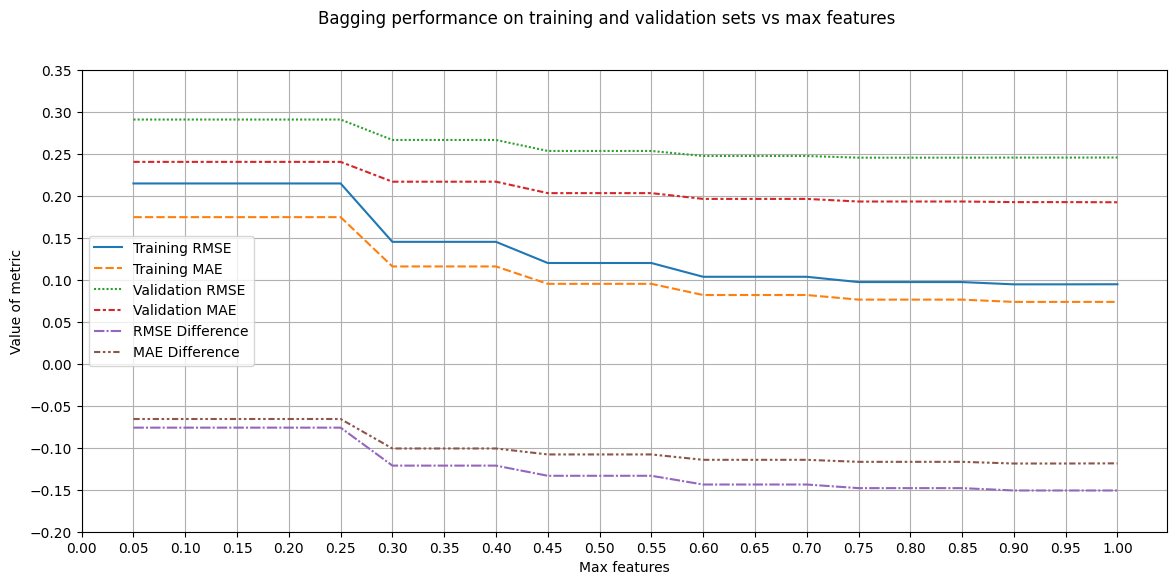

In [43]:
bag_metrics = pd.DataFrame(bag_metrics_dict, index=np.linspace(0.05, 1, 20))
bag_metrics['RMSE Difference'] = bag_metrics['Training RMSE'] - bag_metrics['Validation RMSE']
bag_metrics['MAE Difference'] = bag_metrics['Training MAE'] - bag_metrics['Validation MAE']

fig, ax = plt.subplots(figsize=(14, 6))

sns.lineplot(
    data=bag_metrics,
    ax=ax
)

ax.set_xticks(np.linspace(0, 1, 21))
ax.set_yticks(np.linspace(-.2, .35, 12))

ax.set_xlabel('Max features')
ax.set_ylabel('Value of metric')
plt.suptitle(
    'Bagging performance on training and validation sets vs max features'
)

plt.grid()
plt.tight_layout;

In [16]:
# Fixed bagging regressor

bag_model_fix = ens.BaggingRegressor(
        n_estimators=1000,
        max_features=.6,
        random_state=1234
)
bag_model_fix.fit(X_train_final, y_train_final)

model_results(
    bag_model_fix, 'Bagging (fixed)',
    X_train_final, X_val_final,
    y_train_final, y_val_final,
    False
)

Model's performance on training set
                  RMSE    MAE
Bagging (fixed) 0.1035 0.0818

Model's performance on validation set
                  RMSE    MAE
Bagging (fixed) 0.2473 0.1962

Difference in model's performance on validation and training sets
                  RMSE    MAE
Bagging (fixed) 0.1438 0.1144


In [133]:
# Saving the model
joblib.dump(bag_model_fix, 'models\\regression\\bagging_regressor_fixed')

['models\\regression\\bagging_regressor_fixed']

### XGB regressor

XGB gave relatively good results on the validation set, with a relatively small difference between the results on the training and validation sets (0.0723 and 0.0591 for RMSE and MAE, respectively). As can be seen in the chart below, all metrics flatten out at about the same point, so there is no question of over-fitting the model with the hyperparameter *max_depth* value proposed by cross-validation.

In [55]:
xgb_reg = xgb.XGBRegressor(random_state=1234)

xgb_params = {
    'eta':list(np.linspace(.01, .1, 10)),
    'gamma':list(range(16)),
    'max_depth':list(range(5, 55, 5)),
    'subsample':list(np.linspace(0, 1, 11)),
    'colsample_bytree':list(np.linspace(0, 1, 11)),
    'reg_alpha':list(range(11)),
    'reg_lambda':list(range(11)),
    'num_leaves':list(range(100, 3100, 100)),
    'n_estimators':[1000]
}

xgb_rscv = RandomizedSearchCV(xgb_reg, xgb_params, n_iter=100, cv=5, random_state=1234, verbose=0)

xgb_rscv.fit(X_train_final, y_train_final)

xgb_rscv.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
             early_stopping_rounds=None, enable_categorical=False, eta=0.07,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.0700000003,
             max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=45, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_leaves=700, num_parallel_tree=1, ...)

In [56]:
# Best XGB regressor
xgb_model = xgb_rscv.best_estimator_
xgb_model.fit(X_train_final, y_train_final)

model_results(
    xgb_model, 'XGB regressor',
    X_train_final, X_val_final,
    y_train_final, y_val_final,
    False
)

Model's performance on training set
                RMSE    MAE
XGB regressor 0.1799 0.1433

Model's performance on validation set
                RMSE    MAE
XGB regressor 0.2522 0.2024

Difference in model's performance on validation and training sets
                RMSE    MAE
XGB regressor 0.0723 0.0591


In [57]:
# Saving the model
joblib.dump(xgb_model, 'models\\regression\\xgb_regressor_best')

['models\\regression\\xgb_regressor_best']

In [11]:
xgb_metrics_dict = {
    'Training RMSE':[],
    'Training MAE':[],
    'Validation RMSE':[],
    'Validation MAE':[]
}

for i in range(1, 56):
    xgb_model_fix = xgb.XGBRegressor(
        eta=.07,
        gamma=0,
        max_depth=i,
        subsample=.9,
        colsample_bytree=.9,
        reg_alpha=5,
        reg_lambda=2,
        num_leaves=700,
        n_estimators=1000,
        random_state = 1234
    )
    xgb_model_fix.fit(X_train_final, y_train_final)

    training_metrics, validation_metrics = model_results(
        xgb_model_fix, 'XGB regressor (fixed)',
        X_train_final, X_val_final,
        y_train_final, y_val_final,
        True
    )

    xgb_metrics_dict['Training RMSE'].append(training_metrics['RMSE'])
    xgb_metrics_dict['Training MAE'].append(training_metrics['MAE'])
    xgb_metrics_dict['Validation RMSE'].append(validation_metrics['RMSE'])
    xgb_metrics_dict['Validation MAE'].append(validation_metrics['MAE'])

In [12]:
xgb_metrics = pd.DataFrame(xgb_metrics_dict, index=range(1, 56))
xgb_metrics['RMSE Difference'] = xgb_metrics['Training RMSE'] - xgb_metrics['Validation RMSE']
xgb_metrics['MAE Difference'] = xgb_metrics['Training MAE'] - xgb_metrics['Validation MAE']

fig, ax = plt.subplots(figsize=(14, 6))

sns.lineplot(
    data=xgb_metrics,
    ax=ax
)

ax.set_xticks(range(0, 60, 5))
ax.set_yticks(np.linspace(-.2, .35, 12))

ax.set_xlabel('Max depth')
ax.set_ylabel('Value of metric')
plt.suptitle(
    'XGB performance on training and validation sets vs max depth'
)

plt.grid()
plt.tight_layout;

### KNN Regressor

KNN regressor gave very interesting results - the value of MAE and RMSE on the training set is constant regardless of the number of neighbors or power parameter. In contrast, the metrics on the validation set are lowest for five neighbors and a power parameter equal to 1. However, the choice of such hyperparameter values does not change the very large difference between the metrics on the training and validation sets.

In [89]:
knn_reg = KNeighborsRegressor()

knn_params = {
    'n_neighbors':list(range(5, 105, 5)),
    'weights':['uniform', 'distance'],
    'leaf_size':list(range(10, 110, 10)),
    'p':list(range(1, 11))
}

knn_rscv = RandomizedSearchCV(knn_reg, knn_params, n_iter=100, cv=5, random_state=1234, verbose=0)

knn_rscv.fit(X_train_final, y_train_final)

knn_rscv.best_estimator_

KNeighborsRegressor(leaf_size=100, n_neighbors=10, weights='distance')

In [91]:
# Best knn regressor
knn_model = knn_rscv.best_estimator_
knn_model.fit(X_train_final, y_train_final)

model_results(
    knn_model, 'knn regressor',
    X_train_final, X_val_final,
    y_train_final, y_val_final,
    False
)

Model's performance on training set
                RMSE    MAE
knn regressor 0.0233 0.0027

Model's performance on validation set
                RMSE    MAE
knn regressor 0.2638 0.2046

Difference in model's performance on validation and training sets
                RMSE    MAE
knn regressor 0.2405 0.2019


In [92]:
# Saving the model
joblib.dump(knn_model, 'models\\regression\\knn_regressor_best')

['models\\regression\\knn_regressor_best']

In [96]:
knn_metrics_dict = {
    'Training RMSE':[],
    'Training MAE':[],
    'Validation RMSE':[],
    'Validation MAE':[]
}

for i in range(5, 105, 5):
    knn_model_fix = KNeighborsRegressor(
        n_neighbors=i,
        weights='distance',
        leaf_size=100,
        p=2
    )
    knn_model_fix.fit(X_train_final, y_train_final)

    training_metrics, validation_metrics = model_results(
        knn_model_fix, 'KNN regressor (fixed)',
        X_train_final, X_val_final,
        y_train_final, y_val_final,
        True
    )

    knn_metrics_dict['Training RMSE'].append(training_metrics['RMSE'])
    knn_metrics_dict['Training MAE'].append(training_metrics['MAE'])
    knn_metrics_dict['Validation RMSE'].append(validation_metrics['RMSE'])
    knn_metrics_dict['Validation MAE'].append(validation_metrics['MAE'])

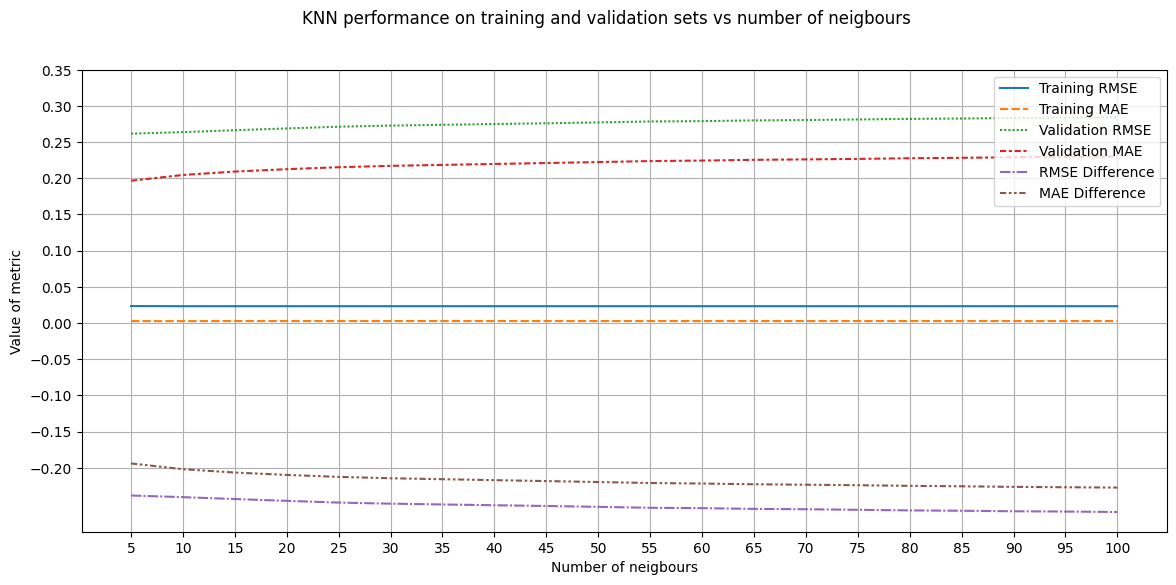

In [98]:
knn_metrics = pd.DataFrame(knn_metrics_dict, index=range(5, 105, 5))
knn_metrics['RMSE Difference'] = knn_metrics['Training RMSE'] - knn_metrics['Validation RMSE']
knn_metrics['MAE Difference'] = knn_metrics['Training MAE'] - knn_metrics['Validation MAE']

fig, ax = plt.subplots(figsize=(14, 6))

sns.lineplot(
    data=knn_metrics,
    ax=ax
)

ax.set_xticks(range(5, 105, 5))
ax.set_yticks(np.linspace(-.2, .35, 12))

ax.set_xlabel('Number of neigbours')
ax.set_ylabel('Value of metric')
plt.suptitle(
    'KNN performance on training and validation sets vs number of neigbours'
)

plt.grid()
plt.tight_layout;

In [99]:
knn_metrics_dict = {
    'Training RMSE':[],
    'Training MAE':[],
    'Validation RMSE':[],
    'Validation MAE':[]
}

for i in range(1, 11):
    knn_model_fix = KNeighborsRegressor(
        n_neighbors=5,
        weights='distance',
        leaf_size=100,
        p=i
    )
    knn_model_fix.fit(X_train_final, y_train_final)

    training_metrics, validation_metrics = model_results(
        knn_model_fix, 'KNN regressor (fixed)',
        X_train_final, X_val_final,
        y_train_final, y_val_final,
        True
    )

    knn_metrics_dict['Training RMSE'].append(training_metrics['RMSE'])
    knn_metrics_dict['Training MAE'].append(training_metrics['MAE'])
    knn_metrics_dict['Validation RMSE'].append(validation_metrics['RMSE'])
    knn_metrics_dict['Validation MAE'].append(validation_metrics['MAE'])

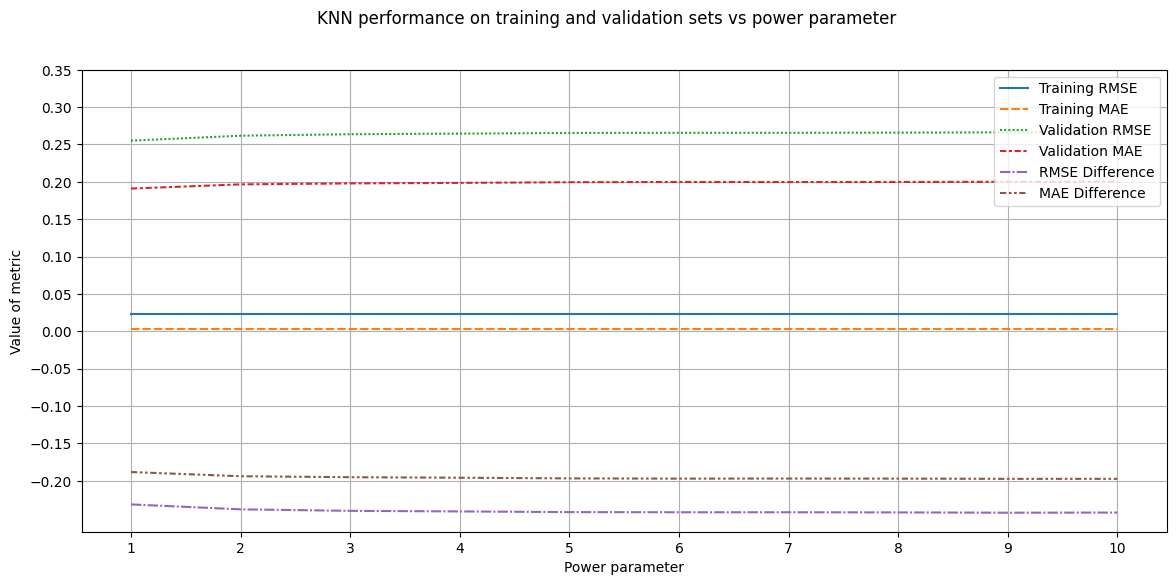

In [100]:
knn_metrics = pd.DataFrame(knn_metrics_dict, index=range(1, 11))
knn_metrics['RMSE Difference'] = knn_metrics['Training RMSE'] - knn_metrics['Validation RMSE']
knn_metrics['MAE Difference'] = knn_metrics['Training MAE'] - knn_metrics['Validation MAE']

fig, ax = plt.subplots(figsize=(14, 6))

sns.lineplot(
    data=knn_metrics,
    ax=ax
)

ax.set_xticks(range(1, 11))
ax.set_yticks(np.linspace(-.2, .35, 12))

ax.set_xlabel('Power parameter')
ax.set_ylabel('Value of metric')
plt.suptitle(
    'KNN performance on training and validation sets vs power parameter'
)

plt.grid()
plt.tight_layout;

In [28]:
# Fixed KNN regressor

knn_model_fix = KNeighborsRegressor(
    n_neighbors=5,
    weights='distance',
    leaf_size=100,
    p=1
)
knn_model_fix.fit(X_train_final, y_train_final)

model_results(
    knn_model_fix, 'KNN (fixed)',
    X_train_final, X_val_final,
    y_train_final, y_val_final,
    False
)

Model's performance on training set
              RMSE    MAE
KNN (fixed) 0.0235 0.0027

Model's performance on validation set
              RMSE    MAE
KNN (fixed) 0.2551 0.1910

Difference in model's performance on validation and training sets
              RMSE    MAE
KNN (fixed) 0.2316 0.1883


In [102]:
# Saving the model
joblib.dump(knn_model_fix, 'models\\regression\\knn_regressor_fixed')

['models\\regression\\knn_regressor_fixed']

### Stacking

In the last step, we will try to combine the obtained models into one, using another XGB regressor as a meta learner. The lowest RMSE value on the validation set was obtained by the combination of extra trees and XGB regressors (0.2472) and the combination of all five models (0.2486). In terms of MAE, on the other hand, the order was reversed: the combination of five models scored 0.1898, while extra trees and XGB regressors: 0.1904.

In [49]:
# Stacking
model_list = [
    ('random_forest', rf_model_fix),
    ('extra_trees', et_model_fix),
    ('bagging', bag_model_fix),
    ('xgb', xgb_model),
    ('knn', knn_model_fix)
]

comb_model_list = []
for i in range(2, 6):
    for comb in combinations(model_list, i):
        comb_model_list.append(comb)

model_results = {}
for i, model_set in enumerate(comb_model_list):
    model_names = [model[0] for model in model_set]

    stacked_model = ens.StackingRegressor(
        estimators=model_set,
        final_estimator=xgb.XGBRegressor(random_state=1234),
        cv=5
    )

    stacked_model.fit(X_train_final, y_train_final)

    train_pred = stacked_model.predict(X_train_final)
    val_pred = stacked_model.predict(X_val_final)

    model_results[', '.join(model_names)] = [
        skm.mean_squared_error(y_train_final, train_pred, squared=False),
        skm.mean_absolute_error(y_train_final, train_pred),
        skm.mean_squared_error(y_val_final, val_pred, squared=False),
        skm.mean_absolute_error(y_val_final, val_pred)
    ]

In [73]:
model_results_df = pd.DataFrame(
    model_results,
    index=['Training RMSE', 'Training MAE', 'Validation RMSE', 'Validation MAE']
).transpose()
model_results_df

Training RMSE  Training MAE  \
random_forest, extra_trees                            0.1488        0.0986   
random_forest, bagging                                0.1334        0.0968   
random_forest, xgb                                    0.1471        0.1084   
random_forest, knn                                    0.1320        0.0901   
extra_trees, bagging                                  0.1334        0.0908   
extra_trees, xgb                                      0.1463        0.1003   
extra_trees, knn                                      0.1408        0.0896   
bagging, xgb                                          0.1411        0.1045   
bagging, knn                                          0.1139        0.0770   
xgb, knn                                              0.1554        0.1027   
random_forest, extra_trees, bagging                   0.1410        0.0956   
random_forest, extra_trees, xgb                       0.1436        0.1005   
random_forest, extra_trees, knn                       0.1471        0.0945   
random_forest, bagging, xgb                           0.1350        0.0998   
random_forest, bagging, knn                           0.1179        0.0823   
random_forest, xgb, knn                               0.1374        0.0938   
extra_trees, bagging, xgb                             0.1434        0.0999   
extra_trees, bagging, knn                             0.1273        0.0842   
extra_trees, xgb, knn                                 0.1600        0.1029   
bagging, xgb, knn                                     0.1289        0.0898   
random_forest, extra_trees, bagging, xgb              0.1344        0.0943   
random_forest, extra_trees, bagging, knn              0.1359        0.0892   
random_forest, extra_trees, xgb, knn                  0.1469        0.0976   
random_forest, bagging, xgb, knn                      0.1292        0.0891   
extra_trees, bagging, xgb, knn                        0.1406        0.0960   
random_forest, extra_trees, bagging, xgb, knn         0.1414        0.0943   

                                               Validation RMSE  Validation MAE  
random_forest, extra_trees                              0.2526          0.1949  
random_forest, bagging                                  0.2543          0.1973  
random_forest, xgb                                      0.2522          0.1955  
random_forest, knn                                      0.2497          0.1919  
extra_trees, bagging                                    0.2501          0.1927  
extra_trees, xgb                                        0.2472          0.1904  
extra_trees, knn                                        0.2498          0.1930  
bagging, xgb                                            0.2545          0.1982  
bagging, knn                                            0.2540          0.1963  
xgb, knn                                                0.2534          0.1959  
random_forest, extra_trees, bagging                     0.2545          0.1970  
random_forest, extra_trees, xgb                         0.2507          0.1925  
random_forest, extra_trees, knn                         0.2514          0.1933  
random_forest, bagging, xgb                             0.2538          0.1970  
random_forest, bagging, knn                             0.2551          0.1961  
random_forest, xgb, knn                                 0.2517          0.1943  
extra_trees, bagging, xgb                               0.2502          0.1921  
extra_trees, bagging, knn                               0.2542          0.1942  
extra_trees, xgb, knn                                   0.2489          0.1905  
bagging, xgb, knn                                       0.2528          0.1936  
random_forest, extra_trees, bagging, xgb                0.2506          0.1935  
random_forest, extra_trees, bagging, knn                0.2534          0.1949  
random_forest, extra_trees, xgb, knn                    0.2496          0.191

In [74]:
train_rmse_min = model_results_df['Training RMSE'].min()
train_rmse_min_id = model_results_df['Training RMSE'].idxmin()
train_mae_min = model_results_df['Training MAE'].min()
train_mae_min_id = model_results_df['Training MAE'].idxmin()
val_rmse_min = model_results_df['Validation RMSE'].min()
val_rmse_min_id = model_results_df['Validation RMSE'].idxmin()
val_mae_min = model_results_df['Validation MAE'].min()
val_mae_min_id = model_results_df['Validation MAE'].idxmin()

print(f'Minimum training RMSE is {round(train_rmse_min, 4)} for {train_rmse_min_id} model.')
print(f'Minimum training MAE is {round(train_mae_min, 4)} for {train_mae_min_id} model.')
print(f'Minimum validation RMSE is {round(val_rmse_min, 4)} for {val_rmse_min_id} model.')
print(f'Minimum validation MAE is {round(val_mae_min, 4)} for {val_mae_min_id} model.')

Minimum training RMSE is 0.1139 for bagging, knn model.
Minimum training MAE is 0.077 for bagging, knn model.
Minimum validation RMSE is 0.2472 for extra_trees, xgb model.
Minimum validation MAE is 0.1898 for random_forest, extra_trees, bagging, xgb, knn model.


These two models also gave the best - and very close - results on a test set that has not been involved in the analysis so far. Importantly, all models showed a difference in metrics between the validation set and the test set of less than 0.01.

In [31]:
# Stacking best combinations
stacked_model_small = ens.StackingRegressor(
    estimators=[
        ('extra_trees', et_model_fix),
        ('xgb', xgb_model)
    ],
    final_estimator=xgb.XGBRegressor(random_state = 1234),
    cv=5
)

stacked_model_small.fit(X_train_final, y_train_final)

model_results(
    stacked_model_small, 'Stacked model (small)',
    X_train_final, X_val_final,
    y_train_final, y_val_final,
    False
)

# Saving the model
joblib.dump(stacked_model_small, 'models\\regression\\stacked_model_small')

Model's performance on training set
                        RMSE    MAE
Stacked model (small) 0.1463 0.1003

Model's performance on validation set
                        RMSE    MAE
Stacked model (small) 0.2472 0.1904

Difference in model's performance on validation and training sets
                        RMSE    MAE
Stacked model (small) 0.1009 0.0901


['models\\regression\\stacked_model_small']

In [32]:
# Stacking best combinations
stacked_model_large = ens.StackingRegressor(
    estimators=[
        ('random_forest', rf_model_fix),
        ('extra_trees', et_model_fix),
        ('bagging', bag_model_fix),
        ('xgb', xgb_model),
        ('knn', knn_model_fix)
    ],
    final_estimator=xgb.XGBRegressor(random_state = 1234),
    cv=5
)

stacked_model_large.fit(X_train_final, y_train_final)

model_results(
    stacked_model_large, 'Stacked model (large)',
    X_train_final, X_val_final,
    y_train_final, y_val_final,
    False
)

# Saving the model
joblib.dump(stacked_model_large, 'models\\regression\\stacked_model_large')

Model's performance on training set
                        RMSE    MAE
Stacked model (large) 0.1414 0.0943

Model's performance on validation set
                        RMSE    MAE
Stacked model (large) 0.2486 0.1898

Difference in model's performance on validation and training sets
                        RMSE    MAE
Stacked model (large) 0.1072 0.0955


['models\\regression\\stacked_model_large']

In [33]:
# Model list for test set
test_list = [
    ('random_forest', rf_model_fix),
    ('extra_trees', et_model_fix),
    ('bagging', bag_model_fix),
    ('xgb', xgb_model),
    ('knn', knn_model_fix),
    ('stacked_small', stacked_model_small),
    ('stacked_large', stacked_model_large)
]

for model in test_list:
    val_pred = model[1].predict(X_val_final)
    test_pred = model[1].predict(X_test_final)

    val_rmse = round(skm.mean_squared_error(y_val_final, val_pred, squared=False), 4)
    val_mae = round(skm.mean_absolute_error(y_val_final, val_pred,), 4)
    test_rmse = round(skm.mean_squared_error(y_test_final, test_pred, squared=False), 4)
    test_mae = round(skm.mean_absolute_error(y_test_final, test_pred,), 4)
    
    print(f'{model[0]} performance:')
    print(f'Validation RMSE: {val_rmse}, test RMSE: {test_rmse}, '\
        f'absolute difference: {round(abs(val_rmse - test_rmse), 4)}')
    print(f'Validation MAE: {val_mae}, test MAE: {test_mae}, '\
        f'absolute difference: {round(abs(val_mae - test_mae), 4)}\n')   


random_forest performance:
Validation RMSE: 0.2484, test RMSE: 0.2531, absolute difference: 0.0047
Validation MAE: 0.1971, test MAE: 0.2012, absolute difference: 0.0041

extra_trees performance:
Validation RMSE: 0.2474, test RMSE: 0.2518, absolute difference: 0.0044
Validation MAE: 0.1945, test MAE: 0.1977, absolute difference: 0.0032

bagging performance:
Validation RMSE: 0.2533, test RMSE: 0.2567, absolute difference: 0.0034
Validation MAE: 0.2031, test MAE: 0.206, absolute difference: 0.0029

xgb performance:
Validation RMSE: 0.2522, test RMSE: 0.2583, absolute difference: 0.0061
Validation MAE: 0.2024, test MAE: 0.2072, absolute difference: 0.0048

knn performance:
Validation RMSE: 0.2551, test RMSE: 0.2623, absolute difference: 0.0072
Validation MAE: 0.191, test MAE: 0.1981, absolute difference: 0.0071

stacked_small performance:
Validation RMSE: 0.2472, test RMSE: 0.2518, absolute difference: 0.0046
Validation MAE: 0.1904, test MAE: 0.1944, absolute difference: 0.004

stacked_lar

In [4]:
# Loading the models

rf_model_fix = joblib.load('models\\regression\\random_forest_regressor_fixed')
et_model_fix = joblib.load('models\\regression\\extra_trees_regressor_fixed')
bag_model_fix = joblib.load('models\\regression\\bagging_regressor_fixed')
xgb_model = joblib.load('models\\regression\\xgb_regressor_best')
knn_model_fix = joblib.load('models\\regression\\knn_regressor_fixed')
stacked_model_small = joblib.load('models\\regression\\stacked_model_small')
stacked_model_large = joblib.load('models\\regression\\stacked_model_large')

# Explanatory model analysis

In this part of the analysis, we will assess which variables were most significant for the obtained models - the permutation-based variable-importance evaluation method will help. All models except KNN regressor indicate that the most important variables are **price** and **capitalization**. The KNN regressor, on the other hand, considers **supplementary_capital** and **supplementary_capital_per_share** to be key.

Taking a closer look, we can see that in the case of the random forest, bagging and XGB regressors, as well as both stacked models, share price and company capitalization stand out significantly, while the significance of the other variables in the model is similar. In the extra trees regressor, on the other hand, the number of shares is almost as important as the price and capitalization.

In [13]:
# Model explainers
rf_model_fix_exp = dx.Explainer(
    rf_model_fix, X_train_final, y_train_final, verbose=False, label='Random Forest')
et_model_fix_exp = dx.Explainer(
    et_model_fix, X_train_final, y_train_final, verbose=False, label='Extra Trees')
bag_model_fix_exp = dx.Explainer(
    bag_model_fix, X_train_final, y_train_final, verbose=False, label='Bagging')
xgb_model_exp = dx.Explainer(
    xgb_model, X_train_final, y_train_final, verbose=False, label='XGB')
knn_model_fix_exp = dx.Explainer(
    knn_model_fix, X_train_final, y_train_final, verbose=False, label='KNN')
stacked_model_small_exp = dx.Explainer(
    stacked_model_small, X_train_final, y_train_final, verbose=False, label='Stacked model (small)')
stacked_model_large_exp = dx.Explainer(
    stacked_model_large, X_train_final, y_train_final, verbose=False, label='Stacked model (large)')

In [54]:
# Model parts
rf_model_fix_mp = rf_model_fix_exp.model_parts()
et_model_fix_mp = et_model_fix_exp.model_parts()
bag_model_fix_mp = bag_model_fix_exp.model_parts()
xgb_model_mp = xgb_model_exp.model_parts()
knn_model_fix_mp = knn_model_fix_exp.model_parts()
stacked_model_small_mp = stacked_model_small_exp.model_parts()
stacked_model_large_mp = stacked_model_large_exp.model_parts()

In [55]:
rf_model_fix_mp.plot()
et_model_fix_mp.plot()
bag_model_fix_mp.plot()
xgb_model_mp.plot()
knn_model_fix_mp.plot()
stacked_model_small_mp.plot()
stacked_model_large_mp.plot()

The accumulated local dependence profile of the **price** variable shows that all models captured the effect of a low stock price on high returns, with the XGB regressor placing the most emphasis on this fact. The KNN regressor, on the other hand, was very sensitive to extreme prediction values in observations whose price was higher than the 90th percentile of the variable.

In [12]:
rf_model_fix_profile_al = rf_model_fix_exp.model_profile(type = 'accumulated')
et_model_fix_profile_al = et_model_fix_exp.model_profile(type = 'accumulated')
bag_model_fix_profile_al = bag_model_fix_exp.model_profile(type = 'accumulated')
xgb_model_profile_al = xgb_model_exp.model_profile(type = 'accumulated')
knn_model_fix_profile_al = knn_model_fix_exp.model_profile(type = 'accumulated')
stacked_model_small_profile_al = stacked_model_small_exp.model_profile(type = 'accumulated')
stacked_model_large_profile_al = stacked_model_large_exp.model_profile(type = 'accumulated')

Calculating accumulated dependency: 100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


Percentiles of Price:
5th: -0.1389
10th: -0.1376
15th: -0.1361
20th: -0.1343
25th: -0.1323
30th: -0.1304
35th: -0.1278
40th: -0.1244
45th: -0.1212
50th: -0.117
55th: -0.1122
60th: -0.1066
65th: -0.1005
70th: -0.0917
75th: -0.0792
80th: -0.0559
85th: -0.0217
90th: 0.048
95th: 0.265


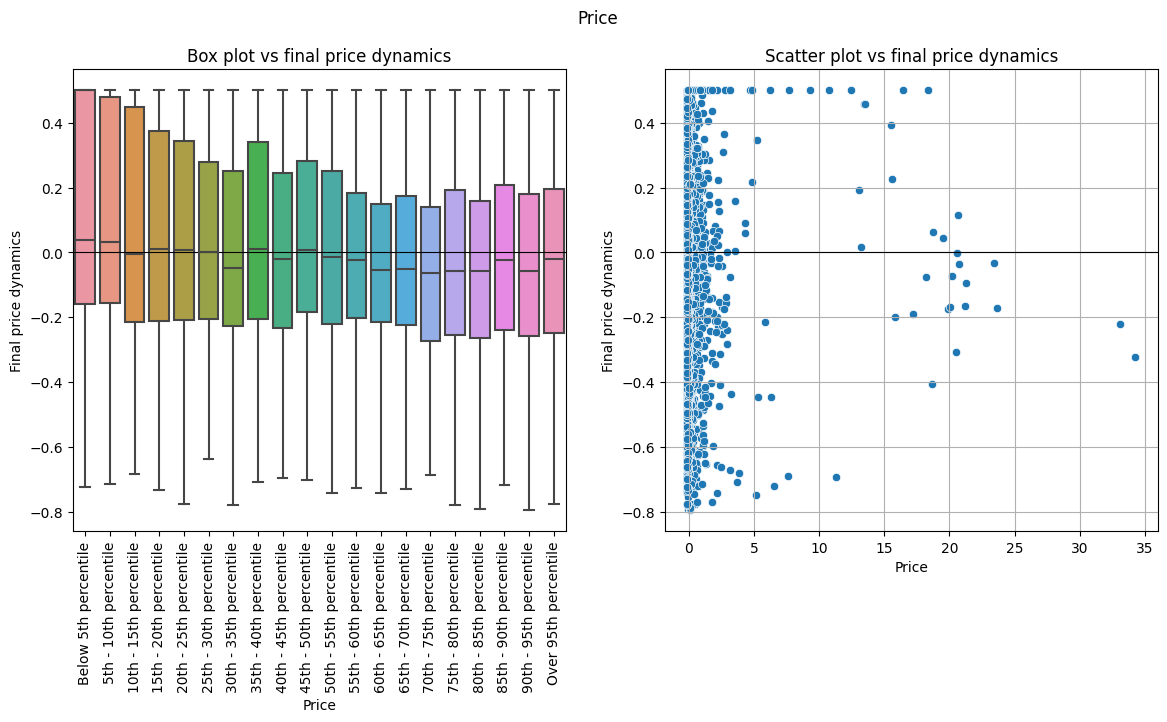

In [78]:
feature_exploration(X_train_final.price, 'Price', y_train_final.final_price_dynamics)

In [84]:
rf_model_fix_profile_al.plot(
    [
        et_model_fix_profile_al, bag_model_fix_profile_al, xgb_model_profile_al,
        knn_model_fix_profile_al, stacked_model_small_profile_al, stacked_model_large_profile_al
    ],
    variables = ['price']
)

In the case of capitalization, the hypersensitivity of the KNN regressor to values of this variable above the 90th percentile is also very apparent. Other models were able to better capture the fact that the greatest opportunity for high returns is in observations with low capitalization.

Percentiles of Capitalization:
5th: -0.2484
10th: -0.2468
15th: -0.2451
20th: -0.2434
25th: -0.2418
30th: -0.2398
35th: -0.2374
40th: -0.2346
45th: -0.2305
50th: -0.2254
55th: -0.2193
60th: -0.2114
65th: -0.199
70th: -0.1831
75th: -0.1576
80th: -0.1149
85th: -0.044
90th: 0.1
95th: 0.6748


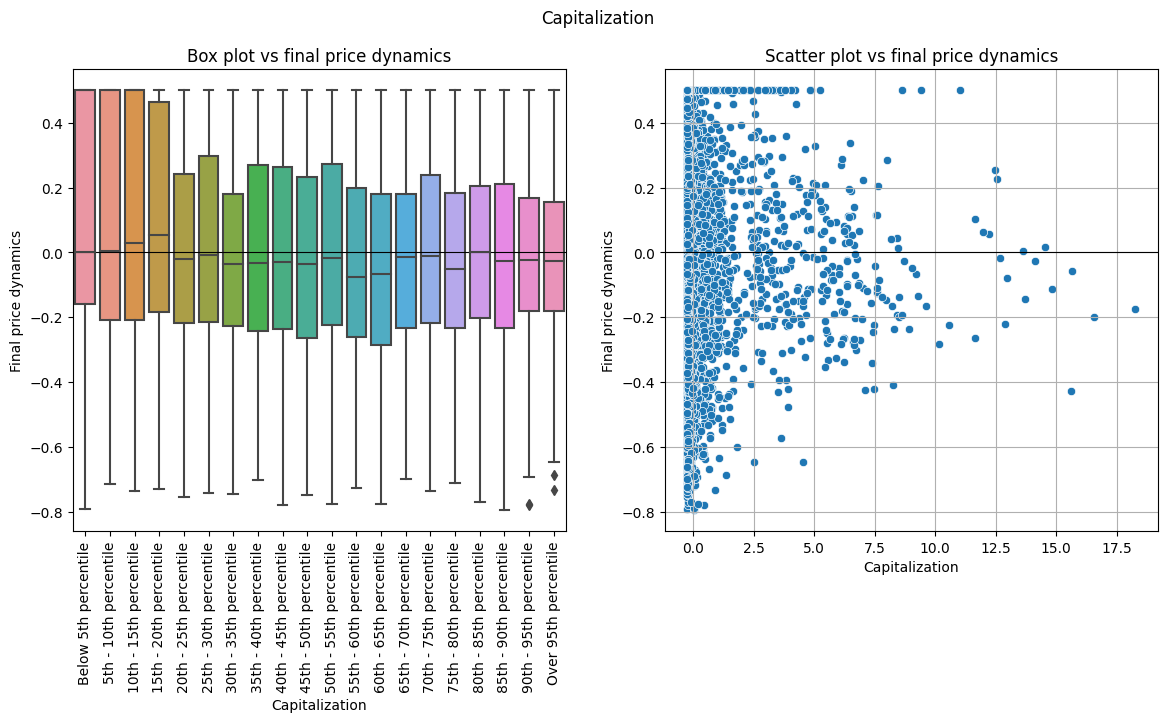

In [79]:
feature_exploration(
    X_train_final.capitalization, 'Capitalization', y_train_final.final_price_dynamics
)

In [83]:
rf_model_fix_profile_al.plot(
    [
        et_model_fix_profile_al, bag_model_fix_profile_al, xgb_model_profile_al,
        knn_model_fix_profile_al, stacked_model_small_profile_al, stacked_model_large_profile_al
    ],
    variables = ['capitalization']
)

In the case of the **number_of_shares** variable, it can be seen that companies with a small number of shares (below the 5th percentile) performed significantly worse, while better investment returns were given by observations with the number of shares between the 5th and 30th percentile. Extra trees and bagging regressors were best able to capture this fact.

Percentiles of Number of shares:
5th: -0.3094
10th: -0.305
15th: -0.3012
20th: -0.2946
25th: -0.2871
30th: -0.2797
35th: -0.2717
40th: -0.2652
45th: -0.2549
50th: -0.2459
55th: -0.2287
60th: -0.2091
65th: -0.1928
70th: -0.1641
75th: -0.1275
80th: -0.0655
85th: 0.0339
90th: 0.173
95th: 0.9051


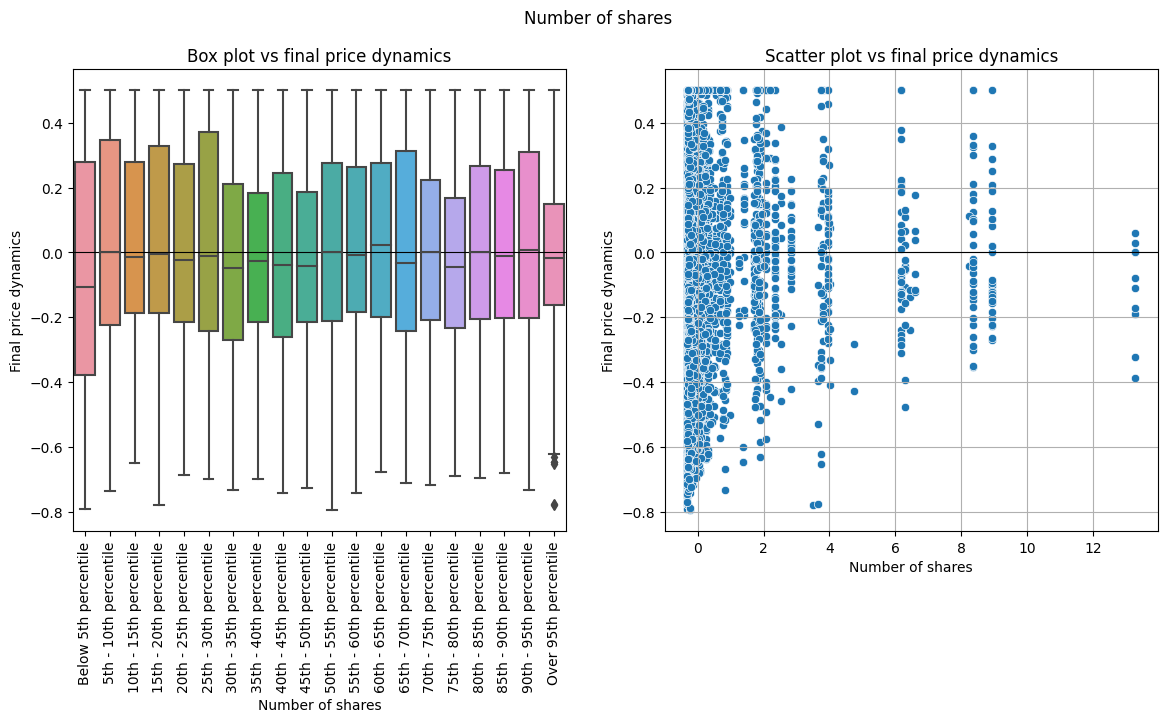

In [166]:
feature_exploration(
    X_train_final.number_of_shares, 'Number of shares', y_train_final.final_price_dynamics
)

In [167]:
rf_model_fix_profile_al.plot(
    [
        et_model_fix_profile_al, bag_model_fix_profile_al, xgb_model_profile_al,
        knn_model_fix_profile_al, stacked_model_small_profile_al, stacked_model_large_profile_al
    ],
    variables = ['number_of_shares']
)

In the **core_capital** variable, we can observe two phenomena. Observations with low (below the 10th percentile, but also between the 15th and 20th percentiles) core capital generally gave a higher chance of making a profit. In contrast, companies with very high core capital (above 2 after scaling), even if they made a loss, it was significantly lower than for observations with lower core capital. Extra trees, XGB and KNN regressors, as well as small stacked models, did best at capturing this.

Percentiles of Core capital:
5th: -0.1597
10th: -0.1595
15th: -0.1591
20th: -0.1587
25th: -0.1579
30th: -0.1572
35th: -0.1564
40th: -0.1554
45th: -0.1536
50th: -0.152
55th: -0.1498
60th: -0.1467
65th: -0.1421
70th: -0.1385
75th: -0.1305
80th: -0.117
85th: -0.0924
90th: -0.0246
95th: 0.24


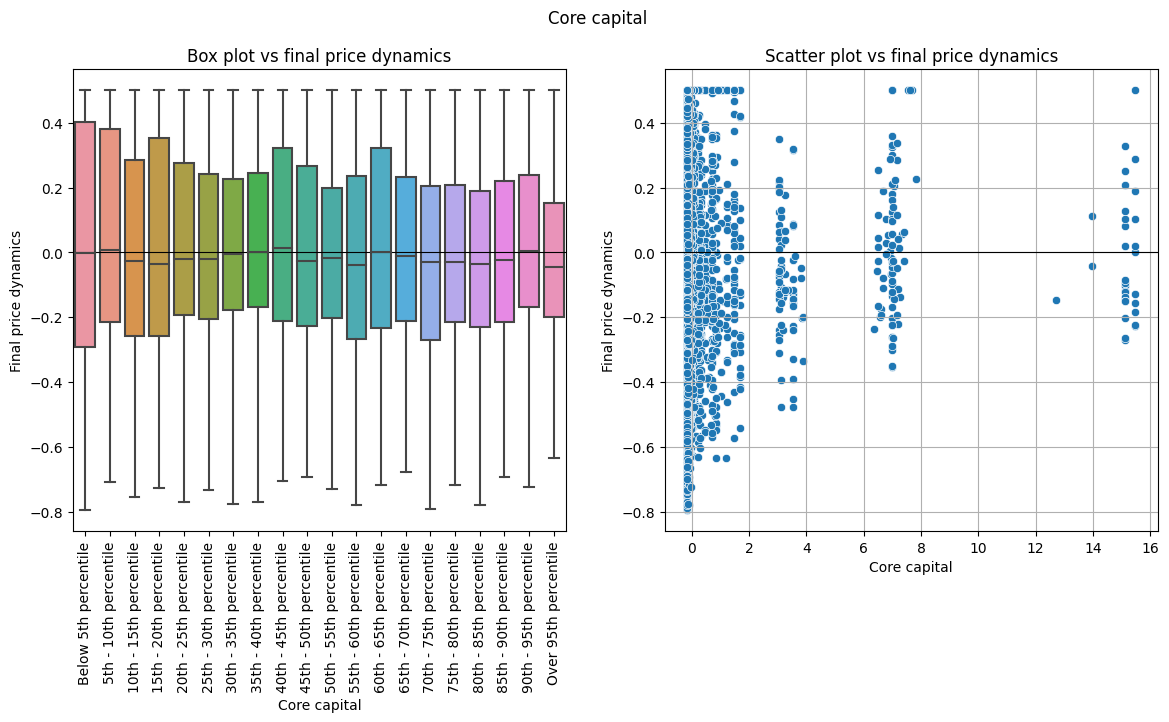

In [168]:
feature_exploration(
    X_train_final.core_capital, 'Core capital', y_train_final.final_price_dynamics
)

In [169]:
rf_model_fix_profile_al.plot(
    [
        et_model_fix_profile_al, bag_model_fix_profile_al, xgb_model_profile_al,
        knn_model_fix_profile_al, stacked_model_small_profile_al, stacked_model_large_profile_al
    ],
    variables = ['core_capital']
)

In the **core_capital_per_share** variable, it can be seen that higher ratio values translate into lower final price dynamics. Besides, there is a noticeable outlier for the value of this variable equal to 36.7. Random forest, bagging, XGB and KNN regressors did not take it into account (the average prediction for the value of the variable above 12 almost does not change), while extra trees regressor and stacked models apparently lower the average prediction due to this single observation.

Percentiles of core capital per share:
10th: -0.2169
20th: -0.2169
30th: -0.2108
40th: -0.1868
50th: -0.1627
60th: -0.1627
70th: -0.1313
80th: -0.0543
90th: 0.2586


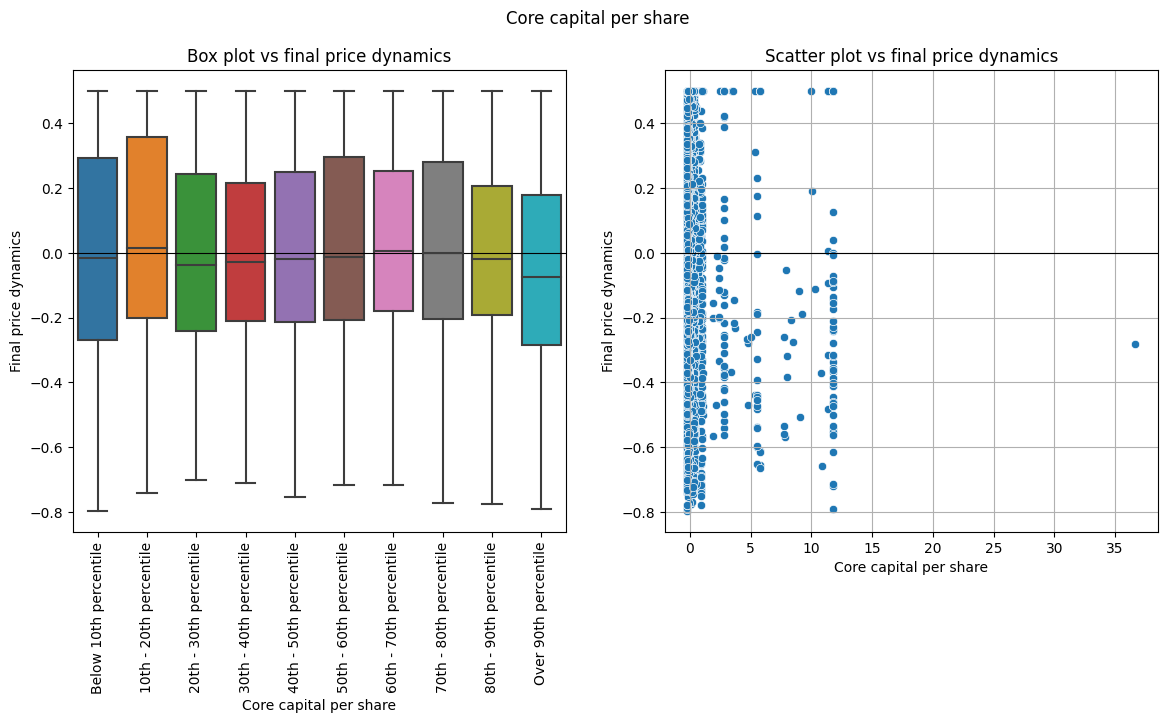

In [183]:
print(f'Percentiles of core capital per share:')
for i in range(10, 100, 10):
    print(f'{i}th: {round(X_train_final.core_capital_per_share.quantile(i / 100), 4)}')

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(
    x=pd.qcut(
        X_train_final.core_capital_per_share,
        10,
        labels=['Below 10th percentile']
        + [f'{i}th - {i+10}th percentile' for i in range(10, 90, 10)]
        + ['Over 90th percentile']
    ),
    y=y_train_final.final_price_dynamics,
    ax=axs[0]
)

sns.scatterplot(
    x=X_train_final.core_capital_per_share,
    y=y_train_final.final_price_dynamics,
    ax=axs[1]
)

axs[0].axhline(0, color='black', linewidth=.8)
axs[1].axhline(0, color='black', linewidth=.8)

for i in range(2):
    axs[i].set_xlabel('Core capital per share')
    axs[i].set_ylabel('Final price dynamics')

axs[0].tick_params(axis='x', labelrotation=90)

plt.suptitle('Core capital per share')
axs[0].set_title('Box plot vs final price dynamics')
axs[1].set_title('Scatter plot vs final price dynamics')

plt.grid()
plt.tight_layout;

In [171]:
rf_model_fix_profile_al.plot(
    [
        et_model_fix_profile_al, bag_model_fix_profile_al, xgb_model_profile_al,
        knn_model_fix_profile_al, stacked_model_small_profile_al, stacked_model_large_profile_al
    ],
    variables = ['core_capital_per_share']
)

Of the final features, only the **supplementary_capital** and **supplementary_capital_per_share** variables had negative values before scaling. The graphs below suggest that the best performing observations were those whose supplementary capital was between the 5th and 10th, as well as the 30th and 35th percentiles. In addition, it is apparent that for very high values of this variable, the lowest final price dynamics do not exceed the -0.4 level. Random forest and bagging regressors had the most trouble capturing this phenomenon.

Percentiles of Supplementary capital:
5th: -0.2169
10th: -0.2144
15th: -0.2115
20th: -0.2095
25th: -0.2067
30th: -0.2033
35th: -0.1998
40th: -0.1958
45th: -0.1902
50th: -0.1841
55th: -0.1774
60th: -0.1682
65th: -0.1576
70th: -0.1431
75th: -0.1278
80th: -0.0942
85th: -0.0496
90th: 0.0754
95th: 0.4252


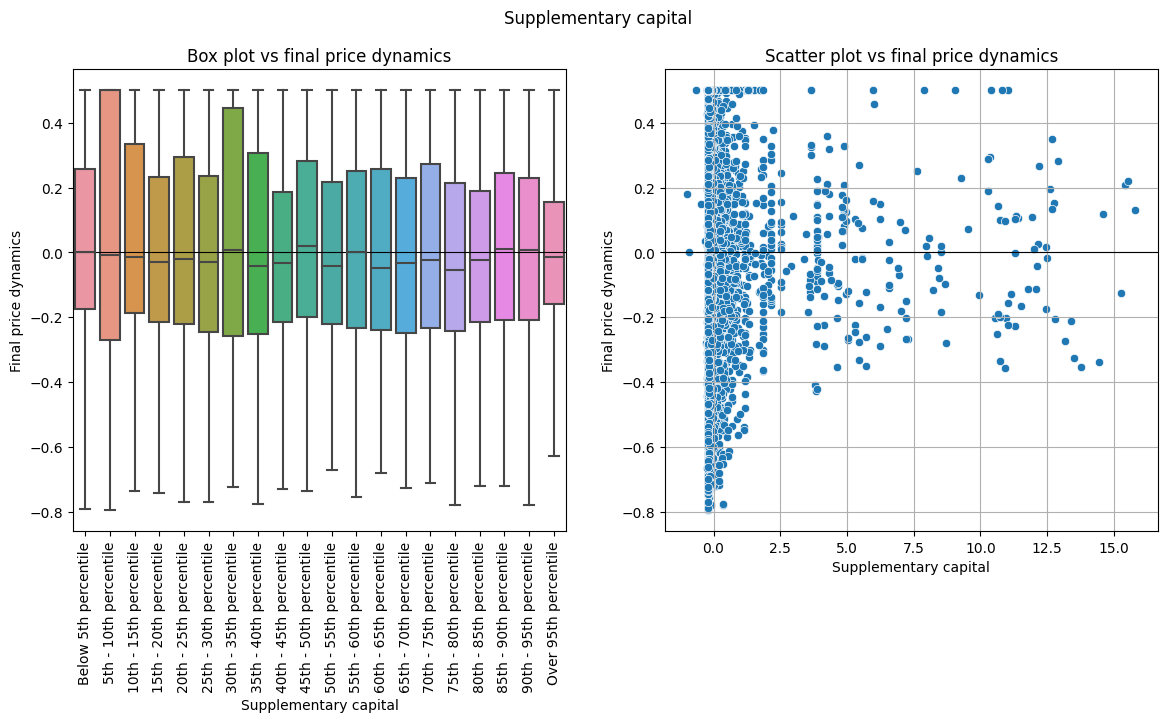

In [184]:
feature_exploration(
    X_train_final.supplementary_capital, 'Supplementary capital', y_train_final.final_price_dynamics
)

In [185]:
rf_model_fix_profile_al.plot(
    [
        et_model_fix_profile_al, bag_model_fix_profile_al, xgb_model_profile_al,
        knn_model_fix_profile_al, stacked_model_small_profile_al, stacked_model_large_profile_al
    ],
    variables = ['supplementary_capital']
)

On the other hand, for the **supplementary_capital_per_share** variable, it is apparent that as its value increases, the final price dynamics decreases. The XGB regressor and small stacked model did the worst at capturing this fact.

Percentiles of Supplementary capital per share:
5th: -0.2106
10th: -0.2073
15th: -0.2025
20th: -0.1971
25th: -0.1918
30th: -0.1841
35th: -0.1771
40th: -0.1713
45th: -0.1643
50th: -0.156
55th: -0.1449
60th: -0.131
65th: -0.114
70th: -0.0955
75th: -0.0737
80th: -0.0365
85th: 0.0175
90th: 0.1
95th: 0.3979


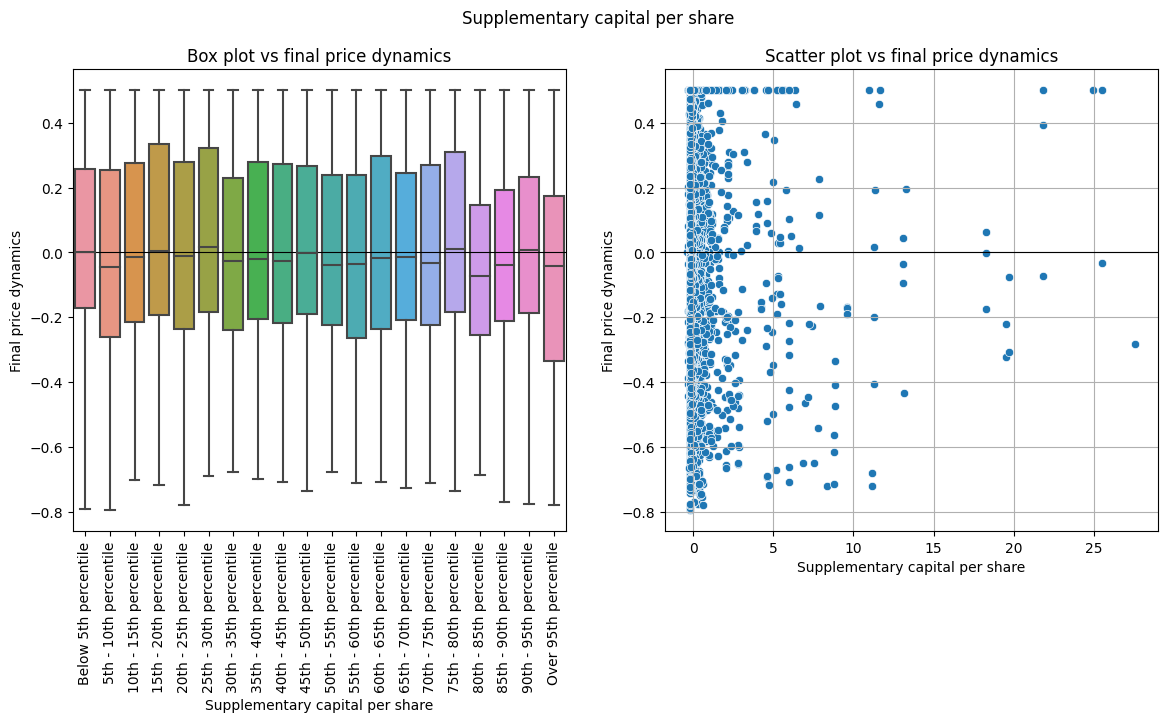

In [186]:
feature_exploration(
    X_train_final.supplementary_capital_per_share, 'Supplementary capital per share',
    y_train_final.final_price_dynamics
)

In [187]:
rf_model_fix_profile_al.plot(
    [
        et_model_fix_profile_al, bag_model_fix_profile_al, xgb_model_profile_al,
        knn_model_fix_profile_al, stacked_model_small_profile_al, stacked_model_large_profile_al
    ],
    variables = ['supplementary_capital_per_share']
)

## Instance-level exploration

The following charts are presenting stacking regressor predictions on the training, validation, test and validation + test sets. Let's look at them from a practical point of view. Using the model to evaluate a given company, we will pay attention to those that can bring the highest possible profit. If the model evaluates a given company poorly, we will most likely not buy its shares - even if the model is wrong about it, the only thing we will lose is a good investment opportunity. So we will focus on analyzing the observations that, according to the model, had the greatest potential for growth.

### Small stacked model

In the case of the small stacked model, we can see that sometimes even observations with negative final price dynamics values from the validation and test sets were considered as investment that would yield a return of more than 40%. In the prediction ranges of 20-30%, 30-40% and 40-50% profit, more than three-quarters of the observations actually yielded any profit. At the same time, if the model predicted a profit greater than 30%, the potential loss was lower than if it predicted any profit.

In [6]:
# Stacked model (small) predictions
X_val_test_final = pd.concat([X_val_final, X_test_final])
y_val_test_final = pd.concat([y_val_final, y_test_final])

train_pred = stacked_model_small.predict(X_train_final)
val_pred = stacked_model_small.predict(X_val_final)
test_pred = stacked_model_small.predict(X_test_final)
val_test_pred = stacked_model_small.predict(X_val_test_final)

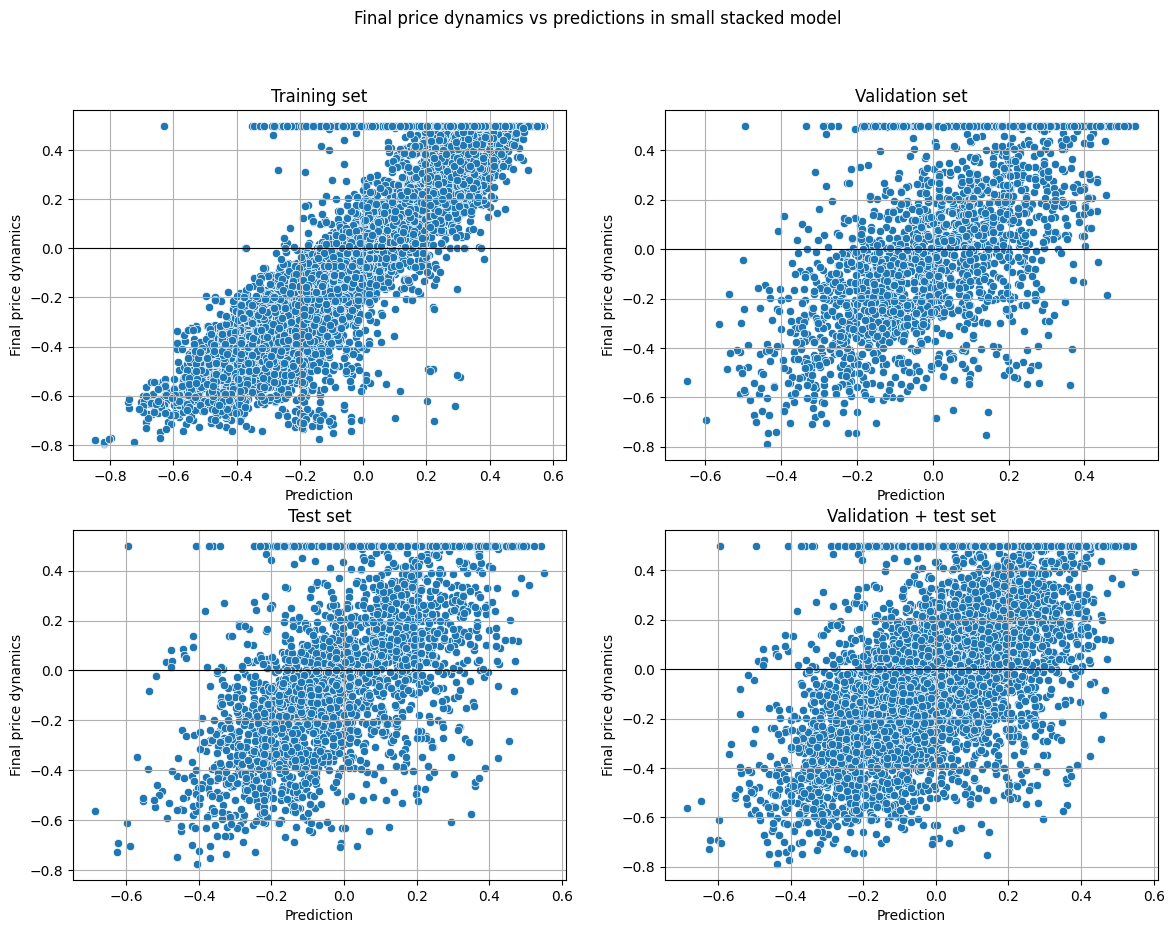

In [66]:
fig, axs = plt.subplots(2, 2, figsize = (14, 10))

sns.scatterplot(
    x=train_pred,
    y=y_train_final.final_price_dynamics,
    ax=axs[0, 0]
)

sns.scatterplot(
    x=val_pred,
    y=y_val_final.final_price_dynamics,
    ax=axs[0, 1]
)

sns.scatterplot(
    x=test_pred,
    y=y_test_final.final_price_dynamics,
    ax=axs[1, 0]
)

sns.scatterplot(
    x=val_test_pred,
    y=y_val_test_final.final_price_dynamics,
    ax=axs[1, 1]
)

for i in range(2):
    for j in range(2):
        axs[i, j].set_ylabel('Final price dynamics')
        axs[i, j].set_xlabel('Prediction')
        axs[i, j].axhline(0, color='black', linewidth=.8)
        axs[i, j].grid()

axs[0, 0].set_title('Training set')
axs[0, 1].set_title('Validation set')
axs[1, 0].set_title('Test set')
axs[1, 1].set_title('Validation + test set')
plt.suptitle('Final price dynamics vs predictions in small stacked model')

plt.tight_layout;

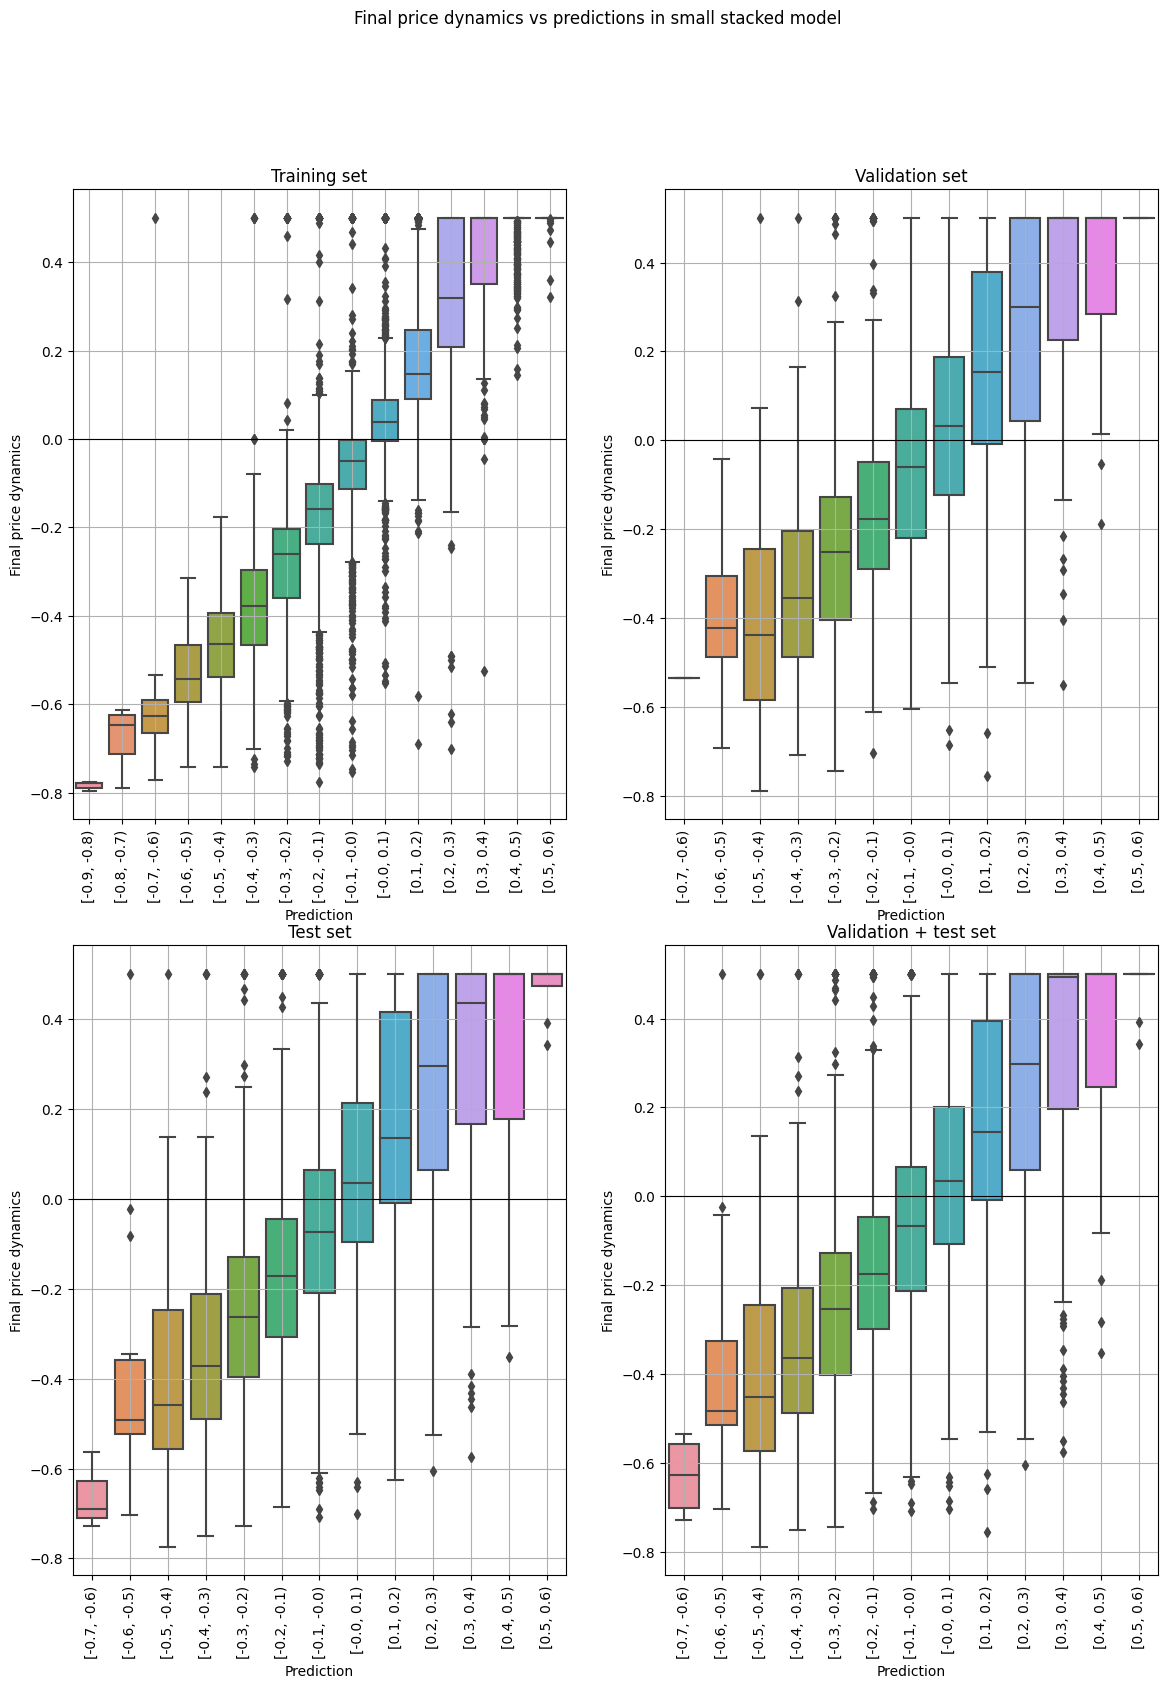

In [107]:
fig, axs = plt.subplots(2, 2, figsize = (14, 18))

sns.boxplot(
    x=pd.cut(
        train_pred,
        bins=np.linspace(-.9, .6, 16),
        labels=[f'[{round(n, 1)}, {round(n + .1, 1)})' for n in np.arange(-.9, .6, .1)],
        right=False
    ),
    y=y_train_final.final_price_dynamics,
    ax=axs[0, 0]
)

sns.boxplot(
    x=pd.cut(
        val_pred,
        bins=np.linspace(-.7, .6, 14),
        labels=[f'[{round(n, 1)}, {round(n + .1, 1)})' for n in np.arange(-.7, .6, .1)],
        right=False
    ),
    y=y_val_final.final_price_dynamics,
    ax=axs[0, 1]
)

sns.boxplot(
    x=pd.cut(
        test_pred,
        bins=np.linspace(-.7, .6, 14),
        labels=[f'[{round(n, 1)}, {round(n + .1, 1)})' for n in np.arange(-.7, .6, .1)],
        right=False
    ),
    y=y_test_final.final_price_dynamics,
    ax=axs[1, 0]
)

sns.boxplot(
    x=pd.cut(
        val_test_pred,
        bins=np.linspace(-.7, .6, 14),
        labels=[f'[{round(n, 1)}, {round(n + .1, 1)})' for n in np.arange(-.7, .6, .1)],
        right=False
    ),
    y=y_val_test_final.final_price_dynamics,
    ax=axs[1, 1]
)

for i in range(2):
    for j in range(2):
        axs[i, j].set_ylabel('Final price dynamics')
        axs[i, j].tick_params(axis='x', labelrotation=90)
        axs[i, j].set_xlabel('Prediction')
        axs[i, j].axhline(0, color='black', linewidth=.8)
        axs[i, j].grid()

axs[0, 0].set_title('Training set')
axs[0, 1].set_title('Validation set')
axs[1, 0].set_title('Test set')
axs[1, 1].set_title('Validation + test set')
plt.suptitle('Final price dynamics vs predictions in small stacked model')

plt.tight_layout;

Let's look at four observations that had negative final price dynamics in the test set, but were predicted by the model to be above 0.4. In the case of the first of these, a relatively high (above the 70th percentile) value of the **core_capital_per_share** variable was the most important for the model, followed by a combination of **supplementary_capital** and **core_capital** variables. Interestingly, the values of these variables were in ranges that did not stand out significantly. On the other hand, the **price** variable lowered the prediction the most - the value for this observation was relatively high (between the 75th and 80th percentile).

In [146]:
overestimated_small_test = pd.concat(
    [
        X_test_final,
        y_test_final,
        pd.DataFrame(test_pred, index=y_test_final.index, columns=['fpd_prediction'])
    ],
    axis=1
)
overestimated_small_test = overestimated_small_test[
    (y_test_final.final_price_dynamics < 0) &
    (pd.DataFrame(test_pred, index=y_test_final.index).iloc[:, 0] > .4)
]
overestimated_small_test

capitalization  core_capital  number_of_shares   price  \
2135         -0.2348       -0.1561           -0.3050 -0.0596   
8385          0.2500        0.0430            0.8692 -0.1136   
710          -0.1796       -0.1545           -0.3037  0.1951   
6517         -0.2288       -0.1236           -0.2185 -0.1269   

      supplementary_capital  core_capital_per_share  \
2135                -0.1992                 -0.1025   
8385                -0.1516                 -0.1605   
710                 -0.1883                 -0.0724   
6517                -0.0883                 -0.0881   

      supplementary_capital_per_share  final_price_dynamics  fpd_prediction  
2135                          -0.0420               -0.0614          0.4239  
8385                          -0.2042               -0.3520          0.4234  
710                            0.0349               -0.2830          0.4547  
6517                          -0.0583               -0.0828          0.4673

In [149]:
int_break_down = []
for i in range(4):
    int_break_down.append(
        stacked_model_small_exp.predict_parts(
            overestimated_small_test.iloc[i, :7], type='break_down_interactions'
        )
    )

In [188]:
print(f'Analysis of observation {overestimated_small_test.index[0]}')
print(f'Prediction: {overestimated_small_test.fpd_prediction.iloc[0]}')
print(f'True value: {overestimated_small_test.final_price_dynamics.iloc[0]}')
int_break_down[0].plot()

Analysis of observation 2135
Prediction: 0.4238942861557007
True value: -0.06138517502153869


Another observation obtained its prediction mainly from the values of the **supplementary_capital_per_share**, **supplementary_capital** and **core_capital_per_share** variables, although their values came from ranges that did not stand out. In contrast, the relatively high value of capitalization lowered the prediction by almost 0.12.

In [189]:
print(f'Analysis of observation {overestimated_small_test.index[1]}')
print(f'Prediction: {overestimated_small_test.fpd_prediction.iloc[1]}')
print(f'True value: {overestimated_small_test.final_price_dynamics.iloc[1]}')
int_break_down[1].plot()

Analysis of observation 8385
Prediction: 0.4233657419681549
True value: -0.35203061286328974


For the next observation, the variables **core_capital**, **supplementary_capital** and **number_of_shares** proved to be key. Of note, however, is the high price, which lowered the prediction by 0.065.

In [190]:
print(f'Analysis of observation {overestimated_small_test.index[2]}')
print(f'Prediction: {overestimated_small_test.fpd_prediction.iloc[2]}')
print(f'True value: {overestimated_small_test.final_price_dynamics.iloc[2]}')
int_break_down[2].plot()

Analysis of observation 710
Prediction: 0.4547424614429474
True value: -0.2829965654910302


In the last observation, the most important variables were **number_of_shares**, **core_capital_per_share**, **core_capital** and **capitalization**. Interestingly, the rather unremarkable values of the first three variables overshadowed the fairly high capitalization.

In [191]:
print(f'Analysis of observation {overestimated_small_test.index[3]}')
print(f'Prediction: {overestimated_small_test.fpd_prediction.iloc[3]}')
print(f'True value: {overestimated_small_test.final_price_dynamics.iloc[3]}')
int_break_down[3].plot()

Analysis of observation 6517
Prediction: 0.46728870272636414
True value: -0.08276961435490798


### Large stacked model

The large stacked model generally repeats previous conclusions. So we will again check the negative final price dynamics, which the model overestimated. In addition, there is one interesting observation on the validation set, whose final price dynamics was -0.55, but the model predicted a value of 0.65.

In [7]:
# Stacked model (large) predictions
train_pred_l = stacked_model_large.predict(X_train_final)
val_pred_l = stacked_model_large.predict(X_val_final)
test_pred_l = stacked_model_large.predict(X_test_final)
val_test_pred_l = stacked_model_large.predict(X_val_test_final)

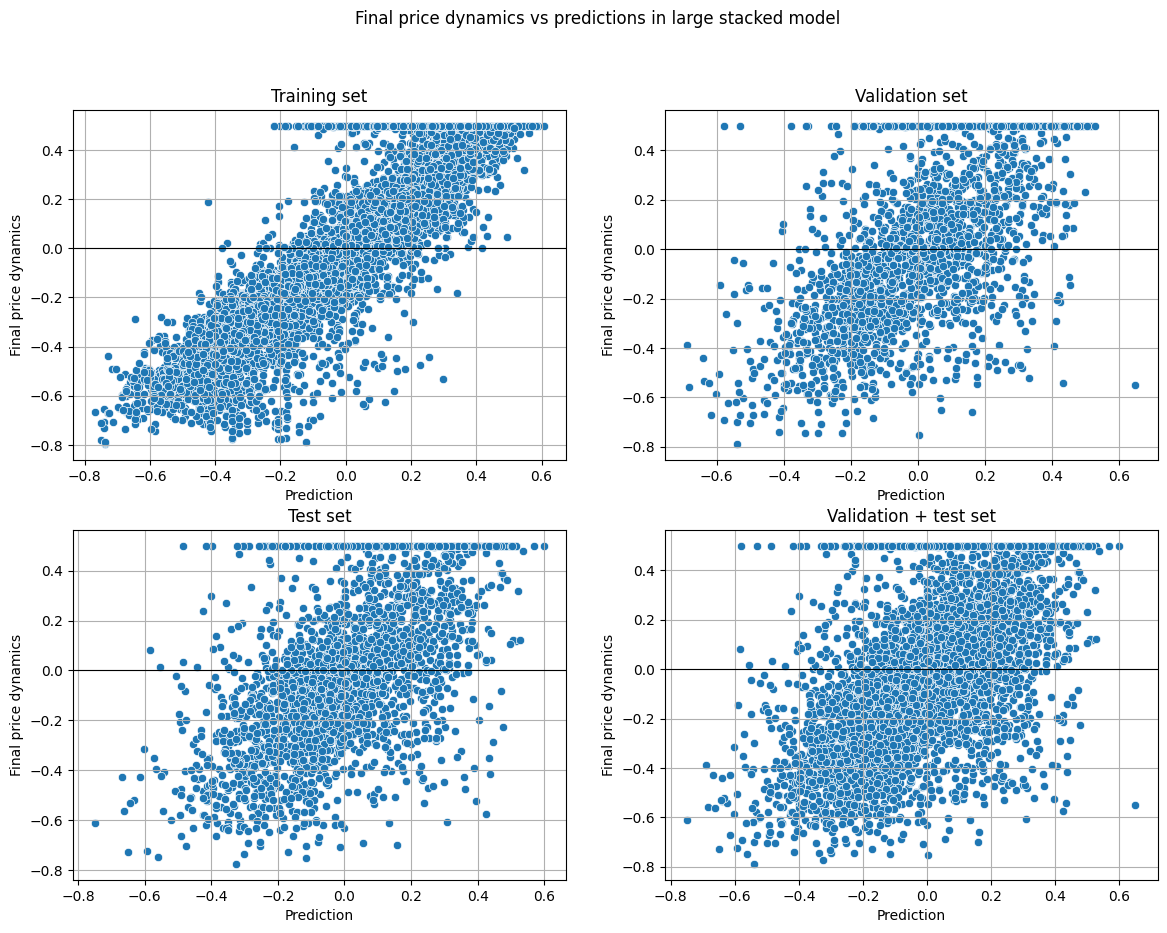

In [71]:
fig, axs = plt.subplots(2, 2, figsize = (14, 10))

sns.scatterplot(
    x=train_pred_l,
    y=y_train_final.final_price_dynamics,
    ax=axs[0, 0]
)

sns.scatterplot(
    x=val_pred_l,
    y=y_val_final.final_price_dynamics,
    ax=axs[0, 1]
)

sns.scatterplot(
    x=test_pred_l,
    y=y_test_final.final_price_dynamics,
    ax=axs[1, 0]
)

sns.scatterplot(
    x=val_test_pred_l,
    y=y_val_test_final.final_price_dynamics,
    ax=axs[1, 1]
)

for i in range(2):
    for j in range(2):
        axs[i, j].set_ylabel('Final price dynamics')
        axs[i, j].set_xlabel('Prediction')
        axs[i, j].axhline(0, color='black', linewidth=.8)
        axs[i, j].grid()

axs[0, 0].set_title('Training set')
axs[0, 1].set_title('Validation set')
axs[1, 0].set_title('Test set')
axs[1, 1].set_title('Validation + test set')
plt.suptitle('Final price dynamics vs predictions in large stacked model')

plt.tight_layout;

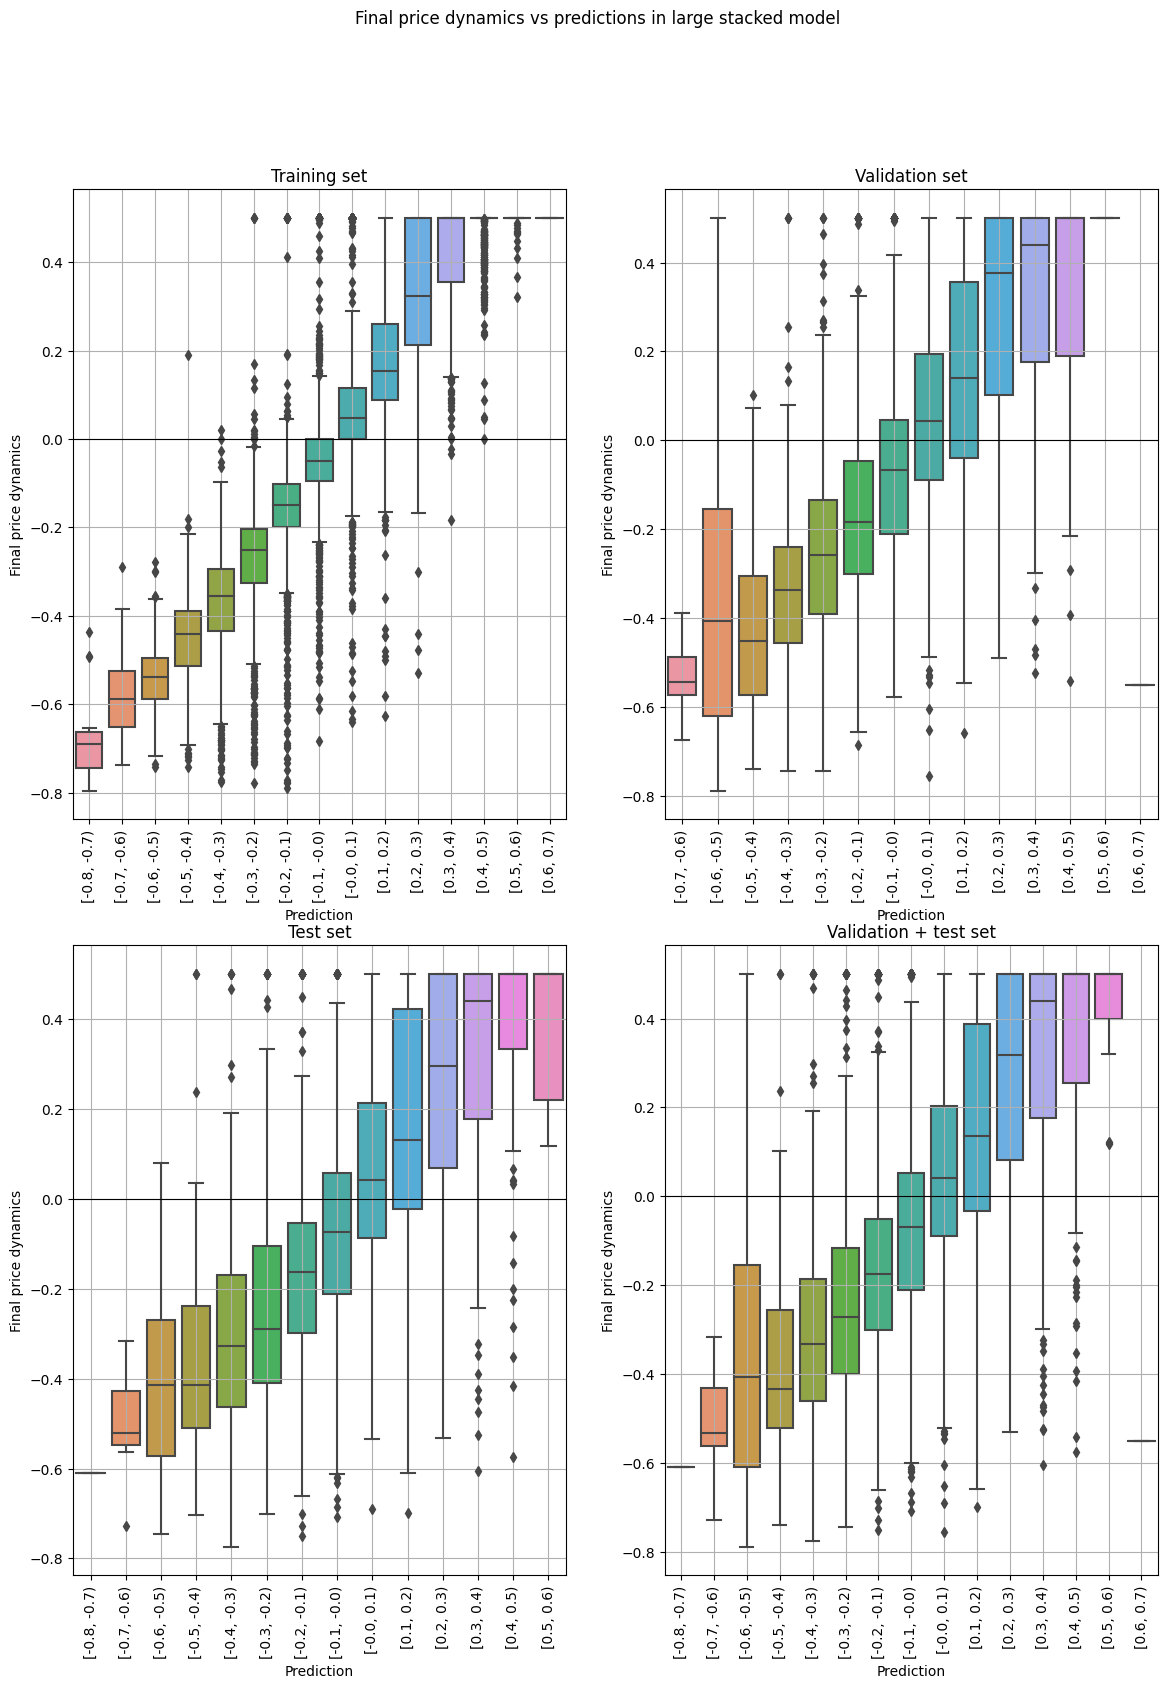

In [123]:
fig, axs = plt.subplots(2, 2, figsize = (14, 18))

sns.boxplot(
    x=pd.cut(
        train_pred_l,
        bins=np.linspace(-.8, .7, 16),
        labels=[f'[{round(n, 1)}, {round(n + .1, 1)})' for n in np.arange(-.8, .7, .1)],
        right=False
    ),
    y=y_train_final.final_price_dynamics,
    ax=axs[0, 0]
)

sns.boxplot(
    x=pd.cut(
        val_pred_l,
        bins=np.linspace(-.7, .7, 15),
        labels=[f'[{round(n, 1)}, {round(n + .1, 1)})' for n in np.arange(-.7, .7, .1)],
        right=False
    ),
    y=y_val_final.final_price_dynamics,
    ax=axs[0, 1]
)

sns.boxplot(
    x=pd.cut(
        test_pred_l,
        bins=np.linspace(-.8, .6, 15),
        labels=[f'[{round(n, 1)}, {round(n + .1, 1)})' for n in np.arange(-.8, .6, .1)],
        right=False
    ),
    y=y_test_final.final_price_dynamics,
    ax=axs[1, 0]
)

sns.boxplot(
    x=pd.cut(
        val_test_pred_l,
        bins=np.linspace(-.8, .7, 16),
        labels=[f'[{round(n, 1)}, {round(n + .1, 1)})' for n in np.arange(-.8, .7, .1)],
        right=False
    ),
    y=y_val_test_final.final_price_dynamics,
    ax=axs[1, 1]
)

for i in range(2):
    for j in range(2):
        axs[i, j].set_ylabel('Final price dynamics')
        axs[i, j].tick_params(axis='x', labelrotation=90)
        axs[i, j].set_xlabel('Prediction')
        axs[i, j].axhline(0, color='black', linewidth=.8)
        axs[i, j].grid()

axs[0, 0].set_title('Training set')
axs[0, 1].set_title('Validation set')
axs[1, 0].set_title('Test set')
axs[1, 1].set_title('Validation + test set')
plt.suptitle('Final price dynamics vs predictions in large stacked model')

plt.tight_layout;

Large stacked model overestimated 8 observations that resulted in a loss. We will focus on three of them (8385, 15360 and 10386) for which the difference between the true value and the predicted value was the largest.

In [198]:
overestimated_large_test = pd.concat(
    [
        X_test_final,
        y_test_final,
        pd.DataFrame(test_pred_l, index=y_test_final.index, columns=['fpd_prediction'])
    ],
    axis=1
)
overestimated_large_test = overestimated_large_test[
    (y_test_final.final_price_dynamics < 0) &
    (pd.DataFrame(test_pred_l, index=y_test_final.index).iloc[:, 0] > .4)
]
overestimated_large_test

capitalization  core_capital  number_of_shares   price  \
4406          -0.2383       -0.1557           -0.2902 -0.1124   
8385           0.2500        0.0430            0.8692 -0.1136   
15116         -0.2221       -0.1174           -0.2657 -0.1057   
15360         -0.2335       -0.1064           -0.1839 -0.1328   
1882          -0.2476       -0.1596           -0.2858 -0.1355   
10386         -0.2455       -0.1492           -0.1629 -0.1390   
8027           0.2416        0.0430            0.8692 -0.1141   
6517          -0.2288       -0.1236           -0.2185 -0.1269   

       supplementary_capital  core_capital_per_share  \
4406                 -0.0877                 -0.1627   
8385                 -0.1516                 -0.1605   
15116                -0.1352                  0.0781   
15360                -0.1361                 -0.0760   
1882                 -0.2129                 -0.2169   
10386                -0.0982                 -0.1972   
8027                 -0.1516                 -0.1605   
6517                 -0.0883                 -0.0881   

       supplementary_capital_per_share  final_price_dynamics  fpd_prediction  
4406                            0.3459               -0.1998          0.4053  
8385                           -0.2042               -0.3520          0.4350  
15116                          -0.0255               -0.2857          0.4473  
15360                          -0.1397               -0.5748          0.4248  
1882                           -0.1956               -0.2255          0.4768  
10386                          -0.1206               -0.4164          0.4367  
8027                           -0.2042               -0.1426          0.4350  
6517                           -0.0583               -0.0828          0.4714

In [199]:
int_break_down_l = []
for i in [1, 3, 5]:
    int_break_down_l.append(
        stacked_model_large_exp.predict_parts(
            overestimated_large_test.iloc[i, :7], type='break_down_interactions'
        )
    )

The first of the observations has already caught our attention in the case of the small stacked model - again, the prediction was reduced quite significantly by high capitalization.

In [217]:
print(f'Analysis of observation {overestimated_large_test.index[1]}')
print(f'Prediction: {overestimated_large_test.fpd_prediction.iloc[1]}')
print(f'True value: {overestimated_large_test.final_price_dynamics.iloc[1]}')
int_break_down_l[0].plot()

Analysis of observation 8385
Prediction: 0.43497297167778015
True value: -0.35203061286328974


The second observation depended mainly on **core_capital_per_share** and **supplementary_capital**. In addition, **core_capital** reduced the prediction value by 0.05. However, the values of these variables did not stand out.

In [218]:
print(f'Analysis of observation {overestimated_large_test.index[3]}')
print(f'Prediction: {overestimated_large_test.fpd_prediction.iloc[3]}')
print(f'True value: {overestimated_large_test.final_price_dynamics.iloc[3]}')
int_break_down_l[1].plot()

Analysis of observation 15360
Prediction: 0.42475348711013794
True value: -0.5748049967743828


In the last observation, the most interesting is the impact of the value of the variable **price** - it is very low (almost equal to the 5th percentile). Despite this, the model erred significantly in evaluating this observation.

In [219]:
print(f'Analysis of observation {overestimated_large_test.index[5]}')
print(f'Prediction: {overestimated_large_test.fpd_prediction.iloc[5]}')
print(f'True value: {overestimated_large_test.final_price_dynamics.iloc[5]}')
int_break_down_l[2].plot()

Analysis of observation 10386
Prediction: 0.43669724464416504
True value: -0.41637459694378237


Finally, we will check an unusual observation from the validation set, which, according to the model, should have yielded a profit of 65%, although it yielded a loss of about 55%. This prediction was most positively affected by very high core capital and capitalization (both above the 95th percentile), while the value of the prediction was lowered by the high price (between the 85th and 90th percentiles).

In [14]:
val_obs_bd = stacked_model_large_exp.predict_parts(
    X_val_final.iloc[900, :], type='break_down_interactions'
)
val_obs_bd.plot()

# Comparison with the gurus' strategies

As a final step, let's check how both stacked models performed against gurus' strategies. In the analysis, we will use the combined validation and test sets to have a sufficient number of observations.

One of the assumptions made in analysis of gurus' strategies was the criterion of portfolio size - in at least 80% of the quarters analyzed, we had to have at least 10 companies in the portfolio. For both models, this condition will be met if we invest only in companies whose growth the model values at at least 30%. This will be the equivalent of a buy signal from gurus' strategies.

In [8]:
prediction_df = pd.concat(
    [
        y_val_test_final,
        pd.DataFrame(val_test_pred, columns=['fpd_small_pred'], index=y_val_test_final.index),
        pd.DataFrame(val_test_pred_l, columns=['fpd_large_pred'], index=y_val_test_final.index)
    ],
    axis=1
)

prediction_df = prediction_df.merge(
    dataset_preproc.filter(
        ['quarter', 'sold_in_q', 'interesting_investment', 'final_wig_dynamics']
    ),
    left_index=True,
    right_index=True
)

In [10]:
portfolio_size_small_df = pd.DataFrame(index=sorted(dataset_preproc.quarter.unique()))
portfolio_size_large_df = pd.DataFrame(index=sorted(dataset_preproc.quarter.unique()))

for i in range(0, 65, 5):
    temp_small = pd.DataFrame(
        pd.Series(
            prediction_df[
                prediction_df.fpd_small_pred > i / 100
            ].groupby('quarter').quarter.count().reindex(portfolio_size_small_df.index).fillna(0),
            name='buy'
        )
    )
    temp_small['sell'] = pd.Series(
        prediction_df[
            prediction_df.fpd_small_pred > i / 100
        ].groupby('sold_in_q').sold_in_q.count().reindex(portfolio_size_small_df.index).fillna(0),
    )

    portfolio_size_small_df[f'Treshold: {i}%'] = (
        temp_small.buy - temp_small.sell
    ).cumsum().astype(int)
    
    temp_large = pd.DataFrame(
        pd.Series(
            prediction_df[
                prediction_df.fpd_large_pred > i / 100
            ].groupby('quarter').quarter.count().reindex(portfolio_size_large_df.index).fillna(0),
            name='buy'
        )
    )
    temp_large['sell'] = pd.Series(
        prediction_df[
            prediction_df.fpd_large_pred > i / 100
        ].groupby('sold_in_q').sold_in_q.count().reindex(portfolio_size_large_df.index).fillna(0),
    )

    portfolio_size_large_df[f'Treshold: {i}%'] = (
        temp_large.buy - temp_large.sell
    ).cumsum().astype(int)

In [10]:
print('Percentage of quarters with portfolio size over 10 in small stacked model:')
100 * (
    portfolio_size_small_df[portfolio_size_small_df >= 10].count()
    / portfolio_size_small_df.shape[0]
)

Percentage of quarters with portfolio size over 10 in small stacked model:


Treshold: 0%    94.2029
Treshold: 5%    94.2029
Treshold: 10%   94.2029
Treshold: 15%   94.2029
Treshold: 20%   91.3043
Treshold: 25%   85.5072
Treshold: 30%   81.1594
Treshold: 35%   65.2174
Treshold: 40%   31.8841
Treshold: 45%    0.0000
Treshold: 50%    0.0000
Treshold: 55%    0.0000
Treshold: 60%    0.0000
dtype: float64

In [11]:
print('Percentage of quarters with portfolio size over 10 in large stacked model:')
100 * (
    portfolio_size_large_df[portfolio_size_large_df >= 10].count()
    / portfolio_size_large_df.shape[0]
)

Percentage of quarters with portfolio size over 10 in large stacked model:


Treshold: 0%    94.2029
Treshold: 5%    94.2029
Treshold: 10%   94.2029
Treshold: 15%   94.2029
Treshold: 20%   91.3043
Treshold: 25%   86.9565
Treshold: 30%   79.7101
Treshold: 35%   71.0145
Treshold: 40%   40.5797
Treshold: 45%    1.4493
Treshold: 50%    0.0000
Treshold: 55%    0.0000
Treshold: 60%    0.0000
dtype: float64

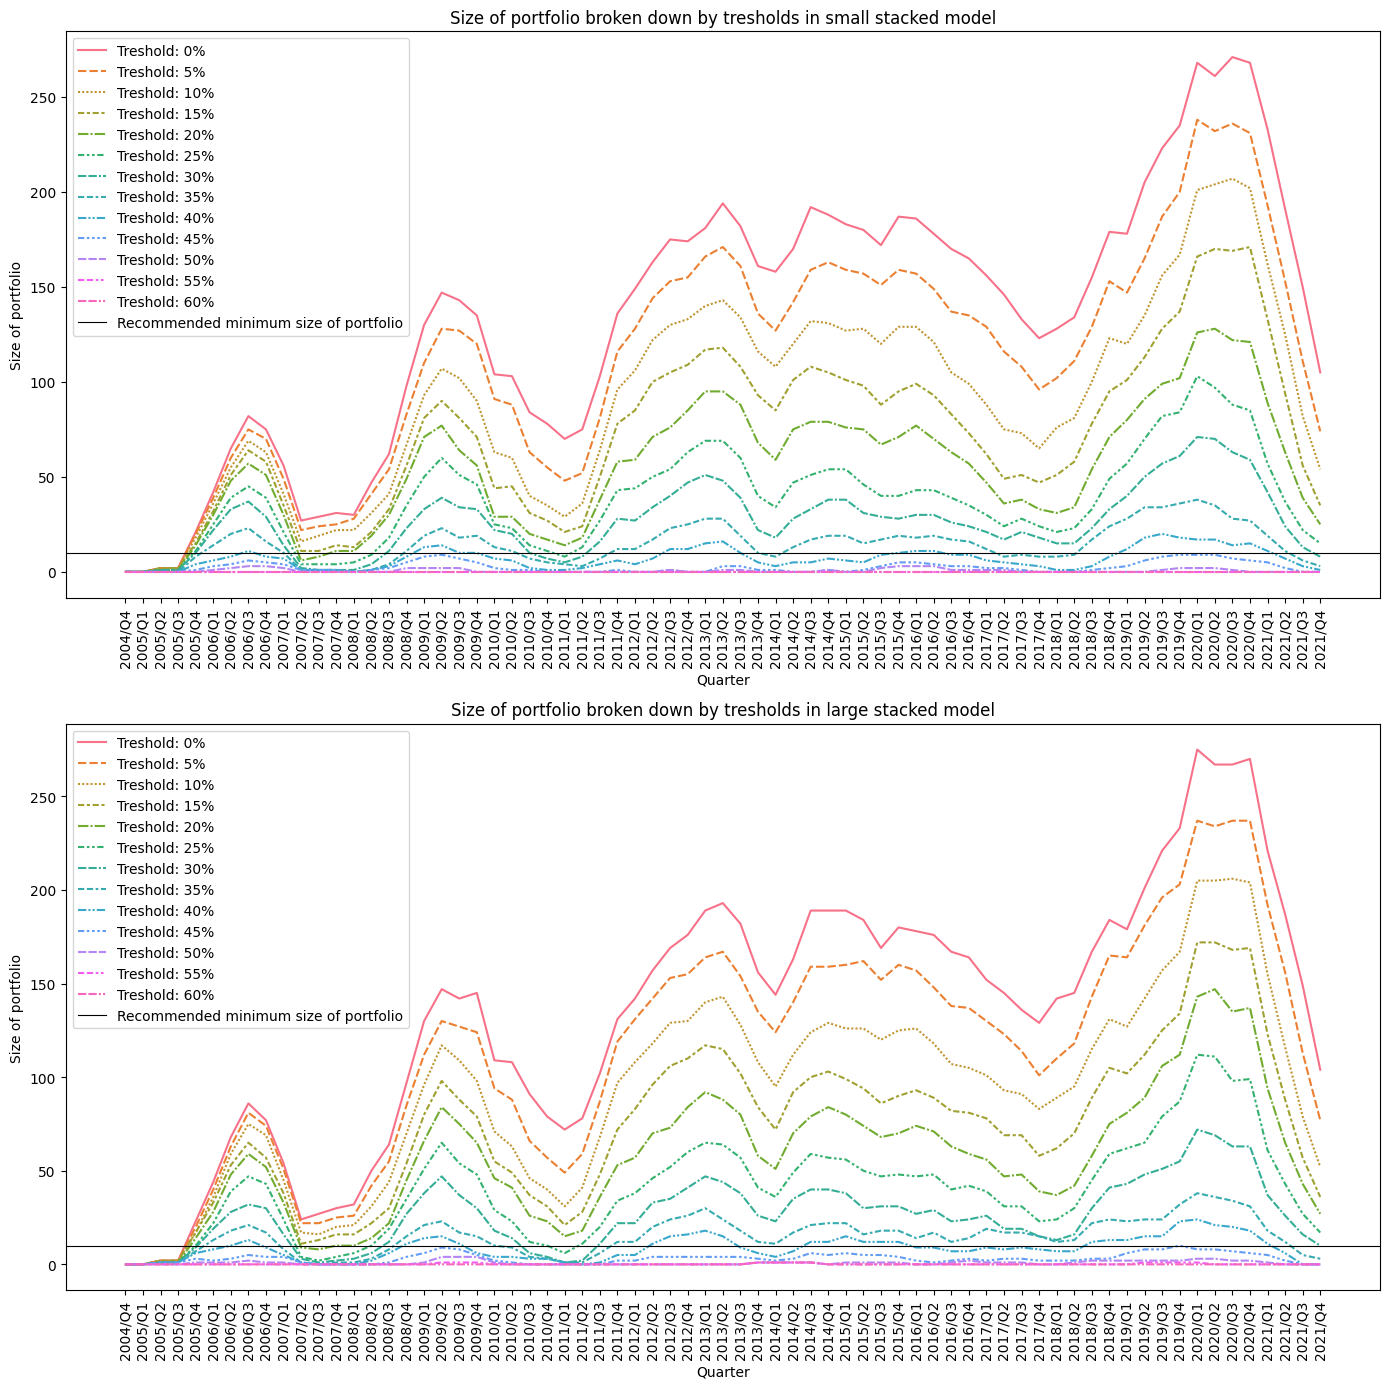

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(14, 14))

sns.lineplot(
    data=portfolio_size_small_df,
    ax=axs[0]
)

sns.lineplot(
    data=portfolio_size_large_df,
    ax=axs[1]
)

for i in range(2):
    axs[i].axhline(
        10, color='black', linewidth=.8,
        label='Recommended minimum size of portfolio'
    )    
    axs[i].tick_params(axis='x', labelrotation=90)
    axs[i].set_xlabel('Quarter')
    axs[i].set_ylabel('Size of portfolio')
    handles, _ = axs[i].get_legend_handles_labels()
    axs[i].legend(
        handles = handles,
        labels = list(portfolio_size_small_df.columns) + ['Recommended minimum size of portfolio']
    )

axs[0].set_title('Size of portfolio broken down by tresholds in small stacked model')
axs[1].set_title('Size of portfolio broken down by tresholds in large stacked model')

plt.tight_layout();

In [12]:
prediction_df['buy_small'] = np.where(prediction_df.fpd_small_pred > .3, 'Yes', 'No')
prediction_df['buy_large'] = np.where(prediction_df.fpd_large_pred > .3, 'Yes', 'No')

## Small stacked model

The dataset analyzed included 803 observations that made at least 50% profit within a year of purchase, and the small stacked model valued their profit at at least 30% in 268 cases. However, the model did very well in bypassing companies that made a loss. There were 2520 in the analyzed set, while only 38 of them (1.5%) according to the model would have yielded a profit higher than 30%.

Small stacked model won with gurus' strategies on every field. It indicated the smallest percentage of buy signals that ended in loss (8%) and the largest percentage of signals that ended in profit at 50% (54%). The model beat the zero effort strategy in 58 quarters, ultimately achieving an average investment return of 29.45%.

In [14]:
print('\nInteresting companies in small stacked model:')
print(prediction_df.interesting_investment.value_counts())
print(
    f'\nNumber of buy signals from small stacked model: {prediction_df.buy_small.value_counts()[1]}'
)


Interesting companies in small stacked model:
No       2520
Maybe    1539
Yes       803
Name: interesting_investment, dtype: int64

Number of buy signals from small stacked model: 495


In [15]:
pd.crosstab(
    prediction_df.interesting_investment,
    prediction_df.buy_small,
    rownames=['Interesting investment:'],
    colnames=['Buy signal from small stacked model']
).reindex(['No', 'Maybe', 'Yes'], axis=0)

Buy signal from small stacked model    No  Yes
Interesting investment:                       
No                                   2482   38
Maybe                                1350  189
Yes                                   535  268

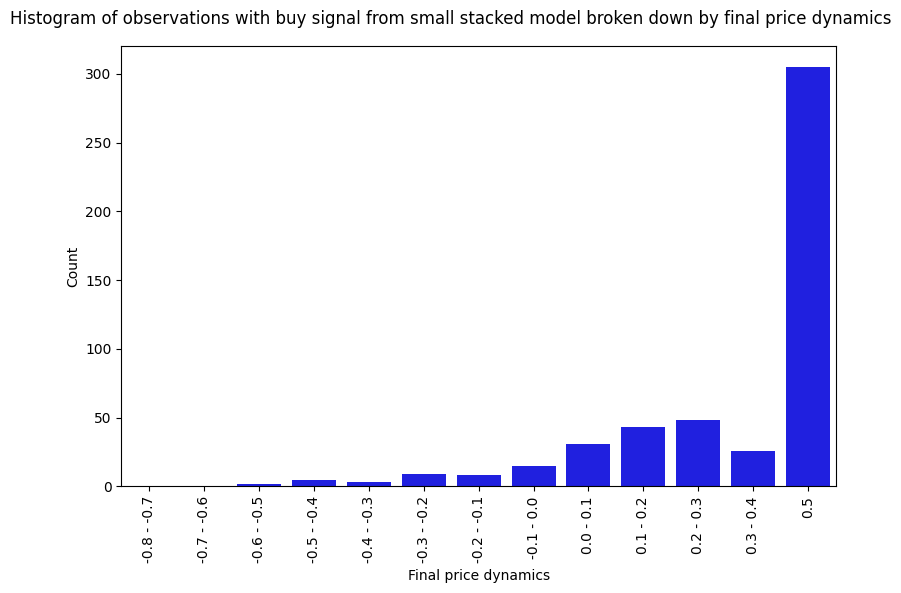

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.countplot(
    x=pd.cut(
        prediction_df[prediction_df.buy_small == 'Yes'].final_price_dynamics,
        bins=list(np.linspace(-.8, .5, 14)),
        labels=[f'{round(i, 1)} - {round(i + .1, 1)}' for i in np.linspace(-.8, .3, 12)] + ['0.5']
    ),
    color='blue',
    ax=ax
)

ax.tick_params(axis='x', labelrotation=90)

ax.set_xlabel('Final price dynamics')
ax.set_ylabel('Count')

plt.suptitle(
    'Histogram of observations with buy signal from '\
    'small stacked model broken down by final price dynamics'
)

plt.tight_layout();

In [17]:
small_return_df = pd.DataFrame({
    'Zero effort strategy':dataset_preproc.groupby('quarter').final_wig_dynamics.mean(),
    'Small stacked model':prediction_df[
        prediction_df.buy_small == 'Yes'
    ].groupby('quarter').final_price_dynamics.mean()
})

quarters_strat = small_return_df['Small stacked model'].count()

portfolio_size = portfolio_size_small_df[
    portfolio_size_small_df['Treshold: 30%'] >= 10
]['Treshold: 30%'].count()

quarters_profit_strat_var = small_return_df[
    small_return_df['Small stacked model'] > 0
]['Small stacked model'].count()

quarters_profit_wig = small_return_df[
    small_return_df['Zero effort strategy'] > 0
]['Zero effort strategy'].count()

quarters_perform_strat_var = small_return_df[
    small_return_df['Small stacked model'] > small_return_df['Zero effort strategy']
]['Small stacked model'].count()

avg_strategy_return_var = (100 * small_return_df['Small stacked model'].mean()).round(2)

avg_wig_return =(100 * small_return_df['Zero effort strategy'].mean()).round(2)

print(f'Number of quarters with buy signal from small stacked model: {quarters_strat}')
print(f'Number of quarters with sufficient portfolio size: {portfolio_size}')
print(f'Number of profitable quarters using small stacked model: {quarters_profit_strat_var}')
print(f'Number of profitable quarters using zero effort strategy: {quarters_profit_wig}')
print(
    'Number of quarters in which '\
    f'small stacked model outperformed zero effort strategy: {quarters_perform_strat_var}'
)
print(f'Average return on small stacked model: {avg_strategy_return_var}%')
print(f'Average return on zero effort strategy: {avg_wig_return}%')

Number of quarters with buy signal from small stacked model: 62
Number of quarters with sufficient portfolio size: 56
Number of profitable quarters using small stacked model: 58
Number of profitable quarters using zero effort strategy: 43
Number of quarters in which small stacked model outperformed zero effort strategy: 58
Average return on small stacked model: 29.45%
Average return on zero effort strategy: 5.6%


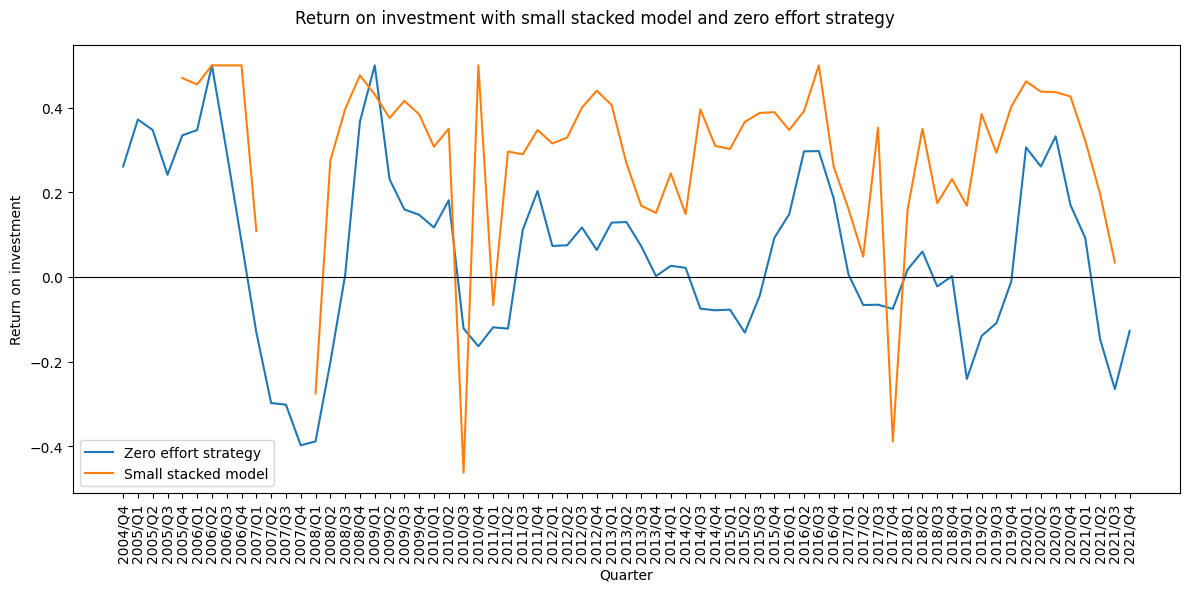

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))

plt.plot(
    small_return_df.index,
    small_return_df
)

ax.axhline(0, color='black', linewidth=.8)

ax.tick_params(axis='x', labelrotation=90)

ax.tick_params(axis='x', labelrotation=90)

ax.set_ylabel('Return on investment')
ax.set_xlabel('Quarter')

ax.legend(labels=['Zero effort strategy', 'Small stacked model'])

plt.suptitle('Return on investment with small stacked model and zero effort strategy')

plt.tight_layout();

## Large stacked model

The dataset analyzed included 803 observations that made at least 50% profit within a year of purchase, and the large stacked model valued their profit at at least 30% in 254 cases. However, the model did very well in bypassing companies that made a loss. There were 2520 in the analyzed set, while only 53 of them (2.1%) according to the model would have yielded a profit higher than 30%. These results are slightly worse than the small stacked model.

Large stacked model also won with gurus' strategies on every field. It indicated the percentage of buy signals that ended in loss equal to 11% and the percentage of signals that ended in profit at 50% equal to 51%. The model beat the zero effort strategy in 56 quarters, ultimately achieving an average investment return of 27%. Again, these results were slightly worse than the small stacked model.


In [19]:
print('\nInteresting companies in large stacked model:')
print(prediction_df.interesting_investment.value_counts())
print(
    f'\nNumber of buy signals from large stacked model: {prediction_df.buy_large.value_counts()[1]}'
)


Interesting companies in large stacked model:
No       2520
Maybe    1539
Yes       803
Name: interesting_investment, dtype: int64

Number of buy signals from large stacked model: 494


In [20]:
pd.crosstab(
    prediction_df.interesting_investment,
    prediction_df.buy_large,
    rownames=['Interesting investment:'],
    colnames=['Buy signal from large stacked model']
).reindex(['No', 'Maybe', 'Yes'], axis=0)

Buy signal from large stacked model    No  Yes
Interesting investment:                       
No                                   2467   53
Maybe                                1352  187
Yes                                   549  254

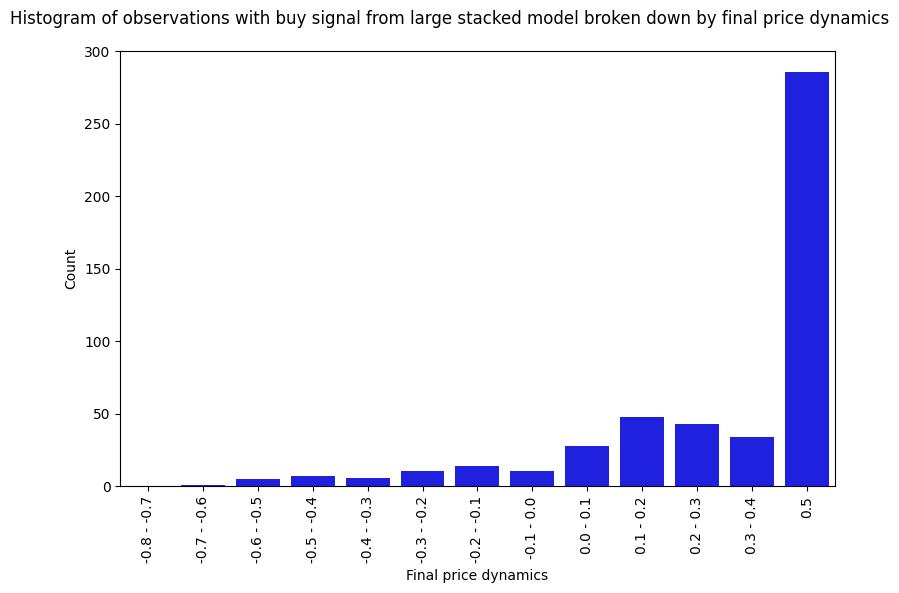

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.countplot(
    x=pd.cut(
        prediction_df[prediction_df.buy_large == 'Yes'].final_price_dynamics,
        bins=list(np.linspace(-.8, .5, 14)),
        labels=[f'{round(i, 1)} - {round(i + .1, 1)}' for i in np.linspace(-.8, .3, 12)] + ['0.5']
    ),
    color='blue',
    ax=ax
)

ax.tick_params(axis='x', labelrotation=90)

ax.set_xlabel('Final price dynamics')
ax.set_ylabel('Count')

plt.suptitle(
    'Histogram of observations with buy signal from '\
    'large stacked model broken down by final price dynamics'
)

plt.tight_layout();

In [22]:
large_return_df = pd.DataFrame({
    'Zero effort strategy':dataset_preproc.groupby('quarter').final_wig_dynamics.mean(),
    'Large stacked model':prediction_df[
        prediction_df.buy_large == 'Yes'
    ].groupby('quarter').final_price_dynamics.mean()
})

quarters_strat = large_return_df['Large stacked model'].count()

portfolio_size = portfolio_size_large_df[
    portfolio_size_large_df['Treshold: 30%'] >= 10
]['Treshold: 30%'].count()

quarters_profit_strat_var = large_return_df[
    large_return_df['Large stacked model'] > 0
]['Large stacked model'].count()

quarters_profit_wig = large_return_df[
    large_return_df['Zero effort strategy'] > 0
]['Zero effort strategy'].count()

quarters_perform_strat_var = large_return_df[
    large_return_df['Large stacked model'] > large_return_df['Zero effort strategy']
]['Large stacked model'].count()

avg_strategy_return_var = (100 * large_return_df['Large stacked model'].mean()).round(2)

avg_wig_return =(100 * large_return_df['Zero effort strategy'].mean()).round(2)

print(f'Number of quarters with buy signal from large stacked model: {quarters_strat}')
print(f'Number of quarters with sufficient portfolio size: {portfolio_size}')
print(f'Number of profitable quarters using large stacked model: {quarters_profit_strat_var}')
print(f'Number of profitable quarters using zero effort strategy: {quarters_profit_wig}')
print(
    'Number of quarters in which '\
    f'large stacked model outperformed zero effort strategy: {quarters_perform_strat_var}'
)
print(f'Average return on large stacked model: {avg_strategy_return_var}%')
print(f'Average return on zero effort strategy: {avg_wig_return}%')

Number of quarters with buy signal from large stacked model: 60
Number of quarters with sufficient portfolio size: 55
Number of profitable quarters using large stacked model: 57
Number of profitable quarters using zero effort strategy: 43
Number of quarters in which large stacked model outperformed zero effort strategy: 56
Average return on large stacked model: 27.0%
Average return on zero effort strategy: 5.6%


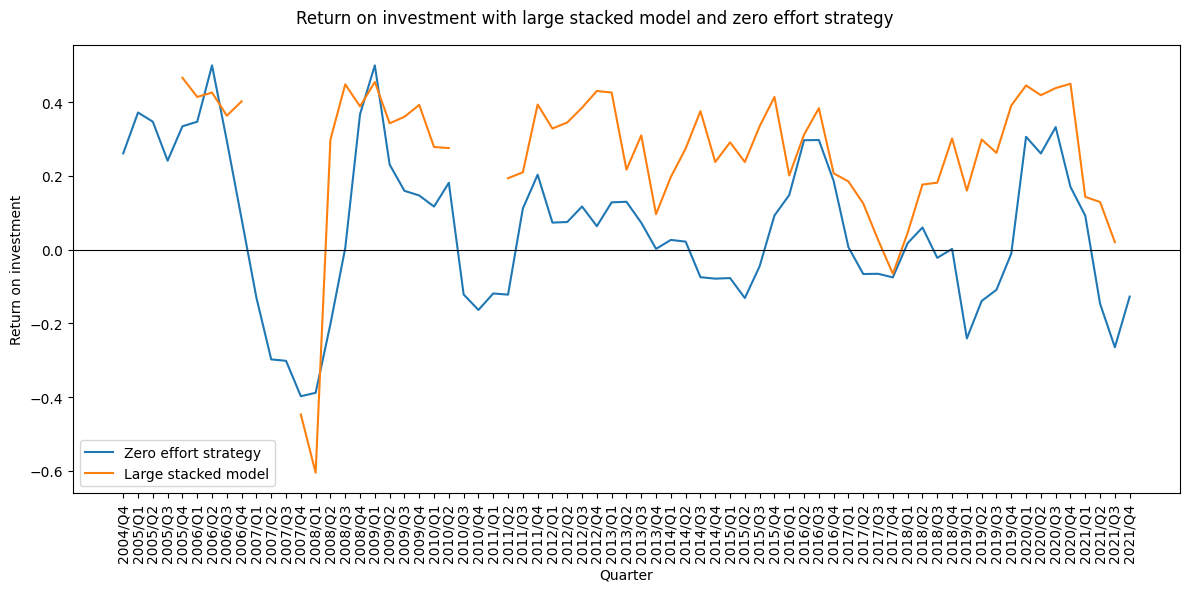

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))

plt.plot(
    large_return_df.index,
    large_return_df
)

ax.axhline(0, color='black', linewidth=.8)

ax.tick_params(axis='x', labelrotation=90)

ax.tick_params(axis='x', labelrotation=90)

ax.set_ylabel('Return on investment')
ax.set_xlabel('Quarter')

ax.legend(labels=['Zero effort strategy', 'Large stacked model'])

plt.suptitle('Return on investment with large stacked model and zero effort strategy')

plt.tight_layout();

# Summary

From a risk mitigation perspective, regression models are far superior to the best gurus' strategies. The percentage of loss-making investments was 7.68% and 10.73% for small and large stacked models, respectively. At the same time, the percentage of quarters with a loss was 6.45% and 5%, respectively. The gurus' strategies performed several times worse. Both models generally did not do badly when the WIG was below 0 - the exceptions were 2008/Q1, 2010/Q3 or 2017/Q4, nevertheless, the more common situation was the profits from both models when the WIG was negative.

Taking a closer look at the quarters in which the average return was negative, we can see that in almost all such periods the number of buy signals was relatively small or the model sent only one such signal (the exception is 2017/Q4 in the large stacked model). On the other hand, in many other quarters, both models gave a small number of buy signals, but made profits.

In [13]:
# Data frame with return on investment
summary_return_df = pd.DataFrame({
    'Zero effort strategy':dataset_preproc.groupby('quarter').final_wig_dynamics.mean(),
    'Small stacked model':prediction_df[
        prediction_df.buy_small == 'Yes'].groupby('quarter').final_price_dynamics.mean(),
    'Large stacked model':prediction_df[
        prediction_df.buy_large == 'Yes'].groupby('quarter').final_price_dynamics.mean()
})

In [14]:
# Final statistics
statistics_df = pd.DataFrame(index=[
    'Percentage of loss-making investments',
    'Percentage of profitable investments (below 50%)',
    'Percentage of profitable investments (50%)',
    'Percentage of loss-making quarters',
    'Percentage of profitable quarters',
    'Average return (%)',
    'Percentage of quarters in which strategy outperformed zero effort strategy'
])

for i, strategy in enumerate(summary_return_df.columns):
    values = []

    if strategy == 'Zero effort strategy':
        values.append('-')
        values.append('-')
        values.append('-')
    else:
        if strategy == 'Small stacked model':
            signals = prediction_df.buy_small.value_counts()[1]
            ctab = pd.crosstab(
                prediction_df.interesting_investment,
                prediction_df.buy_small
            ).reindex(['No', 'Maybe', 'Yes'], axis=0)
        elif strategy == 'Large stacked model':
            signals = prediction_df.buy_large.value_counts()[1]
            ctab = pd.crosstab(
                prediction_df.interesting_investment,
                prediction_df.buy_large
            ).reindex(['No', 'Maybe', 'Yes'], axis=0)
        # Percentage of loss-making investments
        values.append(round(100 * ctab.iloc[0, 1] / signals, 2))
        # Percentage of profitable investments < 50%
        values.append(round(100 * ctab.iloc[1, 1] / signals, 2))
        # Percentage of profitable investments == 50%
        values.append(round(100 * ctab.iloc[2, 1] / signals, 2))

    # Number of NaNs in summary_return_df
    nan_num = summary_return_df[strategy].isna().sum()

    # Percentage of loss-making quarters
    values.append(
        round(
            100 * summary_return_df[
                summary_return_df[strategy] < 0][strategy].count() / (69 - nan_num), 2
        )
    )
    # Percentage of profitable quarters
    values.append(
        round(
            100 * summary_return_df[
                summary_return_df[strategy] > 0][strategy].count() / (69 - nan_num), 2
        )
    )
    # Average return
    values.append((100 * summary_return_df[strategy].mean()).round(2))

    if strategy == 'Zero effort strategy':
        values.append('-')
    else:
        # Percentage of quarters in which strategy outperformed zero effort strategy
        values.append(
            round(
                100 * summary_return_df[summary_return_df[strategy] > 0][strategy].count() / 69, 2)
        )

    statistics_df[strategy] = values

statistics_df

Zero effort strategy  \
Percentage of loss-making investments                                 -   
Percentage of profitable investments (below 50%)                      -   
Percentage of profitable investments (50%)                            -   
Percentage of loss-making quarters                              37.6800   
Percentage of profitable quarters                               62.3200   
Average return (%)                                               5.6000   
Percentage of quarters in which strategy outper...                    -   

                                                    Small stacked model  \
Percentage of loss-making investments                            7.6800   
Percentage of profitable investments (below 50%)                38.1800   
Percentage of profitable investments (50%)                      54.1400   
Percentage of loss-making quarters                               6.4500   
Percentage of profitable quarters                               93.5500   
Average return (%)                                              29.4500   
Percentage of quarters in which strategy outper...              84.0600   

                                                    Large stacked model  
Percentage of loss-making investments                           10.7300  
Percentage of profitable investments (below 50%)                37.8500  
Percentage of profitable investments (50%)                      51.4200  
Percentage of loss-making quarters                               5.0000  
Percentage of profitable quarters                               95.0000  
Average return (%)                                              27.0000  
Percentage of quarters in which strategy outper...              82.6100

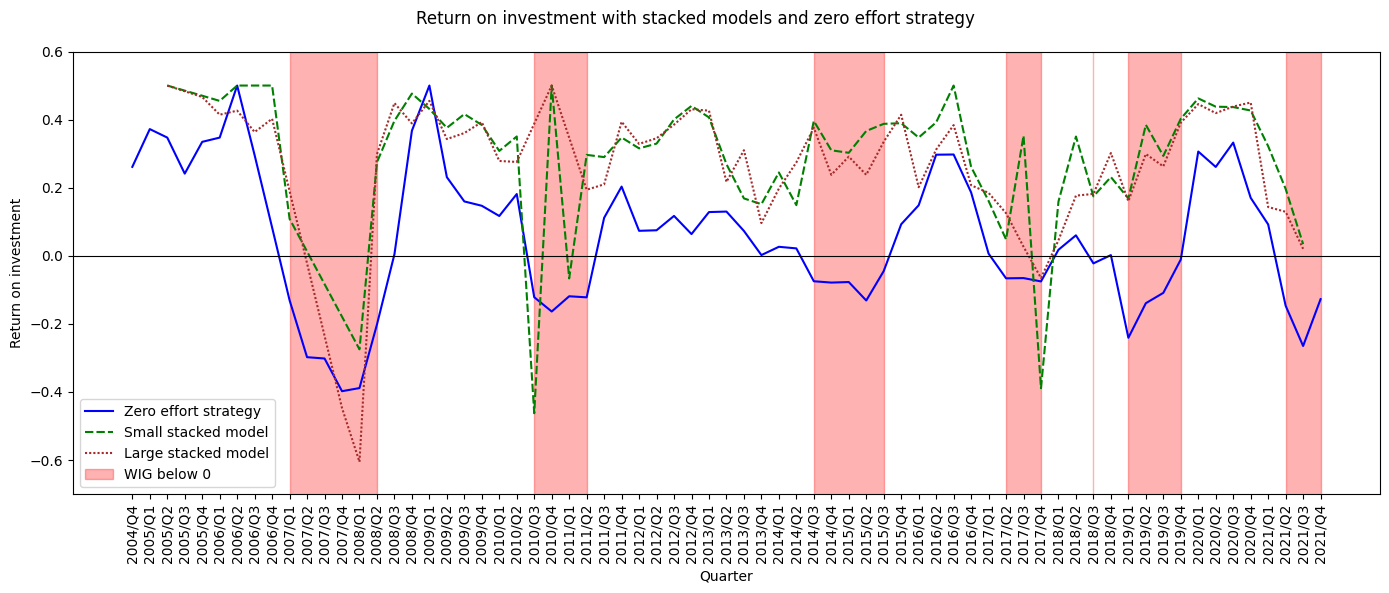

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6))

sns.lineplot(
    data=summary_return_df.filter([
        'Zero effort strategy',
        'Small stacked model',
        'Large stacked model'
    ]),
    palette=['blue', 'green', 'brown'],
    ax=ax
)

ax.fill_between(
    range(69), -0.5, 1,
    where=summary_return_df['Zero effort strategy'] < 0,
    color='red', alpha=0.3, transform=ax.get_xaxis_transform(),
    label='WIG below 0'
)

ax.axhline(0, color='black', linewidth=.8)

ax.tick_params(axis='x', labelrotation=90)

ax.set_ylim([-.7, .6])

handles, _ = ax.get_legend_handles_labels()
plt.legend(
    handles = handles,
    labels = [
        'Zero effort strategy',
        'Small stacked model',
        'Large stacked model',
        'WIG below 0'
    ]
)

ax.set_ylabel('Return on investment')
ax.set_xlabel('Quarter')

plt.suptitle(
    'Return on investment with stacked models and zero effort strategy')

plt.tight_layout();

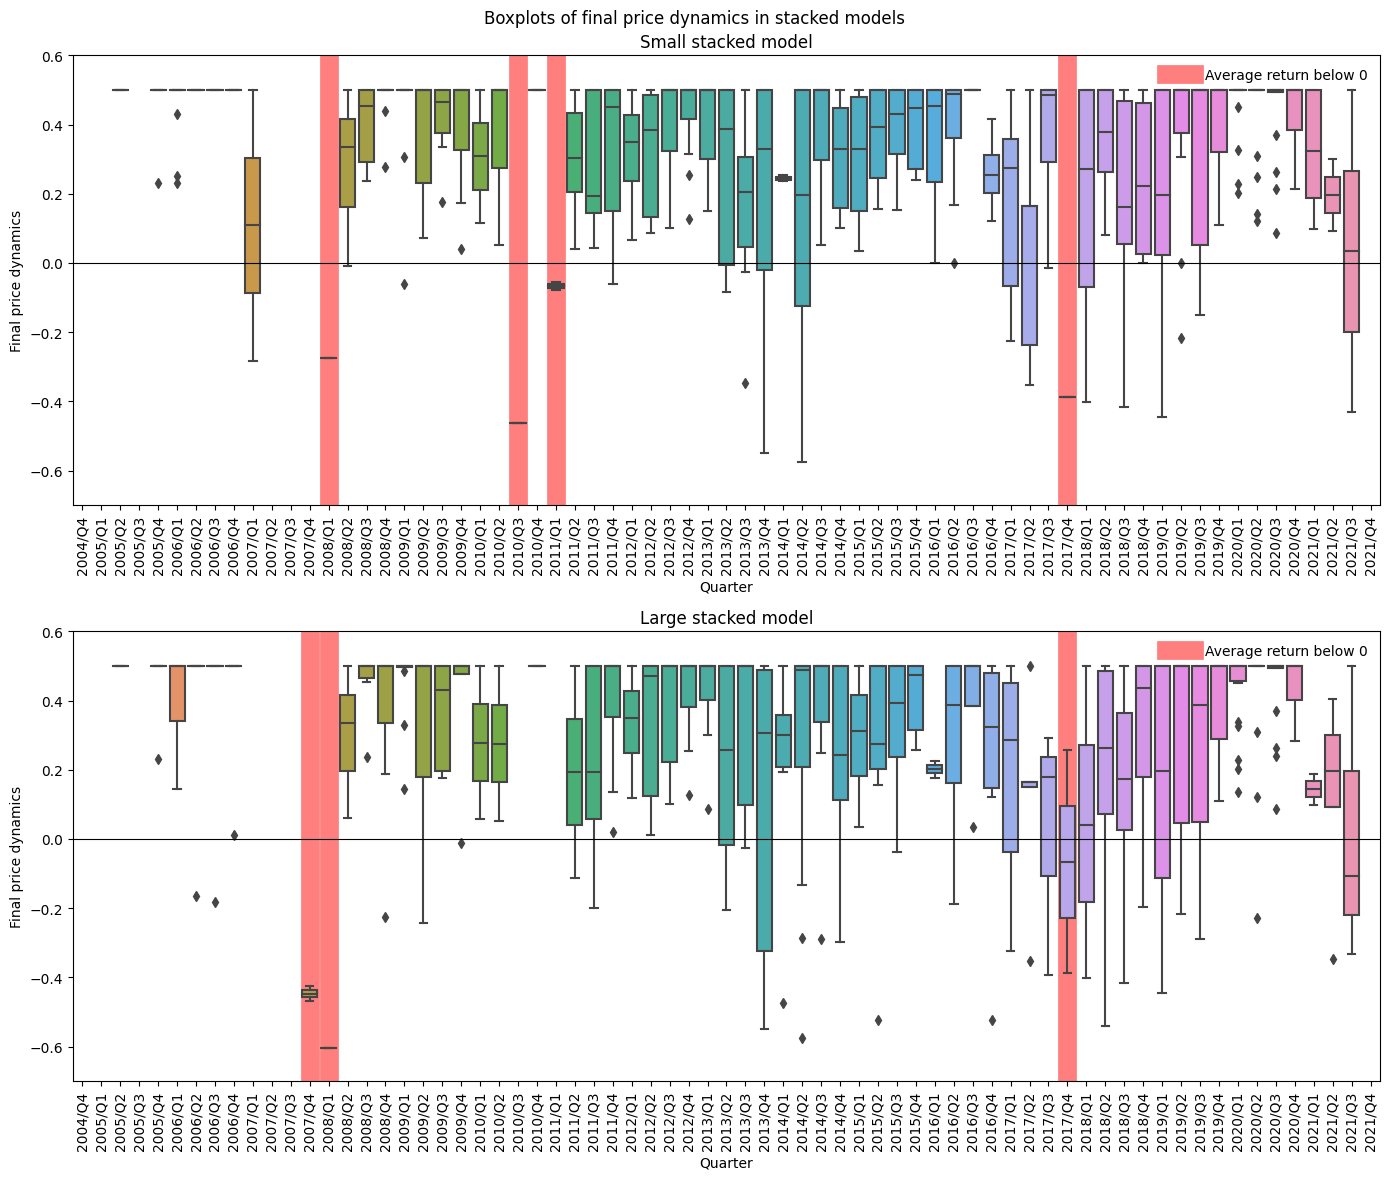

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(14, 12))

sns.boxplot(
    x=prediction_df[prediction_df.buy_small == 'Yes'].quarter,
    y=prediction_df[prediction_df.buy_small == 'Yes'].final_price_dynamics,
    order=sorted(dataset_preproc.quarter.unique()),
    ax=axs[0]
)

for i, quarter in enumerate(
    summary_return_df[summary_return_df['Small stacked model'] < 0].index.tolist()
):
    if i == 0:
        axs[0].axvline(
            summary_return_df.index.tolist().index(quarter),
            color='red', linewidth=13.5, zorder=0, alpha=.5,
            label=f'Average return below 0'
        )
    else:
        axs[0].axvline(
            summary_return_df.index.tolist().index(quarter),
            color='red', linewidth=13.5, zorder=0, alpha=.5
        )

axs[0].legend(frameon=False)

sns.boxplot(
    x=prediction_df[prediction_df.buy_large == 'Yes'].quarter,
    y=prediction_df[prediction_df.buy_large == 'Yes'].final_price_dynamics,
    order=sorted(dataset_preproc.quarter.unique()),
    ax=axs[1]
)

for i, quarter in enumerate(
    summary_return_df[summary_return_df['Large stacked model'] < 0].index.tolist()
):
    if i == 0:
        axs[1].axvline(
            summary_return_df.index.tolist().index(quarter),
            color='red', linewidth=13.5, zorder=0, alpha=.5,
            label=f'Average return below 0'
        )
    else:
        axs[1].axvline(
            summary_return_df.index.tolist().index(quarter),
            color='red', linewidth=13.5, zorder=0, alpha=.5
        )

axs[1].legend(frameon=False)

for i in range(2):
    axs[i].axhline(0, color='black', linewidth=.8)
    axs[i].tick_params(axis='x', labelrotation=90)
    axs[i].set_ylim([-.7, .6])

    axs[i].set_ylabel('Final price dynamics')
    axs[i].set_xlabel('Quarter')

plt.suptitle('Boxplots of final price dynamics in stacked models')
axs[0].set_title('Small stacked model')
axs[1].set_title('Large stacked model')

plt.tight_layout();